In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import MNIST, FashionMNIST
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Utils

In [ ]:
def to_binary(x, threshold):
  return torch.where(
      x > threshold, torch.tensor(1, dtype=x.dtype), torch.tensor(0, dtype=x.dtype))

def create_negative_data(x):
  n = x.shape[0]

  mask = np.random.randint(2, size=(n, 28, 28))
  mask = mask.astype(np.float32)

  print('Creating negative data . . .')

  for i in tqdm(range(n)):
    for _ in range(30):
      mask[i] = cv2.filter2D(
          mask[i], -1, kernel=np.array([[1/4, 1/2, 1/4]])
      )
      mask[i] = cv2.filter2D(
          mask[i], -1, kernel=np.array([[1/4], [1/2], [1/4]])
      )

  mask = cv2.threshold(mask, 0.5, 1, cv2.THRESH_BINARY)[1]

  x_neg = x[torch.randperm(n)] * mask + x[torch.randperm(n)] * (1 - mask)

  return x_neg.type(torch.uint8)


class FFDataset(Dataset):
    def __init__(self, h_pos):
        self.h_pos = h_pos

    def __len__(self):
        return self.h_pos.shape[0]

    def __getitem__(self, idx):
        return self.h_pos[idx]

class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


def display(x_recon):
  '''
    x_recon: (N, 1, 28, 28)
  '''

  x_recon = x_recon.cpu().detach()

  idxs = np.random.choice(x_recon.shape[0], 100, replace=False)

  samples = x_recon[idxs].squeeze().permute(1, 2, 0).numpy()
  samples = samples.reshape(28, 28, 10, 10).transpose(2,0,3,1).reshape(28*10,-1)

  plt.figure(figsize = (8,8))
  plt.axis('off')
  plt.imshow(samples, cmap='gray')

### FF

In [ ]:
import itertools

class LocalConv(nn.Module):
    def __init__(self,
                 out_channels,
                 input_shape,
                 kernel_size,
                 strides,
                 bias=False,
                ):
      super().__init__()

      self.out_channels = out_channels
      self.kernel_size = kernel_size
      self.strides = strides
      self.bias = bias

      input_row, input_col = input_shape[1:]
      input_filter = input_shape[0]

      output_row = self.output_length(input_row, self.kernel_size[0], self.strides[0])
      output_col = self.output_length(input_col, self.kernel_size[1], self.strides[1])

      self.output_shape = (output_row, output_col)

      self.kernel_shape = (output_row * output_col,
                           self.kernel_size[0] * self.kernel_size[1] * input_filter,
                           self.out_channels
                           )

      self.kernel = nn.Parameter(torch.randn(self.kernel_shape))

      if self.bias:
        self.bias_shape = (self.out_channels, output_row, output_col)
        self.bias = nn.Parameter(torch.randn(self.bias_shape))

    def output_length(self, input_length, kernel_size, stride):
      output_length = input_length - kernel_size + 1
      return (output_length + stride - 1) // stride

    def forward(self, inputs):
      feature_dim = self.kernel_shape[1]
      channels_out = self.kernel_shape[-1]

      xs = []
      output_axes_ticks = [range(axis_max) for axis_max in self.output_shape]
      for position in itertools.product(*output_axes_ticks):
        slices = [slice(None)]
        slices.append(slice(None))
        slices.extend(
            slice(
                position[d] * self.strides[d],
                position[d] * self.strides[d] + self.kernel_size[d],
            )
            for d in [0, 1]
        )
        xs.append(torch.reshape(inputs[slices], (1, -1, feature_dim)))

      x_aggregate = torch.cat(xs)

      output = torch.bmm(x_aggregate, self.kernel)
      output = torch.reshape(output, (self.output_shape + (-1, channels_out)))
      output =  torch.permute(output, (2, 3, 0, 1))

      if self.bias is not False:
        output = output + self.bias.unsqueeze(0)
      return output

class FFRFLayer(nn.Module):
    def __init__(self, out_channel, input_shape, kernel_size, strides, dropout):
        super().__init__()

        self.local_conv = LocalConv(out_channel, input_shape, kernel_size, strides, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        output = F.relu(self.dropout(self.local_conv(x)))
        normalized = self.normalize(output)
        return output, normalized

    def normalize(self, x):
        return x / (x.norm(p=2, dim=(1, 2, 3), keepdim=True) + 1e-7)

class FFRFNN:
    def __init__(self,
                 dropout,
                 threshold,
                 lr,
                 batch_size,
                 epochs,
                 momentum,
                 alpha,
                 device
                ):
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        self.device = device
        self.lr = lr

        self.fflayers = [
            FFRFLayer(32, (1,28,28), (7,7), (3, 3), dropout).to(device),
            FFRFLayer(256, (32, 8, 8), (4, 4), (2, 2), dropout).to(device),
            nn.Sequential(
                nn.Upsample(size=(8, 8), mode='bilinear'),
                FFRFLayer(32, (256, 8, 8), (1, 1), (1, 1), dropout)
            ).to(device)
        ]

        self.optimizers = [torch.optim.Adam(l.parameters(), lr=lr) for l in self.fflayers]

        self.decoder = nn.Sequential(
            nn.Upsample(size=(28, 28), mode='bilinear'),
            LocalConv(1, (64, 28, 28), (1,1), (1,1), bias=False)
        ).to(device)
        self.optimizer = torch.optim.Adam(self.decoder.parameters(), lr=lr)

        self.criterion = nn.BCEWithLogitsLoss()

        self.loss_history = []

        self.momentum = momentum
        self.alpha = alpha
        self.running_mean = torch.zeros((len(self.fflayers)), device=self.device, requires_grad=False)

    def peer_normalization(self, y, i):
      '''
        y: activity [N, C, H, W]
        i: layer idx
      '''
      avg_activities = y.mean(dim=(0,2,3))
      self.running_mean[i] = (1 - self.momentum) * self.running_mean[i] + self.momentum * avg_activities.mean().detach()
      return (avg_activities - self.running_mean[i]).pow(2).mean()

    def train(self, x_pos):
      dataset = FFDataset(x_pos)
      train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

      for epoch in range(self.epochs):
        print(f'\n__ Epoch {epoch+1} __')

        epoch_loss = [0 for _ in range(len(self.fflayers)+1)]
        bar = tqdm(train_loader)

        for x_pos_batch in bar:
          x_pos_batch = x_pos_batch.to(self.device)

          # ff-layers positive path
          normalized_outputs = []
          h_pos_batch = x_pos_batch
          for i, layer in enumerate(self.fflayers):
            layer.train()

            output, normalized = layer(h_pos_batch)

            goodness = output.pow(2).sum(dim=(1,2,3))
            loss = self.criterion(goodness - self.threshold, torch.ones((goodness.shape[0]), device=goodness.device)) \
                   + self.alpha * self.peer_normalization(output, i)

            self.optimizers[i].zero_grad()
            loss.backward()
            self.optimizers[i].step()

            h_pos_batch = normalized.detach()

            normalized_outputs.append(h_pos_batch)

            epoch_loss[i] += loss.item()

          # final layer for generating negative samples
          self.decoder.train()

          cat_outputs = torch.cat([normalized_outputs[0], normalized_outputs[-1]], dim=1)
          x_neg_batch = self.decoder(cat_outputs)

          loss = self.criterion(x_neg_batch, x_pos_batch)

          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          epoch_loss[-1] += loss.item()

          # ff-layers negative path
          h_neg_batch = to_binary(F.sigmoid(x_neg_batch), 0.5).detach()
          for i, layer in enumerate(self.fflayers):
            layer.train()

            output, normalized = layer(h_neg_batch)

            goodness = output.pow(2).sum(dim=(1,2,3))
            loss = self.criterion(goodness - self.threshold, torch.zeros((goodness.shape[0]), device=goodness.device)) \
                   + self.alpha * self.peer_normalization(output, i)

            self.optimizers[i].zero_grad()
            loss.backward()
            self.optimizers[i].step()

            h_neg_batch = normalized.detach()

            epoch_loss[i] += loss.item()

        for i in range(len(epoch_loss) - 1):
          epoch_loss[i] /= (len(train_loader)*2)
        epoch_loss[-1] /= len(train_loader)

        self.loss_history.append(epoch_loss)

        for i in range(len(epoch_loss)):
          print(f'Layer-{i}: {epoch_loss[i]:.5f}')

    def reconstruct(self, dataloader):
      print('[Reconstruction]')
      bar = tqdm(dataloader)

      results = []

      with torch.no_grad():
        for x_batch in bar:
          x_batch = x_batch.to(self.device)
          cat = []
          for layer in self.fflayers:
            layer.eval()
            _, x_batch = layer(x_batch)
            cat.append(x_batch)

          cat_outputs = torch.cat([cat[0], cat[-1]], dim=1)
          self.decoder.eval()
          x_recon = self.decoder(cat_outputs)
          results.append(F.sigmoid(x_recon))

      x_recon_binary = to_binary(torch.cat(results, dim=0), 0.5)

      return x_recon_binary

    def train_classifier(self, x, labels):
      print(f'\n[Linear Layer]')

      # get features
      dataset = FFDataset(x)
      train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

      ff_outputs = []

      bar = tqdm(train_loader)
      for x_pos_batch in bar:
        x_pos_batch = x_pos_batch.to(self.device)

        normalized_outputs = []
        h_pos_batch = x_pos_batch
        for i, layer in enumerate(self.fflayers):
          layer.eval()

          _, normalized = layer(h_pos_batch)

          h_pos_batch = normalized.detach()

          normalized_outputs.append(h_pos_batch.reshape(h_pos_batch.shape[0], -1))

        ff_outputs.append(normalized_outputs)

      ff_outputs = list(map(list, zip(*ff_outputs)))
      ff_outputs = [torch.cat(layer_output, dim=0) for layer_output in ff_outputs]

      ff_outputs = torch.cat([ff_outputs[0], ff_outputs[2]], dim=1)

      # train classifier
      self.classifier_loss_history = []
      self.classifier_acc_history = []

      self.linear = nn.Linear(ff_outputs.shape[1], 10).to(self.device)
      self.linear.train()

      criterion = nn.CrossEntropyLoss()
      optimizer = torch.optim.Adam(self.linear.parameters(), lr=self.lr)

      dataset = SimpleDataset(ff_outputs, labels)
      train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

      for epoch in range(self.epochs):
        print(f'__ Epoch {epoch+1} __')

        epoch_loss = 0
        epoch_acc = 0

        bar = tqdm(train_loader)
        for x_batch, y_batch in bar:
          x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)

          outputs = self.linear(x_batch)

          loss = criterion(outputs, y_batch)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          preds = torch.argmax(outputs, dim=1)
          epoch_acc += (preds == y_batch).to(torch.float).mean().item()
          epoch_loss += loss.item()

        epoch_loss /= len(train_loader)
        epoch_acc /= len(train_loader)
        print(f'Loss: {epoch_loss:.5f} / Acc: {epoch_acc:.5f}')

        self.classifier_loss_history.append(epoch_loss)
        self.classifier_acc_history.append(epoch_acc)

    def classifier(self, x):
      dataset = FFDataset(x)
      loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=False)

      preds = []

      self.linear.eval()

      bar = tqdm(loader)
      for x_pos_batch in bar:
        x_pos_batch = x_pos_batch.to(self.device)

        normalized_outputs = []
        h_pos_batch = x_pos_batch
        for i, layer in enumerate(self.fflayers):
          layer.eval()

          _, normalized = layer(h_pos_batch)

          h_pos_batch = normalized.detach()

          normalized_outputs.append(h_pos_batch.reshape(h_pos_batch.shape[0], -1))


        ff_outputs = torch.cat([normalized_outputs[0], normalized_outputs[2]], dim=1)

        outputs = self.linear(ff_outputs)

        preds.append(torch.argmax(outputs, dim=1))

      return torch.cat(preds)

### Train

In [ ]:
from sklearn.metrics import f1_score

train_set = MNIST('./data/', train=True, download=True)
x_pos = train_set.data.type(torch.float32) / 255
x_pos = to_binary(x_pos, 0.5).unsqueeze(1)

test_set = MNIST('./data/', train=False, download=True)
x_test = test_set.data.type(torch.float32) / 255
x_test = to_binary(x_test, 0.5).unsqueeze(1)

classifier_losses = []
classifier_accs = []
test_accs = []
test_fs = []

model = FFRFNN(
    dropout=0.3,
    threshold=18,
    lr=0.008,
    batch_size=500,
    epochs=100,
    momentum=0.3,
    alpha=0.5,
    device='cuda:0'
)

model.train(x_pos)

p = [1/1024, 1/512, 1/256, 1/128, 1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1]
p_str = ['1/1024', '1/512', '1/256', '1/128', '1/64', '1/32', '1/16', '1/8', '1/4', '1/2', '1']

for i in p:
  if i==1:
    labeled_idx = np.arange(len(x_pos))
  else:
    _, labeled_idx = train_test_split(np.arange(len(x_pos)),
                                      test_size=i,
                                      random_state=1,
                                      shuffle=True,
                                      stratify=train_set.targets)

  labeled_x = x_pos[labeled_idx]
  labels = train_set.targets[labeled_idx]

  model.train_classifier(labeled_x, labels)

  classifier_losses.append(model.classifier_loss_history)
  classifier_accs.append(model.classifier_acc_history)

  # test
  preds = model.classifier(x_test)
  test_accs.append((preds.cpu() == test_set.targets).to(torch.float).mean().item())
  test_fs.append(f1_score(test_set.targets, preds.cpu(), average='macro'))

100%|██████████| 120/120 [00:08<00:00, 14.54it/s]


Layer-0: 1989.70877
Layer-1: 10.26908
Layer-2: 3.60545
Layer-3: 0.64607

__ Epoch 2 __


100%|██████████| 120/120 [00:08<00:00, 14.46it/s]


Layer-0: 143.89678
Layer-1: 0.65636
Layer-2: 0.58158
Layer-3: 0.58804

__ Epoch 3 __


100%|██████████| 120/120 [00:10<00:00, 11.98it/s]


Layer-0: 41.27010
Layer-1: 0.57630
Layer-2: 0.34323
Layer-3: 0.56261

__ Epoch 4 __


100%|██████████| 120/120 [00:07<00:00, 16.60it/s]


Layer-0: 17.22557
Layer-1: 0.66742
Layer-2: 0.34321
Layer-3: 0.54480

__ Epoch 5 __


100%|██████████| 120/120 [00:07<00:00, 16.47it/s]


Layer-0: 9.26179
Layer-1: 0.59369
Layer-2: 0.32007
Layer-3: 0.52836

__ Epoch 6 __


100%|██████████| 120/120 [00:09<00:00, 12.88it/s]


Layer-0: 5.61586
Layer-1: 0.43041
Layer-2: 0.27190
Layer-3: 0.51265

__ Epoch 7 __


100%|██████████| 120/120 [00:07<00:00, 16.87it/s]


Layer-0: 3.90753
Layer-1: 0.28516
Layer-2: 0.21697
Layer-3: 0.49824

__ Epoch 8 __


100%|██████████| 120/120 [00:06<00:00, 17.45it/s]


Layer-0: 2.67392
Layer-1: 0.21747
Layer-2: 0.18445
Layer-3: 0.48412

__ Epoch 9 __


100%|██████████| 120/120 [00:09<00:00, 12.61it/s]


Layer-0: 1.96749
Layer-1: 0.17853
Layer-2: 0.16444
Layer-3: 0.47189

__ Epoch 10 __


100%|██████████| 120/120 [00:09<00:00, 12.41it/s]


Layer-0: 1.33106
Layer-1: 0.17699
Layer-2: 0.15322
Layer-3: 0.45702

__ Epoch 11 __


100%|██████████| 120/120 [00:10<00:00, 11.56it/s]


Layer-0: 0.92269
Layer-1: 0.14177
Layer-2: 0.11824
Layer-3: 0.44314

__ Epoch 12 __


100%|██████████| 120/120 [00:11<00:00, 10.56it/s]


Layer-0: 0.73953
Layer-1: 0.11840
Layer-2: 0.11527
Layer-3: 0.43412

__ Epoch 13 __


100%|██████████| 120/120 [00:11<00:00, 10.66it/s]


Layer-0: 0.62858
Layer-1: 0.09872
Layer-2: 0.11284
Layer-3: 0.42315

__ Epoch 14 __


100%|██████████| 120/120 [00:07<00:00, 16.15it/s]


Layer-0: 0.54120
Layer-1: 0.09420
Layer-2: 0.12576
Layer-3: 0.41453

__ Epoch 15 __


100%|██████████| 120/120 [00:06<00:00, 17.64it/s]


Layer-0: 0.46582
Layer-1: 0.10272
Layer-2: 0.12933
Layer-3: 0.40680

__ Epoch 16 __


100%|██████████| 120/120 [00:07<00:00, 16.74it/s]


Layer-0: 0.49154
Layer-1: 0.10312
Layer-2: 0.13895
Layer-3: 0.40044

__ Epoch 17 __


100%|██████████| 120/120 [00:06<00:00, 18.33it/s]


Layer-0: 0.43327
Layer-1: 0.10379
Layer-2: 0.14201
Layer-3: 0.39389

__ Epoch 18 __


100%|██████████| 120/120 [00:07<00:00, 16.55it/s]


Layer-0: 0.39972
Layer-1: 0.09268
Layer-2: 0.14373
Layer-3: 0.38745

__ Epoch 19 __


100%|██████████| 120/120 [00:06<00:00, 18.15it/s]


Layer-0: 0.34151
Layer-1: 0.09777
Layer-2: 0.15166
Layer-3: 0.38161

__ Epoch 20 __


100%|██████████| 120/120 [00:07<00:00, 16.78it/s]


Layer-0: 0.33280
Layer-1: 0.09419
Layer-2: 0.15188
Layer-3: 0.37692

__ Epoch 21 __


100%|██████████| 120/120 [00:06<00:00, 18.14it/s]


Layer-0: 0.31941
Layer-1: 0.09615
Layer-2: 0.15442
Layer-3: 0.37320

__ Epoch 22 __


100%|██████████| 120/120 [00:07<00:00, 16.63it/s]


Layer-0: 0.29053
Layer-1: 0.10105
Layer-2: 0.16492
Layer-3: 0.36978

__ Epoch 23 __


100%|██████████| 120/120 [00:06<00:00, 18.06it/s]


Layer-0: 0.24579
Layer-1: 0.10608
Layer-2: 0.17654
Layer-3: 0.36688

__ Epoch 24 __


100%|██████████| 120/120 [00:07<00:00, 16.23it/s]


Layer-0: 0.23956
Layer-1: 0.11887
Layer-2: 0.19420
Layer-3: 0.36636

__ Epoch 25 __


100%|██████████| 120/120 [00:06<00:00, 18.32it/s]


Layer-0: 0.23969
Layer-1: 0.13085
Layer-2: 0.21642
Layer-3: 0.36545

__ Epoch 26 __


100%|██████████| 120/120 [00:07<00:00, 16.81it/s]


Layer-0: 0.21584
Layer-1: 0.13682
Layer-2: 0.23100
Layer-3: 0.36269

__ Epoch 27 __


100%|██████████| 120/120 [00:07<00:00, 16.67it/s]


Layer-0: 0.20887
Layer-1: 0.15126
Layer-2: 0.24613
Layer-3: 0.36031

__ Epoch 28 __


100%|██████████| 120/120 [00:06<00:00, 17.40it/s]


Layer-0: 0.19132
Layer-1: 0.15478
Layer-2: 0.24951
Layer-3: 0.35767

__ Epoch 29 __


100%|██████████| 120/120 [00:07<00:00, 16.75it/s]


Layer-0: 0.17693
Layer-1: 0.16162
Layer-2: 0.26193
Layer-3: 0.35486

__ Epoch 30 __


100%|██████████| 120/120 [00:06<00:00, 17.87it/s]


Layer-0: 0.16054
Layer-1: 0.16764
Layer-2: 0.27040
Layer-3: 0.35145

__ Epoch 31 __


100%|██████████| 120/120 [00:07<00:00, 16.46it/s]


Layer-0: 0.15131
Layer-1: 0.16580
Layer-2: 0.27361
Layer-3: 0.34658

__ Epoch 32 __


100%|██████████| 120/120 [00:07<00:00, 16.23it/s]


Layer-0: 0.14015
Layer-1: 0.17127
Layer-2: 0.28406
Layer-3: 0.34213

__ Epoch 33 __


100%|██████████| 120/120 [00:07<00:00, 16.31it/s]


Layer-0: 0.13602
Layer-1: 0.16055
Layer-2: 0.27465
Layer-3: 0.33847

__ Epoch 34 __


100%|██████████| 120/120 [00:06<00:00, 17.64it/s]


Layer-0: 0.12698
Layer-1: 0.16030
Layer-2: 0.27411
Layer-3: 0.33479

__ Epoch 35 __


100%|██████████| 120/120 [00:07<00:00, 15.61it/s]


Layer-0: 0.12454
Layer-1: 0.16751
Layer-2: 0.28037
Layer-3: 0.33341

__ Epoch 36 __


100%|██████████| 120/120 [00:07<00:00, 15.93it/s]


Layer-0: 0.11310
Layer-1: 0.16958
Layer-2: 0.28715
Layer-3: 0.33150

__ Epoch 37 __


100%|██████████| 120/120 [00:07<00:00, 16.05it/s]


Layer-0: 0.11891
Layer-1: 0.17381
Layer-2: 0.29585
Layer-3: 0.32947

__ Epoch 38 __


100%|██████████| 120/120 [00:07<00:00, 15.52it/s]


Layer-0: 0.11742
Layer-1: 0.17963
Layer-2: 0.29850
Layer-3: 0.32824

__ Epoch 39 __


100%|██████████| 120/120 [00:07<00:00, 17.05it/s]


Layer-0: 0.09825
Layer-1: 0.17025
Layer-2: 0.29316
Layer-3: 0.32877

__ Epoch 40 __


100%|██████████| 120/120 [00:07<00:00, 15.60it/s]


Layer-0: 0.09244
Layer-1: 0.17831
Layer-2: 0.30069
Layer-3: 0.32497

__ Epoch 41 __


100%|██████████| 120/120 [00:07<00:00, 17.09it/s]


Layer-0: 0.08566
Layer-1: 0.17249
Layer-2: 0.30168
Layer-3: 0.32238

__ Epoch 42 __


100%|██████████| 120/120 [00:07<00:00, 15.56it/s]


Layer-0: 0.07791
Layer-1: 0.17403
Layer-2: 0.30714
Layer-3: 0.32076

__ Epoch 43 __


100%|██████████| 120/120 [00:07<00:00, 16.65it/s]


Layer-0: 0.07609
Layer-1: 0.17828
Layer-2: 0.30985
Layer-3: 0.31703

__ Epoch 44 __


100%|██████████| 120/120 [00:07<00:00, 15.94it/s]


Layer-0: 0.07675
Layer-1: 0.18697
Layer-2: 0.32610
Layer-3: 0.31441

__ Epoch 45 __


100%|██████████| 120/120 [00:07<00:00, 16.58it/s]


Layer-0: 0.07433
Layer-1: 0.18010
Layer-2: 0.31680
Layer-3: 0.31299

__ Epoch 46 __


100%|██████████| 120/120 [00:06<00:00, 17.67it/s]


Layer-0: 0.07943
Layer-1: 0.18915
Layer-2: 0.32626
Layer-3: 0.31157

__ Epoch 47 __


100%|██████████| 120/120 [00:07<00:00, 16.50it/s]


Layer-0: 0.08722
Layer-1: 0.18760
Layer-2: 0.33689
Layer-3: 0.30989

__ Epoch 48 __


100%|██████████| 120/120 [00:06<00:00, 18.11it/s]


Layer-0: 0.08783
Layer-1: 0.19367
Layer-2: 0.35312
Layer-3: 0.30643

__ Epoch 49 __


100%|██████████| 120/120 [00:07<00:00, 15.88it/s]


Layer-0: 0.09793
Layer-1: 0.21103
Layer-2: 0.37070
Layer-3: 0.30258

__ Epoch 50 __


100%|██████████| 120/120 [00:06<00:00, 18.03it/s]


Layer-0: 0.09564
Layer-1: 0.21533
Layer-2: 0.38373
Layer-3: 0.29822

__ Epoch 51 __


100%|██████████| 120/120 [00:07<00:00, 16.61it/s]


Layer-0: 0.08721
Layer-1: 0.21671
Layer-2: 0.38846
Layer-3: 0.29521

__ Epoch 52 __


100%|██████████| 120/120 [00:06<00:00, 18.23it/s]


Layer-0: 0.08742
Layer-1: 0.20520
Layer-2: 0.38281
Layer-3: 0.29337

__ Epoch 53 __


100%|██████████| 120/120 [00:07<00:00, 16.69it/s]


Layer-0: 0.08321
Layer-1: 0.21413
Layer-2: 0.39361
Layer-3: 0.29025

__ Epoch 54 __


100%|██████████| 120/120 [00:06<00:00, 18.00it/s]


Layer-0: 0.08361
Layer-1: 0.22097
Layer-2: 0.40836
Layer-3: 0.28939

__ Epoch 55 __


100%|██████████| 120/120 [00:07<00:00, 16.58it/s]


Layer-0: 0.08254
Layer-1: 0.22578
Layer-2: 0.41224
Layer-3: 0.28819

__ Epoch 56 __


100%|██████████| 120/120 [00:06<00:00, 17.46it/s]


Layer-0: 0.08675
Layer-1: 0.22506
Layer-2: 0.41994
Layer-3: 0.28548

__ Epoch 57 __


100%|██████████| 120/120 [00:06<00:00, 17.23it/s]


Layer-0: 0.08677
Layer-1: 0.23106
Layer-2: 0.42667
Layer-3: 0.28496

__ Epoch 58 __


100%|██████████| 120/120 [00:07<00:00, 16.79it/s]


Layer-0: 0.08858
Layer-1: 0.23712
Layer-2: 0.43696
Layer-3: 0.28304

__ Epoch 59 __


100%|██████████| 120/120 [00:06<00:00, 17.47it/s]


Layer-0: 0.08249
Layer-1: 0.23431
Layer-2: 0.44092
Layer-3: 0.28020

__ Epoch 60 __


100%|██████████| 120/120 [00:07<00:00, 16.51it/s]


Layer-0: 0.09079
Layer-1: 0.23844
Layer-2: 0.44120
Layer-3: 0.27866

__ Epoch 61 __


100%|██████████| 120/120 [00:06<00:00, 17.49it/s]


Layer-0: 0.08441
Layer-1: 0.23737
Layer-2: 0.43601
Layer-3: 0.27866

__ Epoch 62 __


100%|██████████| 120/120 [00:07<00:00, 15.72it/s]


Layer-0: 0.09368
Layer-1: 0.24113
Layer-2: 0.44286
Layer-3: 0.27650

__ Epoch 63 __


100%|██████████| 120/120 [00:07<00:00, 17.02it/s]


Layer-0: 0.09846
Layer-1: 0.24917
Layer-2: 0.45078
Layer-3: 0.27406

__ Epoch 64 __


100%|██████████| 120/120 [00:07<00:00, 15.68it/s]


Layer-0: 0.09524
Layer-1: 0.23902
Layer-2: 0.44416
Layer-3: 0.27202

__ Epoch 65 __


100%|██████████| 120/120 [00:07<00:00, 16.59it/s]


Layer-0: 0.09169
Layer-1: 0.23616
Layer-2: 0.44039
Layer-3: 0.27031

__ Epoch 66 __


100%|██████████| 120/120 [00:07<00:00, 16.07it/s]


Layer-0: 0.09499
Layer-1: 0.24410
Layer-2: 0.45172
Layer-3: 0.26862

__ Epoch 67 __


100%|██████████| 120/120 [00:07<00:00, 15.88it/s]


Layer-0: 0.09856
Layer-1: 0.24911
Layer-2: 0.44943
Layer-3: 0.26729

__ Epoch 68 __


100%|██████████| 120/120 [00:07<00:00, 16.90it/s]


Layer-0: 0.10566
Layer-1: 0.25714
Layer-2: 0.45722
Layer-3: 0.26636

__ Epoch 69 __


100%|██████████| 120/120 [00:07<00:00, 15.73it/s]


Layer-0: 0.10252
Layer-1: 0.25752
Layer-2: 0.46577
Layer-3: 0.26464

__ Epoch 70 __


100%|██████████| 120/120 [00:06<00:00, 17.15it/s]


Layer-0: 0.10009
Layer-1: 0.25746
Layer-2: 0.46682
Layer-3: 0.26237

__ Epoch 71 __


100%|██████████| 120/120 [00:07<00:00, 15.76it/s]


Layer-0: 0.10037
Layer-1: 0.26116
Layer-2: 0.46896
Layer-3: 0.26268

__ Epoch 72 __


100%|██████████| 120/120 [00:07<00:00, 16.95it/s]


Layer-0: 0.09924
Layer-1: 0.25664
Layer-2: 0.46239
Layer-3: 0.26220

__ Epoch 73 __


100%|██████████| 120/120 [00:07<00:00, 15.73it/s]


Layer-0: 0.10317
Layer-1: 0.26444
Layer-2: 0.47696
Layer-3: 0.25990

__ Epoch 74 __


100%|██████████| 120/120 [00:07<00:00, 15.56it/s]


Layer-0: 0.10220
Layer-1: 0.26842
Layer-2: 0.47851
Layer-3: 0.25716

__ Epoch 75 __


100%|██████████| 120/120 [00:07<00:00, 16.54it/s]


Layer-0: 0.11013
Layer-1: 0.26988
Layer-2: 0.47639
Layer-3: 0.25700

__ Epoch 76 __


100%|██████████| 120/120 [00:07<00:00, 15.80it/s]


Layer-0: 0.10924
Layer-1: 0.27770
Layer-2: 0.48863
Layer-3: 0.25506

__ Epoch 77 __


100%|██████████| 120/120 [00:06<00:00, 17.15it/s]


Layer-0: 0.11447
Layer-1: 0.27346
Layer-2: 0.48242
Layer-3: 0.25370

__ Epoch 78 __


100%|██████████| 120/120 [00:07<00:00, 15.69it/s]


Layer-0: 0.11750
Layer-1: 0.27285
Layer-2: 0.48411
Layer-3: 0.25246

__ Epoch 79 __


100%|██████████| 120/120 [00:07<00:00, 17.01it/s]


Layer-0: 0.12098
Layer-1: 0.27933
Layer-2: 0.49243
Layer-3: 0.24935

__ Epoch 80 __


100%|██████████| 120/120 [00:07<00:00, 15.55it/s]


Layer-0: 0.12276
Layer-1: 0.28046
Layer-2: 0.48694
Layer-3: 0.24879

__ Epoch 81 __


100%|██████████| 120/120 [00:07<00:00, 16.35it/s]


Layer-0: 0.12407
Layer-1: 0.29029
Layer-2: 0.50052
Layer-3: 0.24726

__ Epoch 82 __


100%|██████████| 120/120 [00:07<00:00, 16.26it/s]


Layer-0: 0.12406
Layer-1: 0.27556
Layer-2: 0.48699
Layer-3: 0.24503

__ Epoch 83 __


100%|██████████| 120/120 [00:07<00:00, 15.61it/s]


Layer-0: 0.13272
Layer-1: 0.28747
Layer-2: 0.49385
Layer-3: 0.24383

__ Epoch 84 __


100%|██████████| 120/120 [00:07<00:00, 17.04it/s]


Layer-0: 0.13109
Layer-1: 0.28193
Layer-2: 0.49211
Layer-3: 0.24209

__ Epoch 85 __


100%|██████████| 120/120 [00:07<00:00, 15.65it/s]


Layer-0: 0.13323
Layer-1: 0.28224
Layer-2: 0.48858
Layer-3: 0.24037

__ Epoch 86 __


100%|██████████| 120/120 [00:07<00:00, 17.00it/s]


Layer-0: 0.12918
Layer-1: 0.28111
Layer-2: 0.49069
Layer-3: 0.24044

__ Epoch 87 __


100%|██████████| 120/120 [00:07<00:00, 15.27it/s]


Layer-0: 0.14219
Layer-1: 0.28978
Layer-2: 0.50217
Layer-3: 0.23750

__ Epoch 88 __


100%|██████████| 120/120 [00:07<00:00, 16.66it/s]


Layer-0: 0.14275
Layer-1: 0.28952
Layer-2: 0.49591
Layer-3: 0.23621

__ Epoch 89 __


100%|██████████| 120/120 [00:07<00:00, 16.12it/s]


Layer-0: 0.14702
Layer-1: 0.29070
Layer-2: 0.49247
Layer-3: 0.23539

__ Epoch 90 __


100%|██████████| 120/120 [00:07<00:00, 15.87it/s]


Layer-0: 0.14980
Layer-1: 0.29514
Layer-2: 0.49554
Layer-3: 0.23423

__ Epoch 91 __


100%|██████████| 120/120 [00:07<00:00, 16.85it/s]


Layer-0: 0.15581
Layer-1: 0.29775
Layer-2: 0.50113
Layer-3: 0.23308

__ Epoch 92 __


100%|██████████| 120/120 [00:07<00:00, 15.62it/s]


Layer-0: 0.15358
Layer-1: 0.29584
Layer-2: 0.50077
Layer-3: 0.23187

__ Epoch 93 __


100%|██████████| 120/120 [00:06<00:00, 17.14it/s]


Layer-0: 0.15281
Layer-1: 0.29976
Layer-2: 0.49584
Layer-3: 0.23107

__ Epoch 94 __


100%|██████████| 120/120 [00:07<00:00, 15.65it/s]


Layer-0: 0.15699
Layer-1: 0.29477
Layer-2: 0.49514
Layer-3: 0.23035

__ Epoch 95 __


100%|██████████| 120/120 [00:07<00:00, 17.08it/s]


Layer-0: 0.15910
Layer-1: 0.29436
Layer-2: 0.49266
Layer-3: 0.23045

__ Epoch 96 __


100%|██████████| 120/120 [00:07<00:00, 15.65it/s]


Layer-0: 0.16416
Layer-1: 0.30065
Layer-2: 0.49119
Layer-3: 0.22900

__ Epoch 97 __


100%|██████████| 120/120 [00:07<00:00, 16.20it/s]


Layer-0: 0.16433
Layer-1: 0.30144
Layer-2: 0.49983
Layer-3: 0.22783

__ Epoch 98 __


100%|██████████| 120/120 [00:08<00:00, 14.58it/s]


Layer-0: 0.16972
Layer-1: 0.30192
Layer-2: 0.49800
Layer-3: 0.22797

__ Epoch 99 __


100%|██████████| 120/120 [00:07<00:00, 15.20it/s]


Layer-0: 0.17253
Layer-1: 0.30402
Layer-2: 0.49642
Layer-3: 0.22845

__ Epoch 100 __


100%|██████████| 120/120 [00:07<00:00, 17.02it/s]


Layer-0: 0.17451
Layer-1: 0.30434
Layer-2: 0.50099
Layer-3: 0.22776

[Linear Layer]


100%|██████████| 1/1 [00:00<00:00, 105.00it/s]


__ Epoch 1 __


100%|██████████| 1/1 [00:00<00:00,  5.60it/s]


Loss: 2.30162 / Acc: 0.10169
__ Epoch 2 __


100%|██████████| 1/1 [00:00<00:00, 236.18it/s]


Loss: 2.19328 / Acc: 0.94915
__ Epoch 3 __


100%|██████████| 1/1 [00:00<00:00, 265.41it/s]


Loss: 2.08753 / Acc: 0.94915
__ Epoch 4 __


100%|██████████| 1/1 [00:00<00:00, 223.76it/s]


Loss: 1.98429 / Acc: 0.96610
__ Epoch 5 __


100%|██████████| 1/1 [00:00<00:00, 129.22it/s]


Loss: 1.88358 / Acc: 0.96610
__ Epoch 6 __


100%|██████████| 1/1 [00:00<00:00, 249.84it/s]


Loss: 1.78549 / Acc: 0.96610
__ Epoch 7 __


100%|██████████| 1/1 [00:00<00:00, 228.54it/s]


Loss: 1.69013 / Acc: 0.96610
__ Epoch 8 __


100%|██████████| 1/1 [00:00<00:00, 237.45it/s]


Loss: 1.59765 / Acc: 0.98305
__ Epoch 9 __


100%|██████████| 1/1 [00:00<00:00, 116.17it/s]


Loss: 1.50819 / Acc: 0.98305
__ Epoch 10 __


100%|██████████| 1/1 [00:00<00:00, 282.12it/s]


Loss: 1.42189 / Acc: 0.98305
__ Epoch 11 __


100%|██████████| 1/1 [00:00<00:00, 238.39it/s]


Loss: 1.33889 / Acc: 1.00000
__ Epoch 12 __


100%|██████████| 1/1 [00:00<00:00, 262.37it/s]


Loss: 1.25930 / Acc: 1.00000
__ Epoch 13 __


100%|██████████| 1/1 [00:00<00:00, 236.62it/s]


Loss: 1.18321 / Acc: 1.00000
__ Epoch 14 __


100%|██████████| 1/1 [00:00<00:00, 259.89it/s]


Loss: 1.11068 / Acc: 1.00000
__ Epoch 15 __


100%|██████████| 1/1 [00:00<00:00, 259.44it/s]


Loss: 1.04174 / Acc: 1.00000
__ Epoch 16 __


100%|██████████| 1/1 [00:00<00:00, 225.44it/s]


Loss: 0.97640 / Acc: 1.00000
__ Epoch 17 __


100%|██████████| 1/1 [00:00<00:00, 218.68it/s]


Loss: 0.91465 / Acc: 1.00000
__ Epoch 18 __


100%|██████████| 1/1 [00:00<00:00, 238.80it/s]


Loss: 0.85643 / Acc: 1.00000
__ Epoch 19 __


100%|██████████| 1/1 [00:00<00:00, 275.52it/s]


Loss: 0.80169 / Acc: 1.00000
__ Epoch 20 __


100%|██████████| 1/1 [00:00<00:00, 129.54it/s]


Loss: 0.75032 / Acc: 1.00000
__ Epoch 21 __


100%|██████████| 1/1 [00:00<00:00, 278.52it/s]


Loss: 0.70223 / Acc: 1.00000
__ Epoch 22 __


100%|██████████| 1/1 [00:00<00:00, 293.90it/s]


Loss: 0.65728 / Acc: 1.00000
__ Epoch 23 __


100%|██████████| 1/1 [00:00<00:00, 302.36it/s]


Loss: 0.61534 / Acc: 1.00000
__ Epoch 24 __


100%|██████████| 1/1 [00:00<00:00, 245.31it/s]


Loss: 0.57628 / Acc: 1.00000
__ Epoch 25 __


100%|██████████| 1/1 [00:00<00:00, 235.98it/s]


Loss: 0.53995 / Acc: 1.00000
__ Epoch 26 __


100%|██████████| 1/1 [00:00<00:00, 257.22it/s]


Loss: 0.50618 / Acc: 1.00000
__ Epoch 27 __


100%|██████████| 1/1 [00:00<00:00, 248.36it/s]


Loss: 0.47484 / Acc: 1.00000
__ Epoch 28 __


100%|██████████| 1/1 [00:00<00:00, 180.73it/s]


Loss: 0.44578 / Acc: 1.00000
__ Epoch 29 __


100%|██████████| 1/1 [00:00<00:00, 154.76it/s]


Loss: 0.41884 / Acc: 1.00000
__ Epoch 30 __


100%|██████████| 1/1 [00:00<00:00, 87.68it/s]


Loss: 0.39388 / Acc: 1.00000
__ Epoch 31 __


100%|██████████| 1/1 [00:00<00:00, 261.21it/s]


Loss: 0.37077 / Acc: 1.00000
__ Epoch 32 __


100%|██████████| 1/1 [00:00<00:00, 267.63it/s]


Loss: 0.34938 / Acc: 1.00000
__ Epoch 33 __


100%|██████████| 1/1 [00:00<00:00, 255.35it/s]


Loss: 0.32958 / Acc: 1.00000
__ Epoch 34 __


100%|██████████| 1/1 [00:00<00:00, 320.67it/s]


Loss: 0.31125 / Acc: 1.00000
__ Epoch 35 __


100%|██████████| 1/1 [00:00<00:00, 306.85it/s]


Loss: 0.29429 / Acc: 1.00000
__ Epoch 36 __


100%|██████████| 1/1 [00:00<00:00, 263.54it/s]


Loss: 0.27858 / Acc: 1.00000
__ Epoch 37 __


100%|██████████| 1/1 [00:00<00:00, 305.73it/s]


Loss: 0.26403 / Acc: 1.00000
__ Epoch 38 __


100%|██████████| 1/1 [00:00<00:00, 274.26it/s]


Loss: 0.25056 / Acc: 1.00000
__ Epoch 39 __


100%|██████████| 1/1 [00:00<00:00, 231.15it/s]


Loss: 0.23807 / Acc: 1.00000
__ Epoch 40 __


100%|██████████| 1/1 [00:00<00:00, 230.60it/s]


Loss: 0.22648 / Acc: 1.00000
__ Epoch 41 __


100%|██████████| 1/1 [00:00<00:00, 276.14it/s]


Loss: 0.21573 / Acc: 1.00000
__ Epoch 42 __


100%|██████████| 1/1 [00:00<00:00, 273.51it/s]


Loss: 0.20575 / Acc: 1.00000
__ Epoch 43 __


100%|██████████| 1/1 [00:00<00:00, 307.10it/s]


Loss: 0.19647 / Acc: 1.00000
__ Epoch 44 __


100%|██████████| 1/1 [00:00<00:00, 275.47it/s]


Loss: 0.18785 / Acc: 1.00000
__ Epoch 45 __


100%|██████████| 1/1 [00:00<00:00, 312.91it/s]


Loss: 0.17982 / Acc: 1.00000
__ Epoch 46 __


100%|██████████| 1/1 [00:00<00:00, 306.49it/s]


Loss: 0.17233 / Acc: 1.00000
__ Epoch 47 __


100%|██████████| 1/1 [00:00<00:00, 335.17it/s]


Loss: 0.16535 / Acc: 1.00000
__ Epoch 48 __


100%|██████████| 1/1 [00:00<00:00, 299.68it/s]


Loss: 0.15884 / Acc: 1.00000
__ Epoch 49 __


100%|██████████| 1/1 [00:00<00:00, 394.42it/s]


Loss: 0.15275 / Acc: 1.00000
__ Epoch 50 __


100%|██████████| 1/1 [00:00<00:00, 329.61it/s]


Loss: 0.14705 / Acc: 1.00000
__ Epoch 51 __


100%|██████████| 1/1 [00:00<00:00, 293.97it/s]


Loss: 0.14171 / Acc: 1.00000
__ Epoch 52 __


100%|██████████| 1/1 [00:00<00:00, 301.14it/s]


Loss: 0.13671 / Acc: 1.00000
__ Epoch 53 __


100%|██████████| 1/1 [00:00<00:00, 283.02it/s]


Loss: 0.13201 / Acc: 1.00000
__ Epoch 54 __


100%|██████████| 1/1 [00:00<00:00, 299.89it/s]


Loss: 0.12760 / Acc: 1.00000
__ Epoch 55 __


100%|██████████| 1/1 [00:00<00:00, 303.78it/s]


Loss: 0.12344 / Acc: 1.00000
__ Epoch 56 __


100%|██████████| 1/1 [00:00<00:00, 296.38it/s]


Loss: 0.11953 / Acc: 1.00000
__ Epoch 57 __


100%|██████████| 1/1 [00:00<00:00, 348.39it/s]


Loss: 0.11584 / Acc: 1.00000
__ Epoch 58 __


100%|██████████| 1/1 [00:00<00:00, 283.59it/s]


Loss: 0.11236 / Acc: 1.00000
__ Epoch 59 __


100%|██████████| 1/1 [00:00<00:00, 260.90it/s]


Loss: 0.10907 / Acc: 1.00000
__ Epoch 60 __


100%|██████████| 1/1 [00:00<00:00, 175.46it/s]


Loss: 0.10595 / Acc: 1.00000
__ Epoch 61 __


100%|██████████| 1/1 [00:00<00:00, 279.08it/s]


Loss: 0.10300 / Acc: 1.00000
__ Epoch 62 __


100%|██████████| 1/1 [00:00<00:00, 290.36it/s]


Loss: 0.10020 / Acc: 1.00000
__ Epoch 63 __


100%|██████████| 1/1 [00:00<00:00, 336.73it/s]


Loss: 0.09754 / Acc: 1.00000
__ Epoch 64 __


100%|██████████| 1/1 [00:00<00:00, 311.29it/s]


Loss: 0.09502 / Acc: 1.00000
__ Epoch 65 __


100%|██████████| 1/1 [00:00<00:00, 326.00it/s]


Loss: 0.09262 / Acc: 1.00000
__ Epoch 66 __


100%|██████████| 1/1 [00:00<00:00, 285.02it/s]


Loss: 0.09033 / Acc: 1.00000
__ Epoch 67 __


100%|██████████| 1/1 [00:00<00:00, 275.54it/s]


Loss: 0.08814 / Acc: 1.00000
__ Epoch 68 __


100%|██████████| 1/1 [00:00<00:00, 270.88it/s]


Loss: 0.08606 / Acc: 1.00000
__ Epoch 69 __


100%|██████████| 1/1 [00:00<00:00, 297.15it/s]


Loss: 0.08407 / Acc: 1.00000
__ Epoch 70 __


100%|██████████| 1/1 [00:00<00:00, 263.99it/s]


Loss: 0.08217 / Acc: 1.00000
__ Epoch 71 __


100%|██████████| 1/1 [00:00<00:00, 297.22it/s]


Loss: 0.08035 / Acc: 1.00000
__ Epoch 72 __


100%|██████████| 1/1 [00:00<00:00, 275.52it/s]


Loss: 0.07861 / Acc: 1.00000
__ Epoch 73 __


100%|██████████| 1/1 [00:00<00:00, 285.21it/s]


Loss: 0.07694 / Acc: 1.00000
__ Epoch 74 __


100%|██████████| 1/1 [00:00<00:00, 224.13it/s]


Loss: 0.07533 / Acc: 1.00000
__ Epoch 75 __


100%|██████████| 1/1 [00:00<00:00, 255.14it/s]


Loss: 0.07379 / Acc: 1.00000
__ Epoch 76 __


100%|██████████| 1/1 [00:00<00:00, 239.48it/s]


Loss: 0.07231 / Acc: 1.00000
__ Epoch 77 __


100%|██████████| 1/1 [00:00<00:00, 273.21it/s]


Loss: 0.07088 / Acc: 1.00000
__ Epoch 78 __


100%|██████████| 1/1 [00:00<00:00, 297.85it/s]


Loss: 0.06951 / Acc: 1.00000
__ Epoch 79 __


100%|██████████| 1/1 [00:00<00:00, 142.99it/s]


Loss: 0.06819 / Acc: 1.00000
__ Epoch 80 __


100%|██████████| 1/1 [00:00<00:00, 304.75it/s]


Loss: 0.06692 / Acc: 1.00000
__ Epoch 81 __


100%|██████████| 1/1 [00:00<00:00, 340.28it/s]


Loss: 0.06569 / Acc: 1.00000
__ Epoch 82 __


100%|██████████| 1/1 [00:00<00:00, 275.60it/s]


Loss: 0.06450 / Acc: 1.00000
__ Epoch 83 __


100%|██████████| 1/1 [00:00<00:00, 295.35it/s]


Loss: 0.06335 / Acc: 1.00000
__ Epoch 84 __


100%|██████████| 1/1 [00:00<00:00, 282.81it/s]


Loss: 0.06224 / Acc: 1.00000
__ Epoch 85 __


100%|██████████| 1/1 [00:00<00:00, 295.92it/s]


Loss: 0.06117 / Acc: 1.00000
__ Epoch 86 __


100%|██████████| 1/1 [00:00<00:00, 310.37it/s]


Loss: 0.06013 / Acc: 1.00000
__ Epoch 87 __


100%|██████████| 1/1 [00:00<00:00, 274.30it/s]


Loss: 0.05913 / Acc: 1.00000
__ Epoch 88 __


100%|██████████| 1/1 [00:00<00:00, 328.06it/s]


Loss: 0.05815 / Acc: 1.00000
__ Epoch 89 __


100%|██████████| 1/1 [00:00<00:00, 165.08it/s]


Loss: 0.05720 / Acc: 1.00000
__ Epoch 90 __


100%|██████████| 1/1 [00:00<00:00, 177.01it/s]


Loss: 0.05629 / Acc: 1.00000
__ Epoch 91 __


100%|██████████| 1/1 [00:00<00:00, 273.40it/s]


Loss: 0.05540 / Acc: 1.00000
__ Epoch 92 __


100%|██████████| 1/1 [00:00<00:00, 282.69it/s]


Loss: 0.05453 / Acc: 1.00000
__ Epoch 93 __


100%|██████████| 1/1 [00:00<00:00, 302.23it/s]


Loss: 0.05369 / Acc: 1.00000
__ Epoch 94 __


100%|██████████| 1/1 [00:00<00:00, 299.81it/s]


Loss: 0.05288 / Acc: 1.00000
__ Epoch 95 __


100%|██████████| 1/1 [00:00<00:00, 296.75it/s]


Loss: 0.05208 / Acc: 1.00000
__ Epoch 96 __


100%|██████████| 1/1 [00:00<00:00, 307.19it/s]


Loss: 0.05131 / Acc: 1.00000
__ Epoch 97 __


100%|██████████| 1/1 [00:00<00:00, 291.13it/s]


Loss: 0.05056 / Acc: 1.00000
__ Epoch 98 __


100%|██████████| 1/1 [00:00<00:00, 300.67it/s]


Loss: 0.04982 / Acc: 1.00000
__ Epoch 99 __


100%|██████████| 1/1 [00:00<00:00, 279.53it/s]


Loss: 0.04911 / Acc: 1.00000
__ Epoch 100 __


100%|██████████| 1/1 [00:00<00:00, 287.06it/s]


Loss: 0.04842 / Acc: 1.00000


100%|██████████| 20/20 [00:00<00:00, 24.16it/s]



[Linear Layer]


100%|██████████| 1/1 [00:00<00:00, 99.91it/s]


__ Epoch 1 __


100%|██████████| 1/1 [00:00<00:00, 230.93it/s]


Loss: 2.30327 / Acc: 0.10169
__ Epoch 2 __


100%|██████████| 1/1 [00:00<00:00, 273.62it/s]


Loss: 2.20388 / Acc: 0.87288
__ Epoch 3 __


100%|██████████| 1/1 [00:00<00:00, 253.52it/s]


Loss: 2.10658 / Acc: 0.91525
__ Epoch 4 __


100%|██████████| 1/1 [00:00<00:00, 290.42it/s]


Loss: 2.01142 / Acc: 0.94915
__ Epoch 5 __


100%|██████████| 1/1 [00:00<00:00, 270.71it/s]


Loss: 1.91850 / Acc: 0.96610
__ Epoch 6 __


100%|██████████| 1/1 [00:00<00:00, 281.63it/s]


Loss: 1.82794 / Acc: 0.96610
__ Epoch 7 __


100%|██████████| 1/1 [00:00<00:00, 257.37it/s]


Loss: 1.73987 / Acc: 0.98305
__ Epoch 8 __


100%|██████████| 1/1 [00:00<00:00, 286.34it/s]


Loss: 1.65441 / Acc: 0.98305
__ Epoch 9 __


100%|██████████| 1/1 [00:00<00:00, 270.91it/s]


Loss: 1.57169 / Acc: 0.98305
__ Epoch 10 __


100%|██████████| 1/1 [00:00<00:00, 251.80it/s]


Loss: 1.49183 / Acc: 0.99153
__ Epoch 11 __


100%|██████████| 1/1 [00:00<00:00, 303.50it/s]


Loss: 1.41492 / Acc: 0.99153
__ Epoch 12 __


100%|██████████| 1/1 [00:00<00:00, 279.68it/s]


Loss: 1.34103 / Acc: 0.99153
__ Epoch 13 __


100%|██████████| 1/1 [00:00<00:00, 240.94it/s]


Loss: 1.27025 / Acc: 0.99153
__ Epoch 14 __


100%|██████████| 1/1 [00:00<00:00, 216.65it/s]


Loss: 1.20259 / Acc: 1.00000
__ Epoch 15 __


100%|██████████| 1/1 [00:00<00:00, 213.76it/s]


Loss: 1.13807 / Acc: 1.00000
__ Epoch 16 __


100%|██████████| 1/1 [00:00<00:00, 233.44it/s]


Loss: 1.07670 / Acc: 1.00000
__ Epoch 17 __


100%|██████████| 1/1 [00:00<00:00, 272.06it/s]


Loss: 1.01845 / Acc: 1.00000
__ Epoch 18 __


100%|██████████| 1/1 [00:00<00:00, 243.27it/s]


Loss: 0.96326 / Acc: 1.00000
__ Epoch 19 __


100%|██████████| 1/1 [00:00<00:00, 239.87it/s]


Loss: 0.91108 / Acc: 1.00000
__ Epoch 20 __


100%|██████████| 1/1 [00:00<00:00, 221.57it/s]


Loss: 0.86183 / Acc: 1.00000
__ Epoch 21 __


100%|██████████| 1/1 [00:00<00:00, 216.77it/s]


Loss: 0.81541 / Acc: 1.00000
__ Epoch 22 __


100%|██████████| 1/1 [00:00<00:00, 213.86it/s]


Loss: 0.77171 / Acc: 1.00000
__ Epoch 23 __


100%|██████████| 1/1 [00:00<00:00, 147.72it/s]


Loss: 0.73062 / Acc: 1.00000
__ Epoch 24 __


100%|██████████| 1/1 [00:00<00:00, 213.76it/s]


Loss: 0.69202 / Acc: 1.00000
__ Epoch 25 __


100%|██████████| 1/1 [00:00<00:00, 129.89it/s]


Loss: 0.65579 / Acc: 1.00000
__ Epoch 26 __


100%|██████████| 1/1 [00:00<00:00, 177.07it/s]


Loss: 0.62179 / Acc: 1.00000
__ Epoch 27 __


100%|██████████| 1/1 [00:00<00:00, 212.70it/s]


Loss: 0.58991 / Acc: 1.00000
__ Epoch 28 __


100%|██████████| 1/1 [00:00<00:00, 103.85it/s]


Loss: 0.56001 / Acc: 1.00000
__ Epoch 29 __


100%|██████████| 1/1 [00:00<00:00, 210.05it/s]


Loss: 0.53199 / Acc: 1.00000
__ Epoch 30 __


100%|██████████| 1/1 [00:00<00:00, 222.56it/s]


Loss: 0.50572 / Acc: 1.00000
__ Epoch 31 __


100%|██████████| 1/1 [00:00<00:00, 226.61it/s]


Loss: 0.48110 / Acc: 1.00000
__ Epoch 32 __


100%|██████████| 1/1 [00:00<00:00, 218.64it/s]


Loss: 0.45802 / Acc: 1.00000
__ Epoch 33 __


100%|██████████| 1/1 [00:00<00:00, 215.04it/s]


Loss: 0.43637 / Acc: 1.00000
__ Epoch 34 __


100%|██████████| 1/1 [00:00<00:00, 209.01it/s]


Loss: 0.41608 / Acc: 1.00000
__ Epoch 35 __


100%|██████████| 1/1 [00:00<00:00, 88.69it/s]


Loss: 0.39703 / Acc: 1.00000
__ Epoch 36 __


100%|██████████| 1/1 [00:00<00:00, 153.67it/s]


Loss: 0.37916 / Acc: 1.00000
__ Epoch 37 __


100%|██████████| 1/1 [00:00<00:00, 144.96it/s]


Loss: 0.36238 / Acc: 1.00000
__ Epoch 38 __


100%|██████████| 1/1 [00:00<00:00, 13.12it/s]


Loss: 0.34663 / Acc: 1.00000
__ Epoch 39 __


100%|██████████| 1/1 [00:00<00:00, 22.53it/s]


Loss: 0.33183 / Acc: 1.00000
__ Epoch 40 __


100%|██████████| 1/1 [00:00<00:00, 135.80it/s]


Loss: 0.31792 / Acc: 1.00000
__ Epoch 41 __


100%|██████████| 1/1 [00:00<00:00, 135.63it/s]


Loss: 0.30483 / Acc: 1.00000
__ Epoch 42 __


100%|██████████| 1/1 [00:00<00:00, 116.15it/s]


Loss: 0.29253 / Acc: 1.00000
__ Epoch 43 __


100%|██████████| 1/1 [00:00<00:00, 144.23it/s]


Loss: 0.28094 / Acc: 1.00000
__ Epoch 44 __


100%|██████████| 1/1 [00:00<00:00, 203.15it/s]


Loss: 0.27003 / Acc: 1.00000
__ Epoch 45 __


100%|██████████| 1/1 [00:00<00:00, 144.05it/s]


Loss: 0.25975 / Acc: 1.00000
__ Epoch 46 __


100%|██████████| 1/1 [00:00<00:00, 171.71it/s]


Loss: 0.25006 / Acc: 1.00000
__ Epoch 47 __


100%|██████████| 1/1 [00:00<00:00, 151.54it/s]


Loss: 0.24092 / Acc: 1.00000
__ Epoch 48 __


100%|██████████| 1/1 [00:00<00:00, 113.88it/s]


Loss: 0.23230 / Acc: 1.00000
__ Epoch 49 __


100%|██████████| 1/1 [00:00<00:00, 83.82it/s]


Loss: 0.22415 / Acc: 1.00000
__ Epoch 50 __


100%|██████████| 1/1 [00:00<00:00, 124.25it/s]


Loss: 0.21645 / Acc: 1.00000
__ Epoch 51 __


100%|██████████| 1/1 [00:00<00:00, 142.36it/s]


Loss: 0.20917 / Acc: 1.00000
__ Epoch 52 __


100%|██████████| 1/1 [00:00<00:00, 97.76it/s]


Loss: 0.20228 / Acc: 1.00000
__ Epoch 53 __


100%|██████████| 1/1 [00:00<00:00, 137.12it/s]


Loss: 0.19576 / Acc: 1.00000
__ Epoch 54 __


100%|██████████| 1/1 [00:00<00:00, 92.08it/s]


Loss: 0.18958 / Acc: 1.00000
__ Epoch 55 __


100%|██████████| 1/1 [00:00<00:00, 134.71it/s]


Loss: 0.18371 / Acc: 1.00000
__ Epoch 56 __


100%|██████████| 1/1 [00:00<00:00, 141.94it/s]


Loss: 0.17815 / Acc: 1.00000
__ Epoch 57 __


100%|██████████| 1/1 [00:00<00:00, 124.92it/s]


Loss: 0.17287 / Acc: 1.00000
__ Epoch 58 __


100%|██████████| 1/1 [00:00<00:00, 141.15it/s]


Loss: 0.16785 / Acc: 1.00000
__ Epoch 59 __


100%|██████████| 1/1 [00:00<00:00, 125.43it/s]


Loss: 0.16308 / Acc: 1.00000
__ Epoch 60 __


100%|██████████| 1/1 [00:00<00:00, 144.01it/s]


Loss: 0.15854 / Acc: 1.00000
__ Epoch 61 __


100%|██████████| 1/1 [00:00<00:00, 140.73it/s]


Loss: 0.15421 / Acc: 1.00000
__ Epoch 62 __


100%|██████████| 1/1 [00:00<00:00, 138.55it/s]


Loss: 0.15009 / Acc: 1.00000
__ Epoch 63 __


100%|██████████| 1/1 [00:00<00:00, 119.96it/s]


Loss: 0.14616 / Acc: 1.00000
__ Epoch 64 __


100%|██████████| 1/1 [00:00<00:00, 125.02it/s]


Loss: 0.14241 / Acc: 1.00000
__ Epoch 65 __


100%|██████████| 1/1 [00:00<00:00, 163.64it/s]


Loss: 0.13882 / Acc: 1.00000
__ Epoch 66 __


100%|██████████| 1/1 [00:00<00:00, 153.92it/s]


Loss: 0.13539 / Acc: 1.00000
__ Epoch 67 __


100%|██████████| 1/1 [00:00<00:00, 134.23it/s]


Loss: 0.13212 / Acc: 1.00000
__ Epoch 68 __


100%|██████████| 1/1 [00:00<00:00, 120.37it/s]


Loss: 0.12898 / Acc: 1.00000
__ Epoch 69 __


100%|██████████| 1/1 [00:00<00:00, 105.37it/s]


Loss: 0.12597 / Acc: 1.00000
__ Epoch 70 __


100%|██████████| 1/1 [00:00<00:00, 134.95it/s]


Loss: 0.12309 / Acc: 1.00000
__ Epoch 71 __


100%|██████████| 1/1 [00:00<00:00, 123.26it/s]


Loss: 0.12032 / Acc: 1.00000
__ Epoch 72 __


100%|██████████| 1/1 [00:00<00:00, 164.53it/s]


Loss: 0.11767 / Acc: 1.00000
__ Epoch 73 __


100%|██████████| 1/1 [00:00<00:00, 122.58it/s]


Loss: 0.11512 / Acc: 1.00000
__ Epoch 74 __


100%|██████████| 1/1 [00:00<00:00, 139.74it/s]


Loss: 0.11266 / Acc: 1.00000
__ Epoch 75 __


100%|██████████| 1/1 [00:00<00:00, 119.03it/s]


Loss: 0.11031 / Acc: 1.00000
__ Epoch 76 __


100%|██████████| 1/1 [00:00<00:00, 101.23it/s]


Loss: 0.10804 / Acc: 1.00000
__ Epoch 77 __


100%|██████████| 1/1 [00:00<00:00, 145.67it/s]


Loss: 0.10585 / Acc: 1.00000
__ Epoch 78 __


100%|██████████| 1/1 [00:00<00:00, 133.90it/s]


Loss: 0.10374 / Acc: 1.00000
__ Epoch 79 __


100%|██████████| 1/1 [00:00<00:00, 141.48it/s]


Loss: 0.10171 / Acc: 1.00000
__ Epoch 80 __


100%|██████████| 1/1 [00:00<00:00, 133.33it/s]


Loss: 0.09975 / Acc: 1.00000
__ Epoch 81 __


100%|██████████| 1/1 [00:00<00:00, 126.33it/s]


Loss: 0.09785 / Acc: 1.00000
__ Epoch 82 __


100%|██████████| 1/1 [00:00<00:00, 102.36it/s]


Loss: 0.09603 / Acc: 1.00000
__ Epoch 83 __


100%|██████████| 1/1 [00:00<00:00, 164.88it/s]


Loss: 0.09426 / Acc: 1.00000
__ Epoch 84 __


100%|██████████| 1/1 [00:00<00:00, 129.67it/s]


Loss: 0.09255 / Acc: 1.00000
__ Epoch 85 __


100%|██████████| 1/1 [00:00<00:00, 100.66it/s]


Loss: 0.09089 / Acc: 1.00000
__ Epoch 86 __


100%|██████████| 1/1 [00:00<00:00, 108.64it/s]


Loss: 0.08929 / Acc: 1.00000
__ Epoch 87 __


100%|██████████| 1/1 [00:00<00:00, 140.71it/s]


Loss: 0.08774 / Acc: 1.00000
__ Epoch 88 __


100%|██████████| 1/1 [00:00<00:00, 139.77it/s]


Loss: 0.08624 / Acc: 1.00000
__ Epoch 89 __


100%|██████████| 1/1 [00:00<00:00, 125.17it/s]


Loss: 0.08478 / Acc: 1.00000
__ Epoch 90 __


100%|██████████| 1/1 [00:00<00:00, 131.52it/s]


Loss: 0.08337 / Acc: 1.00000
__ Epoch 91 __


100%|██████████| 1/1 [00:00<00:00, 144.54it/s]


Loss: 0.08199 / Acc: 1.00000
__ Epoch 92 __


100%|██████████| 1/1 [00:00<00:00, 122.22it/s]


Loss: 0.08066 / Acc: 1.00000
__ Epoch 93 __


100%|██████████| 1/1 [00:00<00:00, 172.25it/s]


Loss: 0.07937 / Acc: 1.00000
__ Epoch 94 __


100%|██████████| 1/1 [00:00<00:00, 104.34it/s]


Loss: 0.07811 / Acc: 1.00000
__ Epoch 95 __


100%|██████████| 1/1 [00:00<00:00, 160.50it/s]


Loss: 0.07689 / Acc: 1.00000
__ Epoch 96 __


100%|██████████| 1/1 [00:00<00:00, 112.29it/s]


Loss: 0.07570 / Acc: 1.00000
__ Epoch 97 __


100%|██████████| 1/1 [00:00<00:00, 131.57it/s]


Loss: 0.07454 / Acc: 1.00000
__ Epoch 98 __


100%|██████████| 1/1 [00:00<00:00, 103.27it/s]


Loss: 0.07342 / Acc: 1.00000
__ Epoch 99 __


100%|██████████| 1/1 [00:00<00:00, 138.33it/s]


Loss: 0.07232 / Acc: 1.00000
__ Epoch 100 __


100%|██████████| 1/1 [00:00<00:00, 95.79it/s]


Loss: 0.07126 / Acc: 1.00000


100%|██████████| 20/20 [00:00<00:00, 51.85it/s]



[Linear Layer]


100%|██████████| 1/1 [00:00<00:00, 101.05it/s]


__ Epoch 1 __


100%|██████████| 1/1 [00:00<00:00, 139.34it/s]


Loss: 2.30328 / Acc: 0.11489
__ Epoch 2 __


100%|██████████| 1/1 [00:00<00:00, 88.41it/s]


Loss: 2.21363 / Acc: 0.83404
__ Epoch 3 __


100%|██████████| 1/1 [00:00<00:00, 78.66it/s]


Loss: 2.12611 / Acc: 0.85532
__ Epoch 4 __


100%|██████████| 1/1 [00:00<00:00, 62.93it/s]


Loss: 2.04060 / Acc: 0.87234
__ Epoch 5 __


100%|██████████| 1/1 [00:00<00:00, 110.95it/s]


Loss: 1.95709 / Acc: 0.87234
__ Epoch 6 __


100%|██████████| 1/1 [00:00<00:00, 117.33it/s]


Loss: 1.87564 / Acc: 0.87660
__ Epoch 7 __


100%|██████████| 1/1 [00:00<00:00, 83.41it/s]


Loss: 1.79633 / Acc: 0.89787
__ Epoch 8 __


100%|██████████| 1/1 [00:00<00:00, 123.40it/s]


Loss: 1.71926 / Acc: 0.92340
__ Epoch 9 __


100%|██████████| 1/1 [00:00<00:00, 92.54it/s]


Loss: 1.64453 / Acc: 0.92766
__ Epoch 10 __


100%|██████████| 1/1 [00:00<00:00, 97.55it/s]


Loss: 1.57222 / Acc: 0.94894
__ Epoch 11 __


100%|██████████| 1/1 [00:00<00:00, 82.45it/s]


Loss: 1.50241 / Acc: 0.95319
__ Epoch 12 __


100%|██████████| 1/1 [00:00<00:00, 112.12it/s]


Loss: 1.43514 / Acc: 0.95745
__ Epoch 13 __


100%|██████████| 1/1 [00:00<00:00, 87.31it/s]


Loss: 1.37047 / Acc: 0.96170
__ Epoch 14 __


100%|██████████| 1/1 [00:00<00:00, 84.21it/s]


Loss: 1.30842 / Acc: 0.96170
__ Epoch 15 __


100%|██████████| 1/1 [00:00<00:00, 88.50it/s]


Loss: 1.24899 / Acc: 0.96170
__ Epoch 16 __


100%|██████████| 1/1 [00:00<00:00, 113.50it/s]


Loss: 1.19219 / Acc: 0.96170
__ Epoch 17 __


100%|██████████| 1/1 [00:00<00:00, 113.58it/s]


Loss: 1.13799 / Acc: 0.96170
__ Epoch 18 __


100%|██████████| 1/1 [00:00<00:00, 118.36it/s]


Loss: 1.08636 / Acc: 0.96170
__ Epoch 19 __


100%|██████████| 1/1 [00:00<00:00, 108.10it/s]


Loss: 1.03725 / Acc: 0.96170
__ Epoch 20 __


100%|██████████| 1/1 [00:00<00:00, 106.10it/s]


Loss: 0.99060 / Acc: 0.96596
__ Epoch 21 __


100%|██████████| 1/1 [00:00<00:00, 116.89it/s]


Loss: 0.94633 / Acc: 0.96596
__ Epoch 22 __


100%|██████████| 1/1 [00:00<00:00, 123.01it/s]


Loss: 0.90438 / Acc: 0.96596
__ Epoch 23 __


100%|██████████| 1/1 [00:00<00:00, 115.40it/s]


Loss: 0.86464 / Acc: 0.96596
__ Epoch 24 __


100%|██████████| 1/1 [00:00<00:00, 92.44it/s]


Loss: 0.82703 / Acc: 0.97021
__ Epoch 25 __


100%|██████████| 1/1 [00:00<00:00, 110.16it/s]


Loss: 0.79144 / Acc: 0.97447
__ Epoch 26 __


100%|██████████| 1/1 [00:00<00:00, 90.49it/s]


Loss: 0.75779 / Acc: 0.97447
__ Epoch 27 __


100%|██████████| 1/1 [00:00<00:00, 96.73it/s]


Loss: 0.72598 / Acc: 0.97872
__ Epoch 28 __


100%|██████████| 1/1 [00:00<00:00, 70.70it/s]


Loss: 0.69590 / Acc: 0.97872
__ Epoch 29 __


100%|██████████| 1/1 [00:00<00:00, 106.50it/s]


Loss: 0.66746 / Acc: 0.97872
__ Epoch 30 __


100%|██████████| 1/1 [00:00<00:00, 67.15it/s]


Loss: 0.64057 / Acc: 0.97872
__ Epoch 31 __


100%|██████████| 1/1 [00:00<00:00, 99.07it/s]


Loss: 0.61515 / Acc: 0.97872
__ Epoch 32 __


100%|██████████| 1/1 [00:00<00:00, 108.11it/s]


Loss: 0.59109 / Acc: 0.98298
__ Epoch 33 __


100%|██████████| 1/1 [00:00<00:00, 89.37it/s]


Loss: 0.56833 / Acc: 0.98723
__ Epoch 34 __


100%|██████████| 1/1 [00:00<00:00, 97.47it/s]


Loss: 0.54678 / Acc: 0.99149
__ Epoch 35 __


100%|██████████| 1/1 [00:00<00:00, 114.13it/s]


Loss: 0.52637 / Acc: 0.99149
__ Epoch 36 __


100%|██████████| 1/1 [00:00<00:00, 129.26it/s]


Loss: 0.50703 / Acc: 0.99149
__ Epoch 37 __


100%|██████████| 1/1 [00:00<00:00, 40.98it/s]


Loss: 0.48869 / Acc: 0.99574
__ Epoch 38 __


100%|██████████| 1/1 [00:00<00:00, 105.33it/s]


Loss: 0.47130 / Acc: 0.99574
__ Epoch 39 __


100%|██████████| 1/1 [00:00<00:00, 109.76it/s]


Loss: 0.45480 / Acc: 1.00000
__ Epoch 40 __


100%|██████████| 1/1 [00:00<00:00, 102.94it/s]


Loss: 0.43913 / Acc: 1.00000
__ Epoch 41 __


100%|██████████| 1/1 [00:00<00:00, 106.23it/s]


Loss: 0.42425 / Acc: 1.00000
__ Epoch 42 __


100%|██████████| 1/1 [00:00<00:00, 119.30it/s]


Loss: 0.41010 / Acc: 1.00000
__ Epoch 43 __


100%|██████████| 1/1 [00:00<00:00, 80.83it/s]


Loss: 0.39664 / Acc: 1.00000
__ Epoch 44 __


100%|██████████| 1/1 [00:00<00:00, 116.49it/s]


Loss: 0.38383 / Acc: 1.00000
__ Epoch 45 __


100%|██████████| 1/1 [00:00<00:00, 100.29it/s]


Loss: 0.37164 / Acc: 1.00000
__ Epoch 46 __


100%|██████████| 1/1 [00:00<00:00, 107.71it/s]


Loss: 0.36003 / Acc: 1.00000
__ Epoch 47 __


100%|██████████| 1/1 [00:00<00:00, 96.61it/s]


Loss: 0.34896 / Acc: 1.00000
__ Epoch 48 __


100%|██████████| 1/1 [00:00<00:00, 109.91it/s]


Loss: 0.33840 / Acc: 1.00000
__ Epoch 49 __


100%|██████████| 1/1 [00:00<00:00, 101.96it/s]


Loss: 0.32833 / Acc: 1.00000
__ Epoch 50 __


100%|██████████| 1/1 [00:00<00:00, 130.12it/s]


Loss: 0.31872 / Acc: 1.00000
__ Epoch 51 __


100%|██████████| 1/1 [00:00<00:00, 96.40it/s]


Loss: 0.30954 / Acc: 1.00000
__ Epoch 52 __


100%|██████████| 1/1 [00:00<00:00, 103.31it/s]


Loss: 0.30076 / Acc: 1.00000
__ Epoch 53 __


100%|██████████| 1/1 [00:00<00:00, 99.01it/s]


Loss: 0.29238 / Acc: 1.00000
__ Epoch 54 __


100%|██████████| 1/1 [00:00<00:00, 122.94it/s]


Loss: 0.28435 / Acc: 1.00000
__ Epoch 55 __


100%|██████████| 1/1 [00:00<00:00, 131.72it/s]


Loss: 0.27667 / Acc: 1.00000
__ Epoch 56 __


100%|██████████| 1/1 [00:00<00:00, 147.05it/s]


Loss: 0.26932 / Acc: 1.00000
__ Epoch 57 __


100%|██████████| 1/1 [00:00<00:00, 107.80it/s]


Loss: 0.26227 / Acc: 1.00000
__ Epoch 58 __


100%|██████████| 1/1 [00:00<00:00, 115.78it/s]


Loss: 0.25552 / Acc: 1.00000
__ Epoch 59 __


100%|██████████| 1/1 [00:00<00:00, 83.37it/s]


Loss: 0.24904 / Acc: 1.00000
__ Epoch 60 __


100%|██████████| 1/1 [00:00<00:00, 105.58it/s]


Loss: 0.24283 / Acc: 1.00000
__ Epoch 61 __


100%|██████████| 1/1 [00:00<00:00, 95.19it/s]


Loss: 0.23687 / Acc: 1.00000
__ Epoch 62 __


100%|██████████| 1/1 [00:00<00:00, 88.06it/s]


Loss: 0.23114 / Acc: 1.00000
__ Epoch 63 __


100%|██████████| 1/1 [00:00<00:00, 97.64it/s]


Loss: 0.22563 / Acc: 1.00000
__ Epoch 64 __


100%|██████████| 1/1 [00:00<00:00, 89.43it/s]


Loss: 0.22034 / Acc: 1.00000
__ Epoch 65 __


100%|██████████| 1/1 [00:00<00:00, 111.32it/s]


Loss: 0.21525 / Acc: 1.00000
__ Epoch 66 __


100%|██████████| 1/1 [00:00<00:00, 105.65it/s]


Loss: 0.21035 / Acc: 1.00000
__ Epoch 67 __


100%|██████████| 1/1 [00:00<00:00, 115.52it/s]


Loss: 0.20563 / Acc: 1.00000
__ Epoch 68 __


100%|██████████| 1/1 [00:00<00:00, 148.09it/s]


Loss: 0.20108 / Acc: 1.00000
__ Epoch 69 __


100%|██████████| 1/1 [00:00<00:00, 99.15it/s]


Loss: 0.19670 / Acc: 1.00000
__ Epoch 70 __


100%|██████████| 1/1 [00:00<00:00, 113.25it/s]


Loss: 0.19248 / Acc: 1.00000
__ Epoch 71 __


100%|██████████| 1/1 [00:00<00:00, 110.65it/s]


Loss: 0.18841 / Acc: 1.00000
__ Epoch 72 __


100%|██████████| 1/1 [00:00<00:00, 137.75it/s]


Loss: 0.18448 / Acc: 1.00000
__ Epoch 73 __


100%|██████████| 1/1 [00:00<00:00, 134.70it/s]


Loss: 0.18068 / Acc: 1.00000
__ Epoch 74 __


100%|██████████| 1/1 [00:00<00:00, 133.64it/s]


Loss: 0.17702 / Acc: 1.00000
__ Epoch 75 __


100%|██████████| 1/1 [00:00<00:00, 128.70it/s]


Loss: 0.17347 / Acc: 1.00000
__ Epoch 76 __


100%|██████████| 1/1 [00:00<00:00, 83.57it/s]


Loss: 0.17005 / Acc: 1.00000
__ Epoch 77 __


100%|██████████| 1/1 [00:00<00:00, 79.71it/s]


Loss: 0.16674 / Acc: 1.00000
__ Epoch 78 __


100%|██████████| 1/1 [00:00<00:00, 110.76it/s]


Loss: 0.16353 / Acc: 1.00000
__ Epoch 79 __


100%|██████████| 1/1 [00:00<00:00, 104.84it/s]


Loss: 0.16043 / Acc: 1.00000
__ Epoch 80 __


100%|██████████| 1/1 [00:00<00:00, 100.75it/s]


Loss: 0.15743 / Acc: 1.00000
__ Epoch 81 __


100%|██████████| 1/1 [00:00<00:00, 94.32it/s]


Loss: 0.15452 / Acc: 1.00000
__ Epoch 82 __


100%|██████████| 1/1 [00:00<00:00, 108.47it/s]


Loss: 0.15170 / Acc: 1.00000
__ Epoch 83 __


100%|██████████| 1/1 [00:00<00:00, 109.01it/s]


Loss: 0.14896 / Acc: 1.00000
__ Epoch 84 __


100%|██████████| 1/1 [00:00<00:00, 79.41it/s]


Loss: 0.14631 / Acc: 1.00000
__ Epoch 85 __


100%|██████████| 1/1 [00:00<00:00, 80.02it/s]


Loss: 0.14374 / Acc: 1.00000
__ Epoch 86 __


100%|██████████| 1/1 [00:00<00:00, 92.12it/s]


Loss: 0.14124 / Acc: 1.00000
__ Epoch 87 __


100%|██████████| 1/1 [00:00<00:00, 77.28it/s]


Loss: 0.13882 / Acc: 1.00000
__ Epoch 88 __


100%|██████████| 1/1 [00:00<00:00, 90.76it/s]


Loss: 0.13647 / Acc: 1.00000
__ Epoch 89 __


100%|██████████| 1/1 [00:00<00:00, 106.79it/s]


Loss: 0.13418 / Acc: 1.00000
__ Epoch 90 __


100%|██████████| 1/1 [00:00<00:00, 101.00it/s]


Loss: 0.13196 / Acc: 1.00000
__ Epoch 91 __


100%|██████████| 1/1 [00:00<00:00, 77.34it/s]


Loss: 0.12980 / Acc: 1.00000
__ Epoch 92 __


100%|██████████| 1/1 [00:00<00:00, 96.41it/s]


Loss: 0.12770 / Acc: 1.00000
__ Epoch 93 __


100%|██████████| 1/1 [00:00<00:00, 101.35it/s]


Loss: 0.12565 / Acc: 1.00000
__ Epoch 94 __


100%|██████████| 1/1 [00:00<00:00, 106.06it/s]


Loss: 0.12367 / Acc: 1.00000
__ Epoch 95 __


100%|██████████| 1/1 [00:00<00:00, 125.29it/s]


Loss: 0.12173 / Acc: 1.00000
__ Epoch 96 __


100%|██████████| 1/1 [00:00<00:00, 114.78it/s]


Loss: 0.11985 / Acc: 1.00000
__ Epoch 97 __


100%|██████████| 1/1 [00:00<00:00, 118.34it/s]


Loss: 0.11801 / Acc: 1.00000
__ Epoch 98 __


100%|██████████| 1/1 [00:00<00:00, 129.53it/s]


Loss: 0.11622 / Acc: 1.00000
__ Epoch 99 __


100%|██████████| 1/1 [00:00<00:00, 129.04it/s]


Loss: 0.11448 / Acc: 1.00000
__ Epoch 100 __


100%|██████████| 1/1 [00:00<00:00, 140.27it/s]


Loss: 0.11278 / Acc: 1.00000


100%|██████████| 20/20 [00:00<00:00, 51.70it/s]



[Linear Layer]


100%|██████████| 1/1 [00:00<00:00, 63.49it/s]


__ Epoch 1 __


100%|██████████| 1/1 [00:00<00:00, 86.55it/s]


Loss: 2.30311 / Acc: 0.11301
__ Epoch 2 __


100%|██████████| 1/1 [00:00<00:00, 84.95it/s]


Loss: 2.21963 / Acc: 0.74627
__ Epoch 3 __


100%|██████████| 1/1 [00:00<00:00, 65.93it/s]


Loss: 2.13809 / Acc: 0.81023
__ Epoch 4 __


100%|██████████| 1/1 [00:00<00:00, 93.34it/s]


Loss: 2.05843 / Acc: 0.83795
__ Epoch 5 __


100%|██████████| 1/1 [00:00<00:00, 64.23it/s]


Loss: 1.98068 / Acc: 0.84861
__ Epoch 6 __


100%|██████████| 1/1 [00:00<00:00, 81.46it/s]


Loss: 1.90491 / Acc: 0.85288
__ Epoch 7 __


100%|██████████| 1/1 [00:00<00:00, 71.10it/s]


Loss: 1.83120 / Acc: 0.85501
__ Epoch 8 __


100%|██████████| 1/1 [00:00<00:00, 64.64it/s]


Loss: 1.75962 / Acc: 0.86780
__ Epoch 9 __


100%|██████████| 1/1 [00:00<00:00, 61.33it/s]


Loss: 1.69026 / Acc: 0.86780
__ Epoch 10 __


100%|██████████| 1/1 [00:00<00:00, 63.84it/s]


Loss: 1.62319 / Acc: 0.86780
__ Epoch 11 __


100%|██████████| 1/1 [00:00<00:00, 64.31it/s]


Loss: 1.55848 / Acc: 0.87846
__ Epoch 12 __


100%|██████████| 1/1 [00:00<00:00, 74.06it/s]


Loss: 1.49616 / Acc: 0.87846
__ Epoch 13 __


100%|██████████| 1/1 [00:00<00:00, 80.00it/s]


Loss: 1.43628 / Acc: 0.88060
__ Epoch 14 __


100%|██████████| 1/1 [00:00<00:00, 81.35it/s]


Loss: 1.37883 / Acc: 0.88486
__ Epoch 15 __


100%|██████████| 1/1 [00:00<00:00, 66.19it/s]


Loss: 1.32383 / Acc: 0.88486
__ Epoch 16 __


100%|██████████| 1/1 [00:00<00:00, 81.74it/s]


Loss: 1.27125 / Acc: 0.88913
__ Epoch 17 __


100%|██████████| 1/1 [00:00<00:00, 79.65it/s]


Loss: 1.22107 / Acc: 0.89126
__ Epoch 18 __


100%|██████████| 1/1 [00:00<00:00, 71.29it/s]


Loss: 1.17325 / Acc: 0.89126
__ Epoch 19 __


100%|██████████| 1/1 [00:00<00:00, 80.25it/s]


Loss: 1.12774 / Acc: 0.89339
__ Epoch 20 __


100%|██████████| 1/1 [00:00<00:00, 62.01it/s]


Loss: 1.08447 / Acc: 0.89765
__ Epoch 21 __


100%|██████████| 1/1 [00:00<00:00, 78.54it/s]


Loss: 1.04338 / Acc: 0.90192
__ Epoch 22 __


100%|██████████| 1/1 [00:00<00:00, 72.16it/s]


Loss: 1.00438 / Acc: 0.90618
__ Epoch 23 __


100%|██████████| 1/1 [00:00<00:00, 94.27it/s]


Loss: 0.96740 / Acc: 0.90618
__ Epoch 24 __


100%|██████████| 1/1 [00:00<00:00, 69.87it/s]


Loss: 0.93234 / Acc: 0.91045
__ Epoch 25 __


100%|██████████| 1/1 [00:00<00:00, 75.57it/s]


Loss: 0.89911 / Acc: 0.91045
__ Epoch 26 __


100%|██████████| 1/1 [00:00<00:00, 72.83it/s]


Loss: 0.86762 / Acc: 0.91045
__ Epoch 27 __


100%|██████████| 1/1 [00:00<00:00, 76.76it/s]


Loss: 0.83778 / Acc: 0.91471
__ Epoch 28 __


100%|██████████| 1/1 [00:00<00:00, 75.78it/s]


Loss: 0.80950 / Acc: 0.91898
__ Epoch 29 __


100%|██████████| 1/1 [00:00<00:00, 90.45it/s]


Loss: 0.78269 / Acc: 0.92111
__ Epoch 30 __


100%|██████████| 1/1 [00:00<00:00, 83.03it/s]


Loss: 0.75727 / Acc: 0.92324
__ Epoch 31 __


100%|██████████| 1/1 [00:00<00:00, 75.17it/s]


Loss: 0.73315 / Acc: 0.92537
__ Epoch 32 __


100%|██████████| 1/1 [00:00<00:00, 104.11it/s]


Loss: 0.71026 / Acc: 0.93177
__ Epoch 33 __


100%|██████████| 1/1 [00:00<00:00, 59.82it/s]


Loss: 0.68852 / Acc: 0.93603
__ Epoch 34 __


100%|██████████| 1/1 [00:00<00:00, 74.03it/s]


Loss: 0.66785 / Acc: 0.93390
__ Epoch 35 __


100%|██████████| 1/1 [00:00<00:00, 75.49it/s]


Loss: 0.64821 / Acc: 0.93390
__ Epoch 36 __


100%|██████████| 1/1 [00:00<00:00, 121.12it/s]


Loss: 0.62951 / Acc: 0.94030
__ Epoch 37 __


100%|██████████| 1/1 [00:00<00:00, 69.65it/s]


Loss: 0.61170 / Acc: 0.94670
__ Epoch 38 __


100%|██████████| 1/1 [00:00<00:00, 76.43it/s]


Loss: 0.59472 / Acc: 0.94883
__ Epoch 39 __


100%|██████████| 1/1 [00:00<00:00, 63.03it/s]


Loss: 0.57853 / Acc: 0.95096
__ Epoch 40 __


100%|██████████| 1/1 [00:00<00:00, 69.40it/s]


Loss: 0.56307 / Acc: 0.95309
__ Epoch 41 __


100%|██████████| 1/1 [00:00<00:00, 64.44it/s]


Loss: 0.54831 / Acc: 0.95309
__ Epoch 42 __


100%|██████████| 1/1 [00:00<00:00, 83.67it/s]

Loss: 0.53419 / Acc: 0.95522


__ Epoch 43 __


100%|██████████| 1/1 [00:00<00:00, 82.10it/s]


Loss: 0.52068 / Acc: 0.95736
__ Epoch 44 __


100%|██████████| 1/1 [00:00<00:00, 76.86it/s]


Loss: 0.50774 / Acc: 0.95736
__ Epoch 45 __


100%|██████████| 1/1 [00:00<00:00, 56.98it/s]


Loss: 0.49534 / Acc: 0.95949
__ Epoch 46 __


100%|██████████| 1/1 [00:00<00:00, 76.84it/s]


Loss: 0.48344 / Acc: 0.95949
__ Epoch 47 __


100%|██████████| 1/1 [00:00<00:00, 72.36it/s]


Loss: 0.47202 / Acc: 0.95949
__ Epoch 48 __


100%|██████████| 1/1 [00:00<00:00, 76.44it/s]


Loss: 0.46105 / Acc: 0.96162
__ Epoch 49 __


100%|██████████| 1/1 [00:00<00:00, 65.35it/s]


Loss: 0.45051 / Acc: 0.96162
__ Epoch 50 __


100%|██████████| 1/1 [00:00<00:00, 75.93it/s]


Loss: 0.44037 / Acc: 0.96162
__ Epoch 51 __


100%|██████████| 1/1 [00:00<00:00, 86.04it/s]


Loss: 0.43060 / Acc: 0.96162
__ Epoch 52 __


100%|██████████| 1/1 [00:00<00:00, 76.07it/s]


Loss: 0.42120 / Acc: 0.96162
__ Epoch 53 __


100%|██████████| 1/1 [00:00<00:00, 90.27it/s]


Loss: 0.41213 / Acc: 0.96375
__ Epoch 54 __


100%|██████████| 1/1 [00:00<00:00, 101.17it/s]


Loss: 0.40338 / Acc: 0.96375
__ Epoch 55 __


100%|██████████| 1/1 [00:00<00:00, 82.43it/s]


Loss: 0.39494 / Acc: 0.96802
__ Epoch 56 __


100%|██████████| 1/1 [00:00<00:00, 72.48it/s]


Loss: 0.38679 / Acc: 0.97228
__ Epoch 57 __


100%|██████████| 1/1 [00:00<00:00, 89.08it/s]


Loss: 0.37892 / Acc: 0.97228
__ Epoch 58 __


100%|██████████| 1/1 [00:00<00:00, 93.86it/s]


Loss: 0.37130 / Acc: 0.97228
__ Epoch 59 __


100%|██████████| 1/1 [00:00<00:00, 86.40it/s]


Loss: 0.36394 / Acc: 0.97441
__ Epoch 60 __


100%|██████████| 1/1 [00:00<00:00, 74.33it/s]


Loss: 0.35681 / Acc: 0.97655
__ Epoch 61 __


100%|██████████| 1/1 [00:00<00:00, 73.80it/s]


Loss: 0.34990 / Acc: 0.97868
__ Epoch 62 __


100%|██████████| 1/1 [00:00<00:00, 72.68it/s]


Loss: 0.34321 / Acc: 0.98081
__ Epoch 63 __


100%|██████████| 1/1 [00:00<00:00, 70.02it/s]


Loss: 0.33673 / Acc: 0.98081
__ Epoch 64 __


100%|██████████| 1/1 [00:00<00:00, 84.39it/s]


Loss: 0.33045 / Acc: 0.98081
__ Epoch 65 __


100%|██████████| 1/1 [00:00<00:00, 83.26it/s]


Loss: 0.32435 / Acc: 0.98081
__ Epoch 66 __


100%|██████████| 1/1 [00:00<00:00, 83.26it/s]


Loss: 0.31843 / Acc: 0.98081
__ Epoch 67 __


100%|██████████| 1/1 [00:00<00:00, 79.54it/s]


Loss: 0.31268 / Acc: 0.98081
__ Epoch 68 __


100%|██████████| 1/1 [00:00<00:00, 81.19it/s]


Loss: 0.30710 / Acc: 0.98081
__ Epoch 69 __


100%|██████████| 1/1 [00:00<00:00, 75.31it/s]


Loss: 0.30168 / Acc: 0.98294
__ Epoch 70 __


100%|██████████| 1/1 [00:00<00:00, 86.92it/s]


Loss: 0.29641 / Acc: 0.98294
__ Epoch 71 __


100%|██████████| 1/1 [00:00<00:00, 71.53it/s]


Loss: 0.29128 / Acc: 0.98721
__ Epoch 72 __


100%|██████████| 1/1 [00:00<00:00, 99.53it/s]


Loss: 0.28630 / Acc: 0.98721
__ Epoch 73 __


100%|██████████| 1/1 [00:00<00:00, 91.29it/s]


Loss: 0.28145 / Acc: 0.98721
__ Epoch 74 __


100%|██████████| 1/1 [00:00<00:00, 89.70it/s]


Loss: 0.27672 / Acc: 0.98721
__ Epoch 75 __


100%|██████████| 1/1 [00:00<00:00, 107.44it/s]


Loss: 0.27213 / Acc: 0.98721
__ Epoch 76 __


100%|██████████| 1/1 [00:00<00:00, 85.92it/s]


Loss: 0.26765 / Acc: 0.98721
__ Epoch 77 __


100%|██████████| 1/1 [00:00<00:00, 90.23it/s]


Loss: 0.26329 / Acc: 0.98934
__ Epoch 78 __


100%|██████████| 1/1 [00:00<00:00, 91.54it/s]


Loss: 0.25904 / Acc: 0.98934
__ Epoch 79 __


100%|██████████| 1/1 [00:00<00:00, 85.16it/s]


Loss: 0.25490 / Acc: 0.98934
__ Epoch 80 __


100%|██████████| 1/1 [00:00<00:00, 80.63it/s]


Loss: 0.25086 / Acc: 0.98934
__ Epoch 81 __


100%|██████████| 1/1 [00:00<00:00, 88.79it/s]


Loss: 0.24692 / Acc: 0.98934
__ Epoch 82 __


100%|██████████| 1/1 [00:00<00:00, 73.99it/s]


Loss: 0.24308 / Acc: 0.98934
__ Epoch 83 __


100%|██████████| 1/1 [00:00<00:00, 77.92it/s]


Loss: 0.23933 / Acc: 0.98934
__ Epoch 84 __


100%|██████████| 1/1 [00:00<00:00, 79.66it/s]


Loss: 0.23567 / Acc: 0.98934
__ Epoch 85 __


100%|██████████| 1/1 [00:00<00:00, 85.45it/s]


Loss: 0.23210 / Acc: 0.98934
__ Epoch 86 __


100%|██████████| 1/1 [00:00<00:00, 80.25it/s]


Loss: 0.22861 / Acc: 0.98934
__ Epoch 87 __


100%|██████████| 1/1 [00:00<00:00, 80.69it/s]


Loss: 0.22520 / Acc: 0.98934
__ Epoch 88 __


100%|██████████| 1/1 [00:00<00:00, 62.69it/s]


Loss: 0.22188 / Acc: 0.98934
__ Epoch 89 __


100%|██████████| 1/1 [00:00<00:00, 66.09it/s]


Loss: 0.21863 / Acc: 0.98934
__ Epoch 90 __


100%|██████████| 1/1 [00:00<00:00, 75.16it/s]


Loss: 0.21545 / Acc: 0.99147
__ Epoch 91 __


100%|██████████| 1/1 [00:00<00:00, 48.27it/s]


Loss: 0.21235 / Acc: 0.99147
__ Epoch 92 __


100%|██████████| 1/1 [00:00<00:00, 71.76it/s]


Loss: 0.20931 / Acc: 0.99147
__ Epoch 93 __


100%|██████████| 1/1 [00:00<00:00, 80.12it/s]


Loss: 0.20634 / Acc: 0.99147
__ Epoch 94 __


100%|██████████| 1/1 [00:00<00:00, 82.17it/s]


Loss: 0.20344 / Acc: 0.99147
__ Epoch 95 __


100%|██████████| 1/1 [00:00<00:00, 89.19it/s]


Loss: 0.20061 / Acc: 0.99147
__ Epoch 96 __


100%|██████████| 1/1 [00:00<00:00, 89.44it/s]


Loss: 0.19783 / Acc: 0.99147
__ Epoch 97 __


100%|██████████| 1/1 [00:00<00:00, 89.67it/s]


Loss: 0.19511 / Acc: 0.99360
__ Epoch 98 __


100%|██████████| 1/1 [00:00<00:00, 86.94it/s]


Loss: 0.19245 / Acc: 0.99360
__ Epoch 99 __


100%|██████████| 1/1 [00:00<00:00, 83.10it/s]


Loss: 0.18985 / Acc: 0.99360
__ Epoch 100 __


100%|██████████| 1/1 [00:00<00:00, 68.01it/s]


Loss: 0.18731 / Acc: 0.99360


100%|██████████| 20/20 [00:00<00:00, 58.80it/s]



[Linear Layer]


100%|██████████| 2/2 [00:00<00:00, 62.26it/s]


__ Epoch 1 __


100%|██████████| 2/2 [00:00<00:00, 100.70it/s]


Loss: 2.26656 / Acc: 0.33426
__ Epoch 2 __


100%|██████████| 2/2 [00:00<00:00, 83.18it/s]


Loss: 2.11262 / Acc: 0.80197
__ Epoch 3 __


100%|██████████| 2/2 [00:00<00:00, 83.25it/s]


Loss: 1.96808 / Acc: 0.81668
__ Epoch 4 __


100%|██████████| 2/2 [00:00<00:00, 80.73it/s]


Loss: 1.83388 / Acc: 0.82112
__ Epoch 5 __


100%|██████████| 2/2 [00:00<00:00, 74.96it/s]


Loss: 1.70356 / Acc: 0.83522
__ Epoch 6 __


100%|██████████| 2/2 [00:00<00:00, 80.16it/s]


Loss: 1.58446 / Acc: 0.83839
__ Epoch 7 __


100%|██████████| 2/2 [00:00<00:00, 89.05it/s]


Loss: 1.47294 / Acc: 0.85336
__ Epoch 8 __


100%|██████████| 2/2 [00:00<00:00, 83.26it/s]


Loss: 1.37026 / Acc: 0.85879
__ Epoch 9 __


100%|██████████| 2/2 [00:00<00:00, 87.48it/s]


Loss: 1.27647 / Acc: 0.86279
__ Epoch 10 __


100%|██████████| 2/2 [00:00<00:00, 103.11it/s]


Loss: 1.19029 / Acc: 0.86836
__ Epoch 11 __


100%|██████████| 2/2 [00:00<00:00, 95.39it/s]


Loss: 1.11260 / Acc: 0.86965
__ Epoch 12 __


100%|██████████| 2/2 [00:00<00:00, 98.67it/s]


Loss: 1.04322 / Acc: 0.87151
__ Epoch 13 __


100%|██████████| 2/2 [00:00<00:00, 100.53it/s]


Loss: 0.98023 / Acc: 0.87307
__ Epoch 14 __


100%|██████████| 2/2 [00:00<00:00, 82.22it/s]


Loss: 0.92197 / Acc: 0.87293
__ Epoch 15 __


100%|██████████| 2/2 [00:00<00:00, 75.60it/s]


Loss: 0.87056 / Acc: 0.87779
__ Epoch 16 __


100%|██████████| 2/2 [00:00<00:00, 82.43it/s]


Loss: 0.82397 / Acc: 0.88406
__ Epoch 17 __


100%|██████████| 2/2 [00:00<00:00, 99.32it/s]


Loss: 0.78270 / Acc: 0.88792
__ Epoch 18 __


100%|██████████| 2/2 [00:00<00:00, 93.13it/s]


Loss: 0.74266 / Acc: 0.89321
__ Epoch 19 __


100%|██████████| 2/2 [00:00<00:00, 75.70it/s]


Loss: 0.70986 / Acc: 0.89978
__ Epoch 20 __


100%|██████████| 2/2 [00:00<00:00, 75.73it/s]


Loss: 0.67675 / Acc: 0.90248
__ Epoch 21 __


100%|██████████| 2/2 [00:00<00:00, 75.53it/s]


Loss: 0.65129 / Acc: 0.90406
__ Epoch 22 __


100%|██████████| 2/2 [00:00<00:00, 86.57it/s]


Loss: 0.62228 / Acc: 0.90477
__ Epoch 23 __


100%|██████████| 2/2 [00:00<00:00, 89.56it/s]


Loss: 0.59821 / Acc: 0.91248
__ Epoch 24 __


100%|██████████| 2/2 [00:00<00:00, 106.81it/s]


Loss: 0.57568 / Acc: 0.91390
__ Epoch 25 __


100%|██████████| 2/2 [00:00<00:00, 80.96it/s]


Loss: 0.55431 / Acc: 0.91705
__ Epoch 26 __


100%|██████████| 2/2 [00:00<00:00, 91.44it/s]


Loss: 0.53720 / Acc: 0.92761
__ Epoch 27 __


100%|██████████| 2/2 [00:00<00:00, 89.27it/s]


Loss: 0.51844 / Acc: 0.93089
__ Epoch 28 __


100%|██████████| 2/2 [00:00<00:00, 79.47it/s]


Loss: 0.50110 / Acc: 0.93218
__ Epoch 29 __


100%|██████████| 2/2 [00:00<00:00, 72.90it/s]


Loss: 0.48633 / Acc: 0.93175
__ Epoch 30 __


100%|██████████| 2/2 [00:00<00:00, 94.35it/s]


Loss: 0.47175 / Acc: 0.93419
__ Epoch 31 __


100%|██████████| 2/2 [00:00<00:00, 80.10it/s]


Loss: 0.45705 / Acc: 0.93960
__ Epoch 32 __


100%|██████████| 2/2 [00:00<00:00, 97.09it/s]


Loss: 0.44530 / Acc: 0.94060
__ Epoch 33 __


100%|██████████| 2/2 [00:00<00:00, 84.95it/s]


Loss: 0.43170 / Acc: 0.94303
__ Epoch 34 __


100%|██████████| 2/2 [00:00<00:00, 92.25it/s]


Loss: 0.42070 / Acc: 0.94403
__ Epoch 35 __


100%|██████████| 2/2 [00:00<00:00, 94.73it/s]


Loss: 0.41001 / Acc: 0.94760
__ Epoch 36 __


100%|██████████| 2/2 [00:00<00:00, 74.27it/s]


Loss: 0.39942 / Acc: 0.95089
__ Epoch 37 __


100%|██████████| 2/2 [00:00<00:00, 91.42it/s]


Loss: 0.39069 / Acc: 0.95289
__ Epoch 38 __


100%|██████████| 2/2 [00:00<00:00, 92.81it/s]


Loss: 0.37967 / Acc: 0.95417
__ Epoch 39 __


100%|██████████| 2/2 [00:00<00:00, 85.65it/s]


Loss: 0.37215 / Acc: 0.95360
__ Epoch 40 __


100%|██████████| 2/2 [00:00<00:00, 100.07it/s]


Loss: 0.36140 / Acc: 0.95602
__ Epoch 41 __


100%|██████████| 2/2 [00:00<00:00, 95.98it/s]


Loss: 0.35555 / Acc: 0.95689
__ Epoch 42 __


100%|██████████| 2/2 [00:00<00:00, 81.97it/s]


Loss: 0.34683 / Acc: 0.95817
__ Epoch 43 __


100%|██████████| 2/2 [00:00<00:00, 107.77it/s]


Loss: 0.33886 / Acc: 0.95859
__ Epoch 44 __


100%|██████████| 2/2 [00:00<00:00, 96.88it/s]


Loss: 0.33209 / Acc: 0.95917
__ Epoch 45 __


100%|██████████| 2/2 [00:00<00:00, 86.64it/s]


Loss: 0.32292 / Acc: 0.96202
__ Epoch 46 __


100%|██████████| 2/2 [00:00<00:00, 92.88it/s]


Loss: 0.31744 / Acc: 0.96374
__ Epoch 47 __


100%|██████████| 2/2 [00:00<00:00, 97.48it/s]


Loss: 0.30975 / Acc: 0.96445
__ Epoch 48 __


100%|██████████| 2/2 [00:00<00:00, 96.88it/s]


Loss: 0.30353 / Acc: 0.96702
__ Epoch 49 __


100%|██████████| 2/2 [00:00<00:00, 116.61it/s]


Loss: 0.29910 / Acc: 0.96816
__ Epoch 50 __


100%|██████████| 2/2 [00:00<00:00, 105.48it/s]


Loss: 0.29233 / Acc: 0.96844
__ Epoch 51 __


100%|██████████| 2/2 [00:00<00:00, 80.88it/s]


Loss: 0.28640 / Acc: 0.96802
__ Epoch 52 __


100%|██████████| 2/2 [00:00<00:00, 85.97it/s]


Loss: 0.28035 / Acc: 0.96987
__ Epoch 53 __


100%|██████████| 2/2 [00:00<00:00, 98.57it/s]


Loss: 0.27609 / Acc: 0.96974
__ Epoch 54 __


100%|██████████| 2/2 [00:00<00:00, 76.46it/s]


Loss: 0.26977 / Acc: 0.97016
__ Epoch 55 __


100%|██████████| 2/2 [00:00<00:00, 108.89it/s]


Loss: 0.26525 / Acc: 0.97144
__ Epoch 56 __


100%|██████████| 2/2 [00:00<00:00, 104.49it/s]


Loss: 0.26023 / Acc: 0.97530
__ Epoch 57 __


100%|██████████| 2/2 [00:00<00:00, 107.75it/s]


Loss: 0.25618 / Acc: 0.97530
__ Epoch 58 __


100%|██████████| 2/2 [00:00<00:00, 107.10it/s]


Loss: 0.25073 / Acc: 0.97573
__ Epoch 59 __


100%|██████████| 2/2 [00:00<00:00, 115.41it/s]


Loss: 0.24563 / Acc: 0.97715
__ Epoch 60 __


100%|██████████| 2/2 [00:00<00:00, 96.01it/s]


Loss: 0.24268 / Acc: 0.97802
__ Epoch 61 __


100%|██████████| 2/2 [00:00<00:00, 106.76it/s]


Loss: 0.23753 / Acc: 0.98087
__ Epoch 62 __


100%|██████████| 2/2 [00:00<00:00, 101.14it/s]


Loss: 0.23345 / Acc: 0.98101
__ Epoch 63 __


100%|██████████| 2/2 [00:00<00:00, 119.35it/s]


Loss: 0.23011 / Acc: 0.98229
__ Epoch 64 __


100%|██████████| 2/2 [00:00<00:00, 97.04it/s]


Loss: 0.22579 / Acc: 0.98287
__ Epoch 65 __


100%|██████████| 2/2 [00:00<00:00, 117.70it/s]


Loss: 0.22176 / Acc: 0.98558
__ Epoch 66 __


100%|██████████| 2/2 [00:00<00:00, 107.68it/s]


Loss: 0.21873 / Acc: 0.98487
__ Epoch 67 __


100%|██████████| 2/2 [00:00<00:00, 115.98it/s]


Loss: 0.21516 / Acc: 0.98487
__ Epoch 68 __


100%|██████████| 2/2 [00:00<00:00, 103.09it/s]


Loss: 0.21162 / Acc: 0.98515
__ Epoch 69 __


100%|██████████| 2/2 [00:00<00:00, 123.98it/s]


Loss: 0.20732 / Acc: 0.98558
__ Epoch 70 __


100%|██████████| 2/2 [00:00<00:00, 108.41it/s]


Loss: 0.20430 / Acc: 0.98743
__ Epoch 71 __


100%|██████████| 2/2 [00:00<00:00, 124.29it/s]


Loss: 0.20211 / Acc: 0.98829
__ Epoch 72 __


100%|██████████| 2/2 [00:00<00:00, 111.53it/s]


Loss: 0.19735 / Acc: 0.98829
__ Epoch 73 __


100%|██████████| 2/2 [00:00<00:00, 113.23it/s]


Loss: 0.19479 / Acc: 0.98858
__ Epoch 74 __


100%|██████████| 2/2 [00:00<00:00, 89.23it/s]


Loss: 0.19206 / Acc: 0.98887
__ Epoch 75 __


100%|██████████| 2/2 [00:00<00:00, 116.44it/s]


Loss: 0.18946 / Acc: 0.98915
__ Epoch 76 __


100%|██████████| 2/2 [00:00<00:00, 111.30it/s]


Loss: 0.18652 / Acc: 0.98929
__ Epoch 77 __


100%|██████████| 2/2 [00:00<00:00, 93.91it/s]


Loss: 0.18350 / Acc: 0.99058
__ Epoch 78 __


100%|██████████| 2/2 [00:00<00:00, 103.51it/s]


Loss: 0.18009 / Acc: 0.99172
__ Epoch 79 __


100%|██████████| 2/2 [00:00<00:00, 104.41it/s]


Loss: 0.17803 / Acc: 0.99172
__ Epoch 80 __


100%|██████████| 2/2 [00:00<00:00, 112.30it/s]


Loss: 0.17501 / Acc: 0.99272
__ Epoch 81 __


100%|██████████| 2/2 [00:00<00:00, 117.99it/s]


Loss: 0.17283 / Acc: 0.99286
__ Epoch 82 __


100%|██████████| 2/2 [00:00<00:00, 111.16it/s]


Loss: 0.16996 / Acc: 0.99272
__ Epoch 83 __


100%|██████████| 2/2 [00:00<00:00, 123.10it/s]


Loss: 0.16770 / Acc: 0.99358
__ Epoch 84 __


100%|██████████| 2/2 [00:00<00:00, 113.81it/s]


Loss: 0.16575 / Acc: 0.99443
__ Epoch 85 __


100%|██████████| 2/2 [00:00<00:00, 122.27it/s]


Loss: 0.16348 / Acc: 0.99458
__ Epoch 86 __


100%|██████████| 2/2 [00:00<00:00, 71.21it/s]


Loss: 0.16049 / Acc: 0.99486
__ Epoch 87 __


100%|██████████| 2/2 [00:00<00:00, 115.98it/s]


Loss: 0.15853 / Acc: 0.99500
__ Epoch 88 __


100%|██████████| 2/2 [00:00<00:00, 111.73it/s]


Loss: 0.15610 / Acc: 0.99472
__ Epoch 89 __


100%|██████████| 2/2 [00:00<00:00, 98.70it/s]


Loss: 0.15515 / Acc: 0.99443
__ Epoch 90 __


100%|██████████| 2/2 [00:00<00:00, 94.44it/s]


Loss: 0.15268 / Acc: 0.99458
__ Epoch 91 __


100%|██████████| 2/2 [00:00<00:00, 126.78it/s]


Loss: 0.14928 / Acc: 0.99500
__ Epoch 92 __


100%|██████████| 2/2 [00:00<00:00, 125.23it/s]


Loss: 0.14891 / Acc: 0.99558
__ Epoch 93 __


100%|██████████| 2/2 [00:00<00:00, 114.65it/s]


Loss: 0.14675 / Acc: 0.99586
__ Epoch 94 __


100%|██████████| 2/2 [00:00<00:00, 117.69it/s]


Loss: 0.14428 / Acc: 0.99572
__ Epoch 95 __


100%|██████████| 2/2 [00:00<00:00, 108.82it/s]


Loss: 0.14217 / Acc: 0.99572
__ Epoch 96 __


100%|██████████| 2/2 [00:00<00:00, 107.96it/s]


Loss: 0.14124 / Acc: 0.99543
__ Epoch 97 __


100%|██████████| 2/2 [00:00<00:00, 115.98it/s]


Loss: 0.13965 / Acc: 0.99543
__ Epoch 98 __


100%|██████████| 2/2 [00:00<00:00, 127.20it/s]


Loss: 0.13684 / Acc: 0.99586
__ Epoch 99 __


100%|██████████| 2/2 [00:00<00:00, 118.40it/s]


Loss: 0.13538 / Acc: 0.99558
__ Epoch 100 __


100%|██████████| 2/2 [00:00<00:00, 96.70it/s]


Loss: 0.13314 / Acc: 0.99572


100%|██████████| 20/20 [00:00<00:00, 56.71it/s]



[Linear Layer]


100%|██████████| 4/4 [00:00<00:00, 65.16it/s]


__ Epoch 1 __


100%|██████████| 4/4 [00:00<00:00, 127.12it/s]


Loss: 2.19484 / Acc: 0.50317
__ Epoch 2 __


100%|██████████| 4/4 [00:00<00:00, 13.74it/s]


Loss: 1.91172 / Acc: 0.81067
__ Epoch 3 __


100%|██████████| 4/4 [00:00<00:00, 121.66it/s]


Loss: 1.66335 / Acc: 0.83267
__ Epoch 4 __


100%|██████████| 4/4 [00:00<00:00, 114.14it/s]


Loss: 1.44540 / Acc: 0.84083
__ Epoch 5 __


100%|██████████| 4/4 [00:00<00:00, 124.24it/s]


Loss: 1.26317 / Acc: 0.84517
__ Epoch 6 __


100%|██████████| 4/4 [00:00<00:00, 134.63it/s]


Loss: 1.11100 / Acc: 0.84683
__ Epoch 7 __


100%|██████████| 4/4 [00:00<00:00, 134.89it/s]


Loss: 0.98768 / Acc: 0.85450
__ Epoch 8 __


100%|██████████| 4/4 [00:00<00:00, 130.22it/s]


Loss: 0.88528 / Acc: 0.86133
__ Epoch 9 __


100%|██████████| 4/4 [00:00<00:00, 129.26it/s]


Loss: 0.80663 / Acc: 0.86450
__ Epoch 10 __


100%|██████████| 4/4 [00:00<00:00, 112.69it/s]


Loss: 0.74017 / Acc: 0.87317
__ Epoch 11 __


100%|██████████| 4/4 [00:00<00:00, 128.06it/s]


Loss: 0.68294 / Acc: 0.87467
__ Epoch 12 __


100%|██████████| 4/4 [00:00<00:00, 114.25it/s]


Loss: 0.63518 / Acc: 0.88183
__ Epoch 13 __


100%|██████████| 4/4 [00:00<00:00, 115.96it/s]


Loss: 0.59771 / Acc: 0.88850
__ Epoch 14 __


100%|██████████| 4/4 [00:00<00:00, 104.28it/s]


Loss: 0.56231 / Acc: 0.89450
__ Epoch 15 __


100%|██████████| 4/4 [00:00<00:00, 120.13it/s]


Loss: 0.53381 / Acc: 0.89883
__ Epoch 16 __


100%|██████████| 4/4 [00:00<00:00, 122.50it/s]


Loss: 0.50880 / Acc: 0.90717
__ Epoch 17 __


100%|██████████| 4/4 [00:00<00:00, 116.14it/s]


Loss: 0.48679 / Acc: 0.90767
__ Epoch 18 __


100%|██████████| 4/4 [00:00<00:00, 128.23it/s]


Loss: 0.46539 / Acc: 0.91400
__ Epoch 19 __


100%|██████████| 4/4 [00:00<00:00, 125.75it/s]


Loss: 0.44761 / Acc: 0.91933
__ Epoch 20 __


100%|██████████| 4/4 [00:00<00:00, 124.73it/s]


Loss: 0.43008 / Acc: 0.92283
__ Epoch 21 __


100%|██████████| 4/4 [00:00<00:00, 122.96it/s]


Loss: 0.41220 / Acc: 0.92583
__ Epoch 22 __


100%|██████████| 4/4 [00:00<00:00, 122.23it/s]


Loss: 0.40122 / Acc: 0.92783
__ Epoch 23 __


100%|██████████| 4/4 [00:00<00:00, 117.06it/s]


Loss: 0.38904 / Acc: 0.93067
__ Epoch 24 __


100%|██████████| 4/4 [00:00<00:00, 125.23it/s]


Loss: 0.37755 / Acc: 0.93517
__ Epoch 25 __


100%|██████████| 4/4 [00:00<00:00, 113.15it/s]


Loss: 0.36335 / Acc: 0.93783
__ Epoch 26 __


100%|██████████| 4/4 [00:00<00:00, 122.60it/s]


Loss: 0.35335 / Acc: 0.93783
__ Epoch 27 __


100%|██████████| 4/4 [00:00<00:00, 96.37it/s]


Loss: 0.34506 / Acc: 0.93833
__ Epoch 28 __


100%|██████████| 4/4 [00:00<00:00, 120.10it/s]


Loss: 0.33509 / Acc: 0.94283
__ Epoch 29 __


100%|██████████| 4/4 [00:00<00:00, 126.33it/s]


Loss: 0.32574 / Acc: 0.94467
__ Epoch 30 __


100%|██████████| 4/4 [00:00<00:00, 114.83it/s]


Loss: 0.31894 / Acc: 0.94650
__ Epoch 31 __


100%|██████████| 4/4 [00:00<00:00, 111.38it/s]


Loss: 0.30819 / Acc: 0.94683
__ Epoch 32 __


100%|██████████| 4/4 [00:00<00:00, 122.60it/s]


Loss: 0.30011 / Acc: 0.94883
__ Epoch 33 __


100%|██████████| 4/4 [00:00<00:00, 119.96it/s]


Loss: 0.29520 / Acc: 0.94900
__ Epoch 34 __


100%|██████████| 4/4 [00:00<00:00, 108.39it/s]


Loss: 0.28739 / Acc: 0.95150
__ Epoch 35 __


100%|██████████| 4/4 [00:00<00:00, 119.51it/s]


Loss: 0.27936 / Acc: 0.95267
__ Epoch 36 __


100%|██████████| 4/4 [00:00<00:00, 121.88it/s]


Loss: 0.27382 / Acc: 0.95567
__ Epoch 37 __


100%|██████████| 4/4 [00:00<00:00, 125.66it/s]


Loss: 0.26760 / Acc: 0.95567
__ Epoch 38 __


100%|██████████| 4/4 [00:00<00:00, 114.54it/s]


Loss: 0.26117 / Acc: 0.95883
__ Epoch 39 __


100%|██████████| 4/4 [00:00<00:00, 125.21it/s]


Loss: 0.25600 / Acc: 0.95783
__ Epoch 40 __


100%|██████████| 4/4 [00:00<00:00, 123.48it/s]


Loss: 0.25470 / Acc: 0.95867
__ Epoch 41 __


100%|██████████| 4/4 [00:00<00:00, 122.55it/s]


Loss: 0.24596 / Acc: 0.96167
__ Epoch 42 __


100%|██████████| 4/4 [00:00<00:00, 127.54it/s]


Loss: 0.24051 / Acc: 0.96417
__ Epoch 43 __


100%|██████████| 4/4 [00:00<00:00, 135.99it/s]


Loss: 0.23665 / Acc: 0.96467
__ Epoch 44 __


100%|██████████| 4/4 [00:00<00:00, 122.59it/s]


Loss: 0.23119 / Acc: 0.96667
__ Epoch 45 __


100%|██████████| 4/4 [00:00<00:00, 122.74it/s]


Loss: 0.22530 / Acc: 0.96650
__ Epoch 46 __


100%|██████████| 4/4 [00:00<00:00, 123.48it/s]


Loss: 0.22353 / Acc: 0.96633
__ Epoch 47 __


100%|██████████| 4/4 [00:00<00:00, 121.24it/s]


Loss: 0.21992 / Acc: 0.96600
__ Epoch 48 __


100%|██████████| 4/4 [00:00<00:00, 121.36it/s]


Loss: 0.21313 / Acc: 0.96750
__ Epoch 49 __


100%|██████████| 4/4 [00:00<00:00, 130.87it/s]


Loss: 0.20927 / Acc: 0.96917
__ Epoch 50 __


100%|██████████| 4/4 [00:00<00:00, 137.57it/s]


Loss: 0.20664 / Acc: 0.97017
__ Epoch 51 __


100%|██████████| 4/4 [00:00<00:00, 121.25it/s]


Loss: 0.20297 / Acc: 0.96983
__ Epoch 52 __


100%|██████████| 4/4 [00:00<00:00, 108.99it/s]


Loss: 0.19871 / Acc: 0.97083
__ Epoch 53 __


100%|██████████| 4/4 [00:00<00:00, 103.70it/s]


Loss: 0.19463 / Acc: 0.97233
__ Epoch 54 __


100%|██████████| 4/4 [00:00<00:00, 111.18it/s]


Loss: 0.19340 / Acc: 0.97217
__ Epoch 55 __


100%|██████████| 4/4 [00:00<00:00, 114.42it/s]


Loss: 0.18935 / Acc: 0.97317
__ Epoch 56 __


100%|██████████| 4/4 [00:00<00:00, 118.50it/s]


Loss: 0.18475 / Acc: 0.97417
__ Epoch 57 __


100%|██████████| 4/4 [00:00<00:00, 124.50it/s]


Loss: 0.18196 / Acc: 0.97433
__ Epoch 58 __


100%|██████████| 4/4 [00:00<00:00, 109.15it/s]


Loss: 0.17942 / Acc: 0.97533
__ Epoch 59 __


100%|██████████| 4/4 [00:00<00:00, 122.64it/s]


Loss: 0.17567 / Acc: 0.97467
__ Epoch 60 __


100%|██████████| 4/4 [00:00<00:00, 126.78it/s]


Loss: 0.17310 / Acc: 0.97583
__ Epoch 61 __


100%|██████████| 4/4 [00:00<00:00, 125.01it/s]


Loss: 0.17043 / Acc: 0.97717
__ Epoch 62 __


100%|██████████| 4/4 [00:00<00:00, 117.38it/s]


Loss: 0.16958 / Acc: 0.97817
__ Epoch 63 __


100%|██████████| 4/4 [00:00<00:00, 120.86it/s]


Loss: 0.16443 / Acc: 0.98000
__ Epoch 64 __


100%|██████████| 4/4 [00:00<00:00, 128.40it/s]


Loss: 0.16137 / Acc: 0.98000
__ Epoch 65 __


100%|██████████| 4/4 [00:00<00:00, 121.05it/s]


Loss: 0.16037 / Acc: 0.98017
__ Epoch 66 __


100%|██████████| 4/4 [00:00<00:00, 121.15it/s]


Loss: 0.15734 / Acc: 0.98083
__ Epoch 67 __


100%|██████████| 4/4 [00:00<00:00, 137.21it/s]


Loss: 0.15499 / Acc: 0.98100
__ Epoch 68 __


100%|██████████| 4/4 [00:00<00:00, 133.58it/s]


Loss: 0.15361 / Acc: 0.98083
__ Epoch 69 __


100%|██████████| 4/4 [00:00<00:00, 136.20it/s]


Loss: 0.15063 / Acc: 0.98017
__ Epoch 70 __


100%|██████████| 4/4 [00:00<00:00, 123.13it/s]


Loss: 0.14684 / Acc: 0.98233
__ Epoch 71 __


100%|██████████| 4/4 [00:00<00:00, 121.25it/s]


Loss: 0.14533 / Acc: 0.98383
__ Epoch 72 __


100%|██████████| 4/4 [00:00<00:00, 119.71it/s]


Loss: 0.14455 / Acc: 0.98417
__ Epoch 73 __


100%|██████████| 4/4 [00:00<00:00, 116.16it/s]


Loss: 0.14063 / Acc: 0.98467
__ Epoch 74 __


100%|██████████| 4/4 [00:00<00:00, 115.55it/s]


Loss: 0.13944 / Acc: 0.98433
__ Epoch 75 __


100%|██████████| 4/4 [00:00<00:00, 121.33it/s]


Loss: 0.13662 / Acc: 0.98500
__ Epoch 76 __


100%|██████████| 4/4 [00:00<00:00, 116.76it/s]


Loss: 0.13590 / Acc: 0.98517
__ Epoch 77 __


100%|██████████| 4/4 [00:00<00:00, 113.36it/s]


Loss: 0.13301 / Acc: 0.98567
__ Epoch 78 __


100%|██████████| 4/4 [00:00<00:00, 94.23it/s]


Loss: 0.13194 / Acc: 0.98583
__ Epoch 79 __


100%|██████████| 4/4 [00:00<00:00, 113.28it/s]


Loss: 0.13006 / Acc: 0.98633
__ Epoch 80 __


100%|██████████| 4/4 [00:00<00:00, 115.42it/s]


Loss: 0.12792 / Acc: 0.98683
__ Epoch 81 __


100%|██████████| 4/4 [00:00<00:00, 122.35it/s]


Loss: 0.12643 / Acc: 0.98683
__ Epoch 82 __


100%|██████████| 4/4 [00:00<00:00, 115.56it/s]


Loss: 0.12456 / Acc: 0.98900
__ Epoch 83 __


100%|██████████| 4/4 [00:00<00:00, 130.79it/s]


Loss: 0.12308 / Acc: 0.98917
__ Epoch 84 __


100%|██████████| 4/4 [00:00<00:00, 140.46it/s]


Loss: 0.12191 / Acc: 0.98883
__ Epoch 85 __


100%|██████████| 4/4 [00:00<00:00, 128.62it/s]


Loss: 0.11976 / Acc: 0.99000
__ Epoch 86 __


100%|██████████| 4/4 [00:00<00:00, 136.52it/s]


Loss: 0.11792 / Acc: 0.99083
__ Epoch 87 __


100%|██████████| 4/4 [00:00<00:00, 108.25it/s]


Loss: 0.11717 / Acc: 0.99067
__ Epoch 88 __


100%|██████████| 4/4 [00:00<00:00, 124.86it/s]


Loss: 0.11507 / Acc: 0.99083
__ Epoch 89 __


100%|██████████| 4/4 [00:00<00:00, 120.92it/s]


Loss: 0.11337 / Acc: 0.99133
__ Epoch 90 __


100%|██████████| 4/4 [00:00<00:00, 118.49it/s]


Loss: 0.11198 / Acc: 0.99200
__ Epoch 91 __


100%|██████████| 4/4 [00:00<00:00, 118.53it/s]


Loss: 0.11020 / Acc: 0.99233
__ Epoch 92 __


100%|██████████| 4/4 [00:00<00:00, 114.40it/s]


Loss: 0.10918 / Acc: 0.99217
__ Epoch 93 __


100%|██████████| 4/4 [00:00<00:00, 116.81it/s]


Loss: 0.10867 / Acc: 0.99150
__ Epoch 94 __


100%|██████████| 4/4 [00:00<00:00, 113.92it/s]


Loss: 0.10554 / Acc: 0.99217
__ Epoch 95 __


100%|██████████| 4/4 [00:00<00:00, 120.63it/s]


Loss: 0.10448 / Acc: 0.99217
__ Epoch 96 __


100%|██████████| 4/4 [00:00<00:00, 122.29it/s]


Loss: 0.10456 / Acc: 0.99183
__ Epoch 97 __


100%|██████████| 4/4 [00:00<00:00, 120.17it/s]


Loss: 0.10196 / Acc: 0.99200
__ Epoch 98 __


100%|██████████| 4/4 [00:00<00:00, 118.70it/s]


Loss: 0.10099 / Acc: 0.99283
__ Epoch 99 __


100%|██████████| 4/4 [00:00<00:00, 102.25it/s]


Loss: 0.10031 / Acc: 0.99250
__ Epoch 100 __


100%|██████████| 4/4 [00:00<00:00, 127.92it/s]


Loss: 0.09823 / Acc: 0.99300


100%|██████████| 20/20 [00:00<00:00, 58.32it/s]



[Linear Layer]


100%|██████████| 8/8 [00:00<00:00, 61.41it/s]


__ Epoch 1 __


100%|██████████| 8/8 [00:00<00:00, 120.99it/s]


Loss: 2.06766 / Acc: 0.59575
__ Epoch 2 __


100%|██████████| 8/8 [00:00<00:00, 126.30it/s]


Loss: 1.58541 / Acc: 0.82350
__ Epoch 3 __


100%|██████████| 8/8 [00:00<00:00, 124.56it/s]


Loss: 1.22225 / Acc: 0.84075
__ Epoch 4 __


100%|██████████| 8/8 [00:00<00:00, 118.56it/s]


Loss: 0.97626 / Acc: 0.85500
__ Epoch 5 __


100%|██████████| 8/8 [00:00<00:00, 26.10it/s]


Loss: 0.80930 / Acc: 0.86500
__ Epoch 6 __


100%|██████████| 8/8 [00:00<00:00, 104.52it/s]


Loss: 0.70158 / Acc: 0.87375
__ Epoch 7 __


100%|██████████| 8/8 [00:00<00:00, 125.58it/s]


Loss: 0.61841 / Acc: 0.88425
__ Epoch 8 __


100%|██████████| 8/8 [00:00<00:00, 101.00it/s]


Loss: 0.56022 / Acc: 0.89150
__ Epoch 9 __


100%|██████████| 8/8 [00:00<00:00, 107.85it/s]


Loss: 0.51746 / Acc: 0.89650
__ Epoch 10 __


100%|██████████| 8/8 [00:00<00:00, 108.46it/s]


Loss: 0.47806 / Acc: 0.90350
__ Epoch 11 __


100%|██████████| 8/8 [00:00<00:00, 109.13it/s]


Loss: 0.44331 / Acc: 0.90975
__ Epoch 12 __


100%|██████████| 8/8 [00:00<00:00, 98.68it/s]


Loss: 0.42188 / Acc: 0.91600
__ Epoch 13 __


100%|██████████| 8/8 [00:00<00:00, 118.32it/s]


Loss: 0.40004 / Acc: 0.91850
__ Epoch 14 __


100%|██████████| 8/8 [00:00<00:00, 103.22it/s]


Loss: 0.38147 / Acc: 0.92175
__ Epoch 15 __


100%|██████████| 8/8 [00:00<00:00, 130.92it/s]


Loss: 0.36789 / Acc: 0.92175
__ Epoch 16 __


100%|██████████| 8/8 [00:00<00:00, 104.16it/s]


Loss: 0.34896 / Acc: 0.92700
__ Epoch 17 __


100%|██████████| 8/8 [00:00<00:00, 109.91it/s]


Loss: 0.33585 / Acc: 0.93000
__ Epoch 18 __


100%|██████████| 8/8 [00:00<00:00, 105.05it/s]


Loss: 0.32705 / Acc: 0.93300
__ Epoch 19 __


100%|██████████| 8/8 [00:00<00:00, 89.39it/s]


Loss: 0.30915 / Acc: 0.93700
__ Epoch 20 __


100%|██████████| 8/8 [00:00<00:00, 118.96it/s]


Loss: 0.30289 / Acc: 0.93775
__ Epoch 21 __


100%|██████████| 8/8 [00:00<00:00, 100.28it/s]


Loss: 0.28940 / Acc: 0.94225
__ Epoch 22 __


100%|██████████| 8/8 [00:00<00:00, 96.90it/s]


Loss: 0.28377 / Acc: 0.94225
__ Epoch 23 __


100%|██████████| 8/8 [00:00<00:00, 89.09it/s]


Loss: 0.27336 / Acc: 0.94375
__ Epoch 24 __


100%|██████████| 8/8 [00:00<00:00, 108.60it/s]


Loss: 0.26819 / Acc: 0.94450
__ Epoch 25 __


100%|██████████| 8/8 [00:00<00:00, 110.05it/s]


Loss: 0.26076 / Acc: 0.94550
__ Epoch 26 __


100%|██████████| 8/8 [00:00<00:00, 120.95it/s]


Loss: 0.25201 / Acc: 0.94925
__ Epoch 27 __


100%|██████████| 8/8 [00:00<00:00, 132.31it/s]


Loss: 0.24781 / Acc: 0.94925
__ Epoch 28 __


100%|██████████| 8/8 [00:00<00:00, 130.27it/s]


Loss: 0.23982 / Acc: 0.95250
__ Epoch 29 __


100%|██████████| 8/8 [00:00<00:00, 129.58it/s]


Loss: 0.23563 / Acc: 0.95175
__ Epoch 30 __


100%|██████████| 8/8 [00:00<00:00, 120.52it/s]


Loss: 0.22590 / Acc: 0.95575
__ Epoch 31 __


100%|██████████| 8/8 [00:00<00:00, 115.42it/s]


Loss: 0.22395 / Acc: 0.95675
__ Epoch 32 __


100%|██████████| 8/8 [00:00<00:00, 107.19it/s]


Loss: 0.21620 / Acc: 0.95825
__ Epoch 33 __


100%|██████████| 8/8 [00:00<00:00, 101.96it/s]


Loss: 0.21408 / Acc: 0.95750
__ Epoch 34 __


100%|██████████| 8/8 [00:00<00:00, 96.50it/s]


Loss: 0.20689 / Acc: 0.95900
__ Epoch 35 __


100%|██████████| 8/8 [00:00<00:00, 113.11it/s]


Loss: 0.20190 / Acc: 0.96050
__ Epoch 36 __


100%|██████████| 8/8 [00:00<00:00, 125.70it/s]


Loss: 0.19930 / Acc: 0.95950
__ Epoch 37 __


100%|██████████| 8/8 [00:00<00:00, 133.70it/s]


Loss: 0.19502 / Acc: 0.96125
__ Epoch 38 __


100%|██████████| 8/8 [00:00<00:00, 133.50it/s]


Loss: 0.19045 / Acc: 0.96225
__ Epoch 39 __


100%|██████████| 8/8 [00:00<00:00, 127.46it/s]


Loss: 0.18793 / Acc: 0.96425
__ Epoch 40 __


100%|██████████| 8/8 [00:00<00:00, 127.54it/s]


Loss: 0.18527 / Acc: 0.96425
__ Epoch 41 __


100%|██████████| 8/8 [00:00<00:00, 119.33it/s]


Loss: 0.18019 / Acc: 0.96550
__ Epoch 42 __


100%|██████████| 8/8 [00:00<00:00, 96.91it/s]


Loss: 0.17813 / Acc: 0.96650
__ Epoch 43 __


100%|██████████| 8/8 [00:00<00:00, 98.13it/s]


Loss: 0.17347 / Acc: 0.96800
__ Epoch 44 __


100%|██████████| 8/8 [00:00<00:00, 128.50it/s]


Loss: 0.17085 / Acc: 0.96825
__ Epoch 45 __


100%|██████████| 8/8 [00:00<00:00, 132.68it/s]


Loss: 0.16891 / Acc: 0.96800
__ Epoch 46 __


100%|██████████| 8/8 [00:00<00:00, 130.63it/s]


Loss: 0.16451 / Acc: 0.96825
__ Epoch 47 __


100%|██████████| 8/8 [00:00<00:00, 106.67it/s]


Loss: 0.16112 / Acc: 0.96800
__ Epoch 48 __


100%|██████████| 8/8 [00:00<00:00, 126.53it/s]


Loss: 0.15785 / Acc: 0.96850
__ Epoch 49 __


100%|██████████| 8/8 [00:00<00:00, 121.37it/s]


Loss: 0.15487 / Acc: 0.97050
__ Epoch 50 __


100%|██████████| 8/8 [00:00<00:00, 130.32it/s]


Loss: 0.15191 / Acc: 0.97175
__ Epoch 51 __


100%|██████████| 8/8 [00:00<00:00, 127.81it/s]


Loss: 0.15183 / Acc: 0.97100
__ Epoch 52 __


100%|██████████| 8/8 [00:00<00:00, 131.15it/s]


Loss: 0.14675 / Acc: 0.97325
__ Epoch 53 __


100%|██████████| 8/8 [00:00<00:00, 115.14it/s]


Loss: 0.14695 / Acc: 0.97250
__ Epoch 54 __


100%|██████████| 8/8 [00:00<00:00, 117.18it/s]


Loss: 0.14354 / Acc: 0.97425
__ Epoch 55 __


100%|██████████| 8/8 [00:00<00:00, 112.11it/s]


Loss: 0.14155 / Acc: 0.97325
__ Epoch 56 __


100%|██████████| 8/8 [00:00<00:00, 133.06it/s]


Loss: 0.13818 / Acc: 0.97475
__ Epoch 57 __


100%|██████████| 8/8 [00:00<00:00, 129.45it/s]


Loss: 0.13602 / Acc: 0.97575
__ Epoch 58 __


100%|██████████| 8/8 [00:00<00:00, 126.73it/s]


Loss: 0.13581 / Acc: 0.97525
__ Epoch 59 __


100%|██████████| 8/8 [00:00<00:00, 23.21it/s]


Loss: 0.13183 / Acc: 0.97650
__ Epoch 60 __


100%|██████████| 8/8 [00:00<00:00, 79.19it/s]


Loss: 0.12811 / Acc: 0.97750
__ Epoch 61 __


100%|██████████| 8/8 [00:00<00:00, 100.23it/s]


Loss: 0.12787 / Acc: 0.97800
__ Epoch 62 __


100%|██████████| 8/8 [00:00<00:00, 96.14it/s]


Loss: 0.12648 / Acc: 0.97850
__ Epoch 63 __


100%|██████████| 8/8 [00:00<00:00, 106.36it/s]


Loss: 0.12380 / Acc: 0.97900
__ Epoch 64 __


100%|██████████| 8/8 [00:00<00:00, 106.26it/s]


Loss: 0.12034 / Acc: 0.98100
__ Epoch 65 __


100%|██████████| 8/8 [00:00<00:00, 99.69it/s]


Loss: 0.12083 / Acc: 0.97925
__ Epoch 66 __


100%|██████████| 8/8 [00:00<00:00, 97.42it/s]


Loss: 0.11673 / Acc: 0.98275
__ Epoch 67 __


100%|██████████| 8/8 [00:00<00:00, 104.13it/s]


Loss: 0.11604 / Acc: 0.98050
__ Epoch 68 __


100%|██████████| 8/8 [00:00<00:00, 117.61it/s]


Loss: 0.11714 / Acc: 0.98175
__ Epoch 69 __


100%|██████████| 8/8 [00:00<00:00, 100.30it/s]


Loss: 0.11386 / Acc: 0.98225
__ Epoch 70 __


100%|██████████| 8/8 [00:00<00:00, 98.42it/s]


Loss: 0.11262 / Acc: 0.98150
__ Epoch 71 __


100%|██████████| 8/8 [00:00<00:00, 91.36it/s]


Loss: 0.10887 / Acc: 0.98350
__ Epoch 72 __


100%|██████████| 8/8 [00:00<00:00, 88.36it/s]


Loss: 0.10845 / Acc: 0.98375
__ Epoch 73 __


100%|██████████| 8/8 [00:00<00:00, 100.16it/s]


Loss: 0.10658 / Acc: 0.98325
__ Epoch 74 __


100%|██████████| 8/8 [00:00<00:00, 108.53it/s]


Loss: 0.10470 / Acc: 0.98425
__ Epoch 75 __


100%|██████████| 8/8 [00:00<00:00, 97.81it/s]


Loss: 0.10516 / Acc: 0.98325
__ Epoch 76 __


100%|██████████| 8/8 [00:00<00:00, 98.34it/s]


Loss: 0.10329 / Acc: 0.98500
__ Epoch 77 __


100%|██████████| 8/8 [00:00<00:00, 95.30it/s]


Loss: 0.10037 / Acc: 0.98525
__ Epoch 78 __


100%|██████████| 8/8 [00:00<00:00, 100.07it/s]


Loss: 0.09965 / Acc: 0.98550
__ Epoch 79 __


100%|██████████| 8/8 [00:00<00:00, 105.28it/s]


Loss: 0.09730 / Acc: 0.98750
__ Epoch 80 __


100%|██████████| 8/8 [00:00<00:00, 117.00it/s]


Loss: 0.09688 / Acc: 0.98700
__ Epoch 81 __


100%|██████████| 8/8 [00:00<00:00, 111.75it/s]


Loss: 0.09578 / Acc: 0.98625
__ Epoch 82 __


100%|██████████| 8/8 [00:00<00:00, 96.62it/s]


Loss: 0.09431 / Acc: 0.98825
__ Epoch 83 __


100%|██████████| 8/8 [00:00<00:00, 93.25it/s]


Loss: 0.09253 / Acc: 0.98800
__ Epoch 84 __


100%|██████████| 8/8 [00:00<00:00, 99.28it/s]


Loss: 0.09193 / Acc: 0.98825
__ Epoch 85 __


100%|██████████| 8/8 [00:00<00:00, 96.21it/s]


Loss: 0.09069 / Acc: 0.98900
__ Epoch 86 __


100%|██████████| 8/8 [00:00<00:00, 94.79it/s]


Loss: 0.09056 / Acc: 0.98950
__ Epoch 87 __


100%|██████████| 8/8 [00:00<00:00, 90.21it/s]


Loss: 0.08744 / Acc: 0.98975
__ Epoch 88 __


100%|██████████| 8/8 [00:00<00:00, 104.69it/s]


Loss: 0.08861 / Acc: 0.98900
__ Epoch 89 __


100%|██████████| 8/8 [00:00<00:00, 134.79it/s]


Loss: 0.08519 / Acc: 0.99050
__ Epoch 90 __


100%|██████████| 8/8 [00:00<00:00, 134.44it/s]


Loss: 0.08506 / Acc: 0.99150
__ Epoch 91 __


100%|██████████| 8/8 [00:00<00:00, 127.86it/s]


Loss: 0.08341 / Acc: 0.99150
__ Epoch 92 __


100%|██████████| 8/8 [00:00<00:00, 123.08it/s]


Loss: 0.08304 / Acc: 0.99100
__ Epoch 93 __


100%|██████████| 8/8 [00:00<00:00, 124.63it/s]


Loss: 0.08123 / Acc: 0.99175
__ Epoch 94 __


100%|██████████| 8/8 [00:00<00:00, 140.26it/s]


Loss: 0.07951 / Acc: 0.99200
__ Epoch 95 __


100%|██████████| 8/8 [00:00<00:00, 132.14it/s]


Loss: 0.07985 / Acc: 0.99200
__ Epoch 96 __


100%|██████████| 8/8 [00:00<00:00, 121.89it/s]


Loss: 0.07796 / Acc: 0.99300
__ Epoch 97 __


100%|██████████| 8/8 [00:00<00:00, 128.32it/s]


Loss: 0.07673 / Acc: 0.99275
__ Epoch 98 __


100%|██████████| 8/8 [00:00<00:00, 93.84it/s]


Loss: 0.07656 / Acc: 0.99275
__ Epoch 99 __


100%|██████████| 8/8 [00:00<00:00, 112.72it/s]


Loss: 0.07486 / Acc: 0.99275
__ Epoch 100 __


100%|██████████| 8/8 [00:00<00:00, 118.93it/s]


Loss: 0.07489 / Acc: 0.99275


100%|██████████| 20/20 [00:00<00:00, 60.56it/s]



[Linear Layer]


100%|██████████| 15/15 [00:00<00:00, 57.64it/s]


__ Epoch 1 __


100%|██████████| 15/15 [00:00<00:00, 120.17it/s]


Loss: 1.86110 / Acc: 0.68560
__ Epoch 2 __


100%|██████████| 15/15 [00:00<00:00, 126.37it/s]


Loss: 1.16108 / Acc: 0.84080
__ Epoch 3 __


100%|██████████| 15/15 [00:00<00:00, 125.01it/s]


Loss: 0.80912 / Acc: 0.85773
__ Epoch 4 __


100%|██████████| 15/15 [00:00<00:00, 127.83it/s]


Loss: 0.63695 / Acc: 0.87680
__ Epoch 5 __


100%|██████████| 15/15 [00:00<00:00, 40.93it/s]


Loss: 0.54024 / Acc: 0.88613
__ Epoch 6 __


100%|██████████| 15/15 [00:00<00:00, 116.93it/s]


Loss: 0.47747 / Acc: 0.89760
__ Epoch 7 __


100%|██████████| 15/15 [00:00<00:00, 108.78it/s]


Loss: 0.43289 / Acc: 0.90547
__ Epoch 8 __


100%|██████████| 15/15 [00:00<00:00, 111.68it/s]


Loss: 0.39935 / Acc: 0.91000
__ Epoch 9 __


100%|██████████| 15/15 [00:00<00:00, 125.36it/s]


Loss: 0.37205 / Acc: 0.91520
__ Epoch 10 __


100%|██████████| 15/15 [00:00<00:00, 122.64it/s]


Loss: 0.34942 / Acc: 0.91827
__ Epoch 11 __


100%|██████████| 15/15 [00:00<00:00, 111.77it/s]


Loss: 0.33079 / Acc: 0.92253
__ Epoch 12 __


100%|██████████| 15/15 [00:00<00:00, 126.20it/s]


Loss: 0.31445 / Acc: 0.92493
__ Epoch 13 __


100%|██████████| 15/15 [00:00<00:00, 123.77it/s]


Loss: 0.30056 / Acc: 0.92707
__ Epoch 14 __


100%|██████████| 15/15 [00:00<00:00, 112.94it/s]


Loss: 0.28842 / Acc: 0.93040
__ Epoch 15 __


100%|██████████| 15/15 [00:00<00:00, 114.82it/s]


Loss: 0.27657 / Acc: 0.93360
__ Epoch 16 __


100%|██████████| 15/15 [00:00<00:00, 112.38it/s]


Loss: 0.26693 / Acc: 0.93507
__ Epoch 17 __


100%|██████████| 15/15 [00:00<00:00, 117.87it/s]


Loss: 0.25765 / Acc: 0.93747
__ Epoch 18 __


100%|██████████| 15/15 [00:00<00:00, 123.00it/s]


Loss: 0.24899 / Acc: 0.94147
__ Epoch 19 __


100%|██████████| 15/15 [00:00<00:00, 119.88it/s]


Loss: 0.24143 / Acc: 0.94267
__ Epoch 20 __


100%|██████████| 15/15 [00:00<00:00, 115.10it/s]


Loss: 0.23450 / Acc: 0.94280
__ Epoch 21 __


100%|██████████| 15/15 [00:00<00:00, 123.21it/s]


Loss: 0.22825 / Acc: 0.94453
__ Epoch 22 __


100%|██████████| 15/15 [00:00<00:00, 118.10it/s]


Loss: 0.22153 / Acc: 0.94613
__ Epoch 23 __


100%|██████████| 15/15 [00:00<00:00, 113.73it/s]


Loss: 0.21574 / Acc: 0.94720
__ Epoch 24 __


100%|██████████| 15/15 [00:00<00:00, 120.06it/s]


Loss: 0.21009 / Acc: 0.94933
__ Epoch 25 __


100%|██████████| 15/15 [00:00<00:00, 130.62it/s]


Loss: 0.20494 / Acc: 0.94827
__ Epoch 26 __


100%|██████████| 15/15 [00:00<00:00, 127.70it/s]


Loss: 0.20043 / Acc: 0.95173
__ Epoch 27 __


100%|██████████| 15/15 [00:00<00:00, 120.29it/s]


Loss: 0.19541 / Acc: 0.95280
__ Epoch 28 __


100%|██████████| 15/15 [00:00<00:00, 131.00it/s]


Loss: 0.19126 / Acc: 0.95227
__ Epoch 29 __


100%|██████████| 15/15 [00:00<00:00, 125.41it/s]


Loss: 0.18690 / Acc: 0.95480
__ Epoch 30 __


100%|██████████| 15/15 [00:00<00:00, 110.63it/s]


Loss: 0.18297 / Acc: 0.95413
__ Epoch 31 __


100%|██████████| 15/15 [00:00<00:00, 108.79it/s]


Loss: 0.17898 / Acc: 0.95693
__ Epoch 32 __


100%|██████████| 15/15 [00:00<00:00, 130.89it/s]


Loss: 0.17512 / Acc: 0.95720
__ Epoch 33 __


100%|██████████| 15/15 [00:00<00:00, 121.82it/s]


Loss: 0.17162 / Acc: 0.95933
__ Epoch 34 __


100%|██████████| 15/15 [00:00<00:00, 132.06it/s]


Loss: 0.16827 / Acc: 0.95973
__ Epoch 35 __


100%|██████████| 15/15 [00:00<00:00, 126.58it/s]


Loss: 0.16487 / Acc: 0.96000
__ Epoch 36 __


100%|██████████| 15/15 [00:00<00:00, 110.54it/s]


Loss: 0.16177 / Acc: 0.96133
__ Epoch 37 __


100%|██████████| 15/15 [00:00<00:00, 112.59it/s]


Loss: 0.15889 / Acc: 0.96107
__ Epoch 38 __


100%|██████████| 15/15 [00:00<00:00, 116.23it/s]


Loss: 0.15584 / Acc: 0.96253
__ Epoch 39 __


100%|██████████| 15/15 [00:00<00:00, 111.02it/s]


Loss: 0.15300 / Acc: 0.96293
__ Epoch 40 __


100%|██████████| 15/15 [00:00<00:00, 41.87it/s]


Loss: 0.15029 / Acc: 0.96520
__ Epoch 41 __


100%|██████████| 15/15 [00:00<00:00, 114.45it/s]


Loss: 0.14803 / Acc: 0.96467
__ Epoch 42 __


100%|██████████| 15/15 [00:00<00:00, 120.25it/s]


Loss: 0.14544 / Acc: 0.96640
__ Epoch 43 __


100%|██████████| 15/15 [00:00<00:00, 126.38it/s]


Loss: 0.14286 / Acc: 0.96733
__ Epoch 44 __


100%|██████████| 15/15 [00:00<00:00, 114.05it/s]


Loss: 0.14042 / Acc: 0.96707
__ Epoch 45 __


100%|██████████| 15/15 [00:00<00:00, 116.84it/s]


Loss: 0.13799 / Acc: 0.96813
__ Epoch 46 __


100%|██████████| 15/15 [00:00<00:00, 122.17it/s]


Loss: 0.13583 / Acc: 0.96880
__ Epoch 47 __


100%|██████████| 15/15 [00:00<00:00, 115.55it/s]


Loss: 0.13374 / Acc: 0.97000
__ Epoch 48 __


100%|██████████| 15/15 [00:00<00:00, 102.69it/s]


Loss: 0.13130 / Acc: 0.97080
__ Epoch 49 __


100%|██████████| 15/15 [00:00<00:00, 116.67it/s]


Loss: 0.12909 / Acc: 0.97093
__ Epoch 50 __


100%|██████████| 15/15 [00:00<00:00, 112.92it/s]


Loss: 0.12699 / Acc: 0.97173
__ Epoch 51 __


100%|██████████| 15/15 [00:00<00:00, 121.21it/s]


Loss: 0.12512 / Acc: 0.97280
__ Epoch 52 __


100%|██████████| 15/15 [00:00<00:00, 110.41it/s]


Loss: 0.12326 / Acc: 0.97333
__ Epoch 53 __


100%|██████████| 15/15 [00:00<00:00, 99.44it/s] 


Loss: 0.12150 / Acc: 0.97333
__ Epoch 54 __


100%|██████████| 15/15 [00:00<00:00, 106.45it/s]


Loss: 0.11973 / Acc: 0.97440
__ Epoch 55 __


100%|██████████| 15/15 [00:00<00:00, 106.82it/s]


Loss: 0.11799 / Acc: 0.97387
__ Epoch 56 __


100%|██████████| 15/15 [00:00<00:00, 106.61it/s]


Loss: 0.11609 / Acc: 0.97413
__ Epoch 57 __


100%|██████████| 15/15 [00:00<00:00, 111.81it/s]


Loss: 0.11434 / Acc: 0.97560
__ Epoch 58 __


100%|██████████| 15/15 [00:00<00:00, 100.12it/s]


Loss: 0.11275 / Acc: 0.97613
__ Epoch 59 __


100%|██████████| 15/15 [00:00<00:00, 83.38it/s]


Loss: 0.11112 / Acc: 0.97667
__ Epoch 60 __


100%|██████████| 15/15 [00:00<00:00, 34.17it/s]


Loss: 0.10955 / Acc: 0.97613
__ Epoch 61 __


100%|██████████| 15/15 [00:00<00:00, 91.30it/s]


Loss: 0.10789 / Acc: 0.97773
__ Epoch 62 __


100%|██████████| 15/15 [00:00<00:00, 95.29it/s]


Loss: 0.10640 / Acc: 0.97720
__ Epoch 63 __


100%|██████████| 15/15 [00:00<00:00, 122.46it/s]


Loss: 0.10495 / Acc: 0.97800
__ Epoch 64 __


100%|██████████| 15/15 [00:00<00:00, 104.50it/s]


Loss: 0.10333 / Acc: 0.97813
__ Epoch 65 __


100%|██████████| 15/15 [00:00<00:00, 124.62it/s]


Loss: 0.10213 / Acc: 0.97840
__ Epoch 66 __


100%|██████████| 15/15 [00:00<00:00, 115.89it/s]


Loss: 0.10080 / Acc: 0.97880
__ Epoch 67 __


100%|██████████| 15/15 [00:00<00:00, 117.59it/s]


Loss: 0.09940 / Acc: 0.97947
__ Epoch 68 __


100%|██████████| 15/15 [00:00<00:00, 112.36it/s]


Loss: 0.09808 / Acc: 0.97987
__ Epoch 69 __


100%|██████████| 15/15 [00:00<00:00, 78.53it/s]


Loss: 0.09672 / Acc: 0.98053
__ Epoch 70 __


100%|██████████| 15/15 [00:00<00:00, 104.85it/s]


Loss: 0.09549 / Acc: 0.98093
__ Epoch 71 __


100%|██████████| 15/15 [00:00<00:00, 94.69it/s]


Loss: 0.09439 / Acc: 0.98080
__ Epoch 72 __


100%|██████████| 15/15 [00:00<00:00, 112.62it/s]


Loss: 0.09317 / Acc: 0.98133
__ Epoch 73 __


100%|██████████| 15/15 [00:00<00:00, 98.44it/s] 


Loss: 0.09204 / Acc: 0.98173
__ Epoch 74 __


100%|██████████| 15/15 [00:00<00:00, 124.38it/s]


Loss: 0.09054 / Acc: 0.98187
__ Epoch 75 __


100%|██████████| 15/15 [00:00<00:00, 129.70it/s]


Loss: 0.08942 / Acc: 0.98293
__ Epoch 76 __


100%|██████████| 15/15 [00:00<00:00, 112.17it/s]


Loss: 0.08839 / Acc: 0.98240
__ Epoch 77 __


100%|██████████| 15/15 [00:00<00:00, 107.07it/s]


Loss: 0.08719 / Acc: 0.98347
__ Epoch 78 __


100%|██████████| 15/15 [00:00<00:00, 91.64it/s]


Loss: 0.08620 / Acc: 0.98320
__ Epoch 79 __


100%|██████████| 15/15 [00:00<00:00, 100.39it/s]


Loss: 0.08504 / Acc: 0.98320
__ Epoch 80 __


100%|██████████| 15/15 [00:00<00:00, 104.60it/s]


Loss: 0.08397 / Acc: 0.98360
__ Epoch 81 __


100%|██████████| 15/15 [00:00<00:00, 92.89it/s]


Loss: 0.08287 / Acc: 0.98373
__ Epoch 82 __


100%|██████████| 15/15 [00:00<00:00, 92.62it/s]


Loss: 0.08195 / Acc: 0.98413
__ Epoch 83 __


100%|██████████| 15/15 [00:00<00:00, 112.06it/s]


Loss: 0.08100 / Acc: 0.98440
__ Epoch 84 __


100%|██████████| 15/15 [00:00<00:00, 99.15it/s]


Loss: 0.08006 / Acc: 0.98493
__ Epoch 85 __


100%|██████████| 15/15 [00:00<00:00, 95.69it/s]


Loss: 0.07925 / Acc: 0.98533
__ Epoch 86 __


100%|██████████| 15/15 [00:00<00:00, 86.69it/s]


Loss: 0.07841 / Acc: 0.98560
__ Epoch 87 __


100%|██████████| 15/15 [00:00<00:00, 97.94it/s]


Loss: 0.07710 / Acc: 0.98613
__ Epoch 88 __


100%|██████████| 15/15 [00:00<00:00, 103.75it/s]


Loss: 0.07629 / Acc: 0.98600
__ Epoch 89 __


100%|██████████| 15/15 [00:00<00:00, 118.47it/s]


Loss: 0.07533 / Acc: 0.98693
__ Epoch 90 __


100%|██████████| 15/15 [00:00<00:00, 106.69it/s]


Loss: 0.07446 / Acc: 0.98653
__ Epoch 91 __


100%|██████████| 15/15 [00:00<00:00, 86.84it/s]


Loss: 0.07349 / Acc: 0.98707
__ Epoch 92 __


100%|██████████| 15/15 [00:00<00:00, 88.77it/s]


Loss: 0.07261 / Acc: 0.98853
__ Epoch 93 __


100%|██████████| 15/15 [00:00<00:00, 99.50it/s]


Loss: 0.07183 / Acc: 0.98733
__ Epoch 94 __


100%|██████████| 15/15 [00:00<00:00, 110.97it/s]


Loss: 0.07121 / Acc: 0.98840
__ Epoch 95 __


100%|██████████| 15/15 [00:00<00:00, 115.77it/s]


Loss: 0.07031 / Acc: 0.98800
__ Epoch 96 __


100%|██████████| 15/15 [00:00<00:00, 41.96it/s]


Loss: 0.06941 / Acc: 0.98880
__ Epoch 97 __


100%|██████████| 15/15 [00:00<00:00, 111.28it/s]


Loss: 0.06861 / Acc: 0.98893
__ Epoch 98 __


100%|██████████| 15/15 [00:00<00:00, 115.74it/s]


Loss: 0.06812 / Acc: 0.98960
__ Epoch 99 __


100%|██████████| 15/15 [00:00<00:00, 121.02it/s]


Loss: 0.06706 / Acc: 0.98907
__ Epoch 100 __


100%|██████████| 15/15 [00:00<00:00, 128.46it/s]


Loss: 0.06642 / Acc: 0.98987


100%|██████████| 20/20 [00:00<00:00, 62.24it/s]



[Linear Layer]


100%|██████████| 30/30 [00:00<00:00, 60.26it/s]


__ Epoch 1 __


100%|██████████| 30/30 [00:00<00:00, 127.44it/s]


Loss: 1.50684 / Acc: 0.76053
__ Epoch 2 __


100%|██████████| 30/30 [00:00<00:00, 115.66it/s]


Loss: 0.72537 / Acc: 0.86320
__ Epoch 3 __


100%|██████████| 30/30 [00:00<00:00, 112.73it/s]


Loss: 0.51539 / Acc: 0.88760
__ Epoch 4 __


100%|██████████| 30/30 [00:00<00:00, 124.49it/s]


Loss: 0.42553 / Acc: 0.90207
__ Epoch 5 __


100%|██████████| 30/30 [00:00<00:00, 127.04it/s]


Loss: 0.37242 / Acc: 0.91027
__ Epoch 6 __


100%|██████████| 30/30 [00:00<00:00, 122.01it/s]


Loss: 0.33578 / Acc: 0.91647
__ Epoch 7 __


100%|██████████| 30/30 [00:00<00:00, 117.45it/s]


Loss: 0.30945 / Acc: 0.92247
__ Epoch 8 __


100%|██████████| 30/30 [00:00<00:00, 60.55it/s]


Loss: 0.28820 / Acc: 0.92600
__ Epoch 9 __


100%|██████████| 30/30 [00:00<00:00, 123.98it/s]


Loss: 0.27136 / Acc: 0.92980
__ Epoch 10 __


100%|██████████| 30/30 [00:00<00:00, 129.41it/s]


Loss: 0.25691 / Acc: 0.93413
__ Epoch 11 __


100%|██████████| 30/30 [00:00<00:00, 104.46it/s]


Loss: 0.24491 / Acc: 0.93633
__ Epoch 12 __


100%|██████████| 30/30 [00:00<00:00, 118.39it/s]


Loss: 0.23412 / Acc: 0.93933
__ Epoch 13 __


100%|██████████| 30/30 [00:00<00:00, 120.91it/s]


Loss: 0.22480 / Acc: 0.94120
__ Epoch 14 __


100%|██████████| 30/30 [00:00<00:00, 115.78it/s]


Loss: 0.21649 / Acc: 0.94367
__ Epoch 15 __


100%|██████████| 30/30 [00:00<00:00, 107.25it/s]


Loss: 0.20896 / Acc: 0.94473
__ Epoch 16 __


100%|██████████| 30/30 [00:00<00:00, 117.61it/s]


Loss: 0.20218 / Acc: 0.94727
__ Epoch 17 __


100%|██████████| 30/30 [00:00<00:00, 116.36it/s]


Loss: 0.19656 / Acc: 0.94787
__ Epoch 18 __


100%|██████████| 30/30 [00:00<00:00, 116.66it/s]


Loss: 0.19045 / Acc: 0.95000
__ Epoch 19 __


100%|██████████| 30/30 [00:00<00:00, 116.34it/s]


Loss: 0.18514 / Acc: 0.95087
__ Epoch 20 __


100%|██████████| 30/30 [00:00<00:00, 117.61it/s]


Loss: 0.17996 / Acc: 0.95220
__ Epoch 21 __


100%|██████████| 30/30 [00:00<00:00, 122.80it/s]


Loss: 0.17556 / Acc: 0.95440
__ Epoch 22 __


100%|██████████| 30/30 [00:00<00:00, 127.60it/s]


Loss: 0.17127 / Acc: 0.95473
__ Epoch 23 __


100%|██████████| 30/30 [00:00<00:00, 110.64it/s]


Loss: 0.16708 / Acc: 0.95533
__ Epoch 24 __


100%|██████████| 30/30 [00:00<00:00, 113.70it/s]


Loss: 0.16313 / Acc: 0.95780
__ Epoch 25 __


100%|██████████| 30/30 [00:00<00:00, 116.08it/s]


Loss: 0.15952 / Acc: 0.95860
__ Epoch 26 __


100%|██████████| 30/30 [00:00<00:00, 59.37it/s]


Loss: 0.15615 / Acc: 0.95913
__ Epoch 27 __


100%|██████████| 30/30 [00:00<00:00, 114.83it/s]


Loss: 0.15285 / Acc: 0.95980
__ Epoch 28 __


100%|██████████| 30/30 [00:00<00:00, 115.94it/s]


Loss: 0.15004 / Acc: 0.96113
__ Epoch 29 __


100%|██████████| 30/30 [00:00<00:00, 96.71it/s]


Loss: 0.14715 / Acc: 0.96207
__ Epoch 30 __


100%|██████████| 30/30 [00:00<00:00, 102.24it/s]


Loss: 0.14426 / Acc: 0.96160
__ Epoch 31 __


100%|██████████| 30/30 [00:00<00:00, 116.39it/s]


Loss: 0.14115 / Acc: 0.96347
__ Epoch 32 __


100%|██████████| 30/30 [00:00<00:00, 107.91it/s]


Loss: 0.13891 / Acc: 0.96373
__ Epoch 33 __


100%|██████████| 30/30 [00:00<00:00, 118.87it/s]


Loss: 0.13619 / Acc: 0.96413
__ Epoch 34 __


100%|██████████| 30/30 [00:00<00:00, 118.69it/s]


Loss: 0.13377 / Acc: 0.96507
__ Epoch 35 __


100%|██████████| 30/30 [00:00<00:00, 88.54it/s]


Loss: 0.13184 / Acc: 0.96553
__ Epoch 36 __


100%|██████████| 30/30 [00:00<00:00, 53.80it/s]


Loss: 0.12994 / Acc: 0.96620
__ Epoch 37 __


100%|██████████| 30/30 [00:00<00:00, 81.15it/s]


Loss: 0.12751 / Acc: 0.96700
__ Epoch 38 __


100%|██████████| 30/30 [00:00<00:00, 100.16it/s]


Loss: 0.12536 / Acc: 0.96740
__ Epoch 39 __


100%|██████████| 30/30 [00:00<00:00, 97.67it/s]


Loss: 0.12314 / Acc: 0.96827
__ Epoch 40 __


100%|██████████| 30/30 [00:00<00:00, 112.53it/s]


Loss: 0.12130 / Acc: 0.96827
__ Epoch 41 __


100%|██████████| 30/30 [00:00<00:00, 98.42it/s]


Loss: 0.11922 / Acc: 0.96927
__ Epoch 42 __


100%|██████████| 30/30 [00:00<00:00, 90.44it/s]


Loss: 0.11748 / Acc: 0.97020
__ Epoch 43 __


100%|██████████| 30/30 [00:00<00:00, 84.67it/s]


Loss: 0.11559 / Acc: 0.97047
__ Epoch 44 __


100%|██████████| 30/30 [00:00<00:00, 85.86it/s]


Loss: 0.11395 / Acc: 0.97093
__ Epoch 45 __


100%|██████████| 30/30 [00:00<00:00, 92.17it/s]


Loss: 0.11204 / Acc: 0.97160
__ Epoch 46 __


100%|██████████| 30/30 [00:00<00:00, 108.33it/s]


Loss: 0.11097 / Acc: 0.97167
__ Epoch 47 __


100%|██████████| 30/30 [00:00<00:00, 109.20it/s]


Loss: 0.10917 / Acc: 0.97193
__ Epoch 48 __


100%|██████████| 30/30 [00:00<00:00, 121.40it/s]


Loss: 0.10769 / Acc: 0.97293
__ Epoch 49 __


100%|██████████| 30/30 [00:00<00:00, 118.24it/s]


Loss: 0.10576 / Acc: 0.97287
__ Epoch 50 __


100%|██████████| 30/30 [00:00<00:00, 120.28it/s]


Loss: 0.10440 / Acc: 0.97353
__ Epoch 51 __


100%|██████████| 30/30 [00:00<00:00, 128.64it/s]


Loss: 0.10312 / Acc: 0.97360
__ Epoch 52 __


100%|██████████| 30/30 [00:00<00:00, 120.51it/s]


Loss: 0.10184 / Acc: 0.97387
__ Epoch 53 __


100%|██████████| 30/30 [00:00<00:00, 124.42it/s]


Loss: 0.10039 / Acc: 0.97480
__ Epoch 54 __


100%|██████████| 30/30 [00:00<00:00, 61.98it/s]


Loss: 0.09888 / Acc: 0.97500
__ Epoch 55 __


100%|██████████| 30/30 [00:00<00:00, 133.82it/s]


Loss: 0.09794 / Acc: 0.97573
__ Epoch 56 __


100%|██████████| 30/30 [00:00<00:00, 128.14it/s]


Loss: 0.09631 / Acc: 0.97607
__ Epoch 57 __


100%|██████████| 30/30 [00:00<00:00, 138.21it/s]


Loss: 0.09519 / Acc: 0.97647
__ Epoch 58 __


100%|██████████| 30/30 [00:00<00:00, 167.56it/s]


Loss: 0.09399 / Acc: 0.97653
__ Epoch 59 __


100%|██████████| 30/30 [00:00<00:00, 155.84it/s]


Loss: 0.09314 / Acc: 0.97627
__ Epoch 60 __


100%|██████████| 30/30 [00:00<00:00, 168.78it/s]


Loss: 0.09163 / Acc: 0.97700
__ Epoch 61 __


100%|██████████| 30/30 [00:00<00:00, 158.61it/s]


Loss: 0.09047 / Acc: 0.97707
__ Epoch 62 __


100%|██████████| 30/30 [00:00<00:00, 148.82it/s]


Loss: 0.08940 / Acc: 0.97753
__ Epoch 63 __


100%|██████████| 30/30 [00:00<00:00, 165.82it/s]


Loss: 0.08803 / Acc: 0.97807
__ Epoch 64 __


100%|██████████| 30/30 [00:00<00:00, 81.99it/s]


Loss: 0.08708 / Acc: 0.97867
__ Epoch 65 __


100%|██████████| 30/30 [00:00<00:00, 158.06it/s]


Loss: 0.08623 / Acc: 0.97907
__ Epoch 66 __


100%|██████████| 30/30 [00:00<00:00, 145.68it/s]


Loss: 0.08503 / Acc: 0.97927
__ Epoch 67 __


100%|██████████| 30/30 [00:00<00:00, 149.74it/s]


Loss: 0.08401 / Acc: 0.97967
__ Epoch 68 __


100%|██████████| 30/30 [00:00<00:00, 162.50it/s]


Loss: 0.08315 / Acc: 0.97993
__ Epoch 69 __


100%|██████████| 30/30 [00:00<00:00, 163.64it/s]


Loss: 0.08204 / Acc: 0.97967
__ Epoch 70 __


100%|██████████| 30/30 [00:00<00:00, 162.52it/s]


Loss: 0.08124 / Acc: 0.97993
__ Epoch 71 __


100%|██████████| 30/30 [00:00<00:00, 131.26it/s]


Loss: 0.08015 / Acc: 0.98047
__ Epoch 72 __


100%|██████████| 30/30 [00:00<00:00, 161.23it/s]


Loss: 0.07933 / Acc: 0.98107
__ Epoch 73 __


100%|██████████| 30/30 [00:00<00:00, 160.86it/s]


Loss: 0.07848 / Acc: 0.98087
__ Epoch 74 __


100%|██████████| 30/30 [00:00<00:00, 163.02it/s]


Loss: 0.07737 / Acc: 0.98153
__ Epoch 75 __


100%|██████████| 30/30 [00:00<00:00, 154.03it/s]


Loss: 0.07675 / Acc: 0.98187
__ Epoch 76 __


100%|██████████| 30/30 [00:00<00:00, 148.86it/s]


Loss: 0.07616 / Acc: 0.98187
__ Epoch 77 __


100%|██████████| 30/30 [00:00<00:00, 158.56it/s]


Loss: 0.07516 / Acc: 0.98240
__ Epoch 78 __


100%|██████████| 30/30 [00:00<00:00, 164.07it/s]


Loss: 0.07427 / Acc: 0.98260
__ Epoch 79 __


100%|██████████| 30/30 [00:00<00:00, 160.93it/s]


Loss: 0.07345 / Acc: 0.98220
__ Epoch 80 __


100%|██████████| 30/30 [00:00<00:00, 150.53it/s]


Loss: 0.07220 / Acc: 0.98260
__ Epoch 81 __


100%|██████████| 30/30 [00:00<00:00, 148.44it/s]


Loss: 0.07179 / Acc: 0.98347
__ Epoch 82 __


100%|██████████| 30/30 [00:00<00:00, 81.30it/s]


Loss: 0.07101 / Acc: 0.98360
__ Epoch 83 __


100%|██████████| 30/30 [00:00<00:00, 132.42it/s]


Loss: 0.07000 / Acc: 0.98427
__ Epoch 84 __


100%|██████████| 30/30 [00:00<00:00, 159.74it/s]


Loss: 0.06932 / Acc: 0.98407
__ Epoch 85 __


100%|██████████| 30/30 [00:00<00:00, 158.04it/s]


Loss: 0.06836 / Acc: 0.98453
__ Epoch 86 __


100%|██████████| 30/30 [00:00<00:00, 153.70it/s]


Loss: 0.06766 / Acc: 0.98460
__ Epoch 87 __


100%|██████████| 30/30 [00:00<00:00, 153.34it/s]


Loss: 0.06682 / Acc: 0.98540
__ Epoch 88 __


100%|██████████| 30/30 [00:00<00:00, 155.95it/s]

Loss: 0.06623 / Acc: 0.98473


__ Epoch 89 __


100%|██████████| 30/30 [00:00<00:00, 153.97it/s]


Loss: 0.06569 / Acc: 0.98493
__ Epoch 90 __


100%|██████████| 30/30 [00:00<00:00, 98.13it/s]


Loss: 0.06472 / Acc: 0.98573
__ Epoch 91 __


100%|██████████| 30/30 [00:00<00:00, 97.40it/s]


Loss: 0.06407 / Acc: 0.98560
__ Epoch 92 __


100%|██████████| 30/30 [00:00<00:00, 59.25it/s]


Loss: 0.06345 / Acc: 0.98573
__ Epoch 93 __


100%|██████████| 30/30 [00:00<00:00, 111.33it/s]


Loss: 0.06289 / Acc: 0.98660
__ Epoch 94 __


100%|██████████| 30/30 [00:00<00:00, 126.65it/s]


Loss: 0.06218 / Acc: 0.98713
__ Epoch 95 __


100%|██████████| 30/30 [00:00<00:00, 121.37it/s]


Loss: 0.06158 / Acc: 0.98647
__ Epoch 96 __


100%|██████████| 30/30 [00:00<00:00, 119.25it/s]


Loss: 0.06117 / Acc: 0.98693
__ Epoch 97 __


100%|██████████| 30/30 [00:00<00:00, 112.14it/s]


Loss: 0.06059 / Acc: 0.98727
__ Epoch 98 __


100%|██████████| 30/30 [00:00<00:00, 123.00it/s]


Loss: 0.05973 / Acc: 0.98747
__ Epoch 99 __


100%|██████████| 30/30 [00:00<00:00, 115.23it/s]


Loss: 0.05894 / Acc: 0.98753
__ Epoch 100 __


100%|██████████| 30/30 [00:00<00:00, 119.07it/s]


Loss: 0.05854 / Acc: 0.98753


100%|██████████| 20/20 [00:00<00:00, 54.71it/s]



[Linear Layer]


100%|██████████| 60/60 [00:01<00:00, 58.47it/s]


__ Epoch 1 __


100%|██████████| 60/60 [00:00<00:00, 164.99it/s]


Loss: 1.12094 / Acc: 0.80930
__ Epoch 2 __


100%|██████████| 60/60 [00:00<00:00, 167.24it/s]


Loss: 0.47746 / Acc: 0.89287
__ Epoch 3 __


100%|██████████| 60/60 [00:00<00:00, 106.00it/s]


Loss: 0.36307 / Acc: 0.91087
__ Epoch 4 __


100%|██████████| 60/60 [00:00<00:00, 171.91it/s]


Loss: 0.30961 / Acc: 0.92003
__ Epoch 5 __


100%|██████████| 60/60 [00:00<00:00, 158.32it/s]


Loss: 0.27633 / Acc: 0.92660
__ Epoch 6 __


100%|██████████| 60/60 [00:00<00:00, 168.87it/s]


Loss: 0.25310 / Acc: 0.93140
__ Epoch 7 __


100%|██████████| 60/60 [00:00<00:00, 170.37it/s]


Loss: 0.23557 / Acc: 0.93470
__ Epoch 8 __


100%|██████████| 60/60 [00:00<00:00, 154.20it/s]


Loss: 0.22159 / Acc: 0.93840
__ Epoch 9 __


100%|██████████| 60/60 [00:00<00:00, 171.16it/s]


Loss: 0.21036 / Acc: 0.94097
__ Epoch 10 __


100%|██████████| 60/60 [00:00<00:00, 158.69it/s]


Loss: 0.20055 / Acc: 0.94370
__ Epoch 11 __


100%|██████████| 60/60 [00:00<00:00, 156.85it/s]


Loss: 0.19223 / Acc: 0.94600
__ Epoch 12 __


100%|██████████| 60/60 [00:00<00:00, 110.93it/s]


Loss: 0.18521 / Acc: 0.94777
__ Epoch 13 __


100%|██████████| 60/60 [00:00<00:00, 158.67it/s]


Loss: 0.17886 / Acc: 0.94923
__ Epoch 14 __


100%|██████████| 60/60 [00:00<00:00, 169.54it/s]


Loss: 0.17261 / Acc: 0.95190
__ Epoch 15 __


100%|██████████| 60/60 [00:00<00:00, 162.20it/s]


Loss: 0.16743 / Acc: 0.95320
__ Epoch 16 __


100%|██████████| 60/60 [00:00<00:00, 171.30it/s]


Loss: 0.16275 / Acc: 0.95463
__ Epoch 17 __


100%|██████████| 60/60 [00:00<00:00, 105.87it/s]


Loss: 0.15851 / Acc: 0.95520
__ Epoch 18 __


100%|██████████| 60/60 [00:00<00:00, 155.28it/s]


Loss: 0.15427 / Acc: 0.95620
__ Epoch 19 __


100%|██████████| 60/60 [00:00<00:00, 163.44it/s]


Loss: 0.15052 / Acc: 0.95750
__ Epoch 20 __


100%|██████████| 60/60 [00:00<00:00, 152.89it/s]


Loss: 0.14728 / Acc: 0.95753
__ Epoch 21 __


100%|██████████| 60/60 [00:00<00:00, 159.82it/s]


Loss: 0.14381 / Acc: 0.95893
__ Epoch 22 __


100%|██████████| 60/60 [00:00<00:00, 171.29it/s]


Loss: 0.14099 / Acc: 0.95990
__ Epoch 23 __


100%|██████████| 60/60 [00:00<00:00, 157.12it/s]


Loss: 0.13783 / Acc: 0.96127
__ Epoch 24 __


100%|██████████| 60/60 [00:00<00:00, 167.86it/s]


Loss: 0.13533 / Acc: 0.96167
__ Epoch 25 __


100%|██████████| 60/60 [00:00<00:00, 165.82it/s]


Loss: 0.13277 / Acc: 0.96233
__ Epoch 26 __


100%|██████████| 60/60 [00:00<00:00, 77.17it/s]


Loss: 0.13023 / Acc: 0.96303
__ Epoch 27 __


100%|██████████| 60/60 [00:00<00:00, 118.26it/s]


Loss: 0.12783 / Acc: 0.96320
__ Epoch 28 __


100%|██████████| 60/60 [00:00<00:00, 102.23it/s]


Loss: 0.12547 / Acc: 0.96423
__ Epoch 29 __


100%|██████████| 60/60 [00:00<00:00, 106.91it/s]


Loss: 0.12359 / Acc: 0.96443
__ Epoch 30 __


100%|██████████| 60/60 [00:00<00:00, 118.53it/s]


Loss: 0.12150 / Acc: 0.96513
__ Epoch 31 __


100%|██████████| 60/60 [00:00<00:00, 80.74it/s]


Loss: 0.11970 / Acc: 0.96553
__ Epoch 32 __


100%|██████████| 60/60 [00:00<00:00, 104.83it/s]


Loss: 0.11735 / Acc: 0.96637
__ Epoch 33 __


100%|██████████| 60/60 [00:00<00:00, 162.06it/s]


Loss: 0.11569 / Acc: 0.96667
__ Epoch 34 __


100%|██████████| 60/60 [00:00<00:00, 164.40it/s]


Loss: 0.11387 / Acc: 0.96730
__ Epoch 35 __


100%|██████████| 60/60 [00:00<00:00, 164.84it/s]


Loss: 0.11256 / Acc: 0.96800
__ Epoch 36 __


100%|██████████| 60/60 [00:00<00:00, 161.29it/s]


Loss: 0.11080 / Acc: 0.96820
__ Epoch 37 __


100%|██████████| 60/60 [00:00<00:00, 170.75it/s]


Loss: 0.10907 / Acc: 0.96867
__ Epoch 38 __


100%|██████████| 60/60 [00:00<00:00, 158.08it/s]


Loss: 0.10769 / Acc: 0.96917
__ Epoch 39 __


100%|██████████| 60/60 [00:00<00:00, 171.61it/s]


Loss: 0.10604 / Acc: 0.96953
__ Epoch 40 __


100%|██████████| 60/60 [00:00<00:00, 104.58it/s]


Loss: 0.10450 / Acc: 0.97047
__ Epoch 41 __


100%|██████████| 60/60 [00:00<00:00, 168.25it/s]


Loss: 0.10360 / Acc: 0.97113
__ Epoch 42 __


100%|██████████| 60/60 [00:00<00:00, 161.55it/s]


Loss: 0.10212 / Acc: 0.97110
__ Epoch 43 __


100%|██████████| 60/60 [00:00<00:00, 157.75it/s]


Loss: 0.10070 / Acc: 0.97140
__ Epoch 44 __


100%|██████████| 60/60 [00:00<00:00, 158.09it/s]


Loss: 0.09921 / Acc: 0.97187
__ Epoch 45 __


100%|██████████| 60/60 [00:00<00:00, 161.98it/s]


Loss: 0.09806 / Acc: 0.97250
__ Epoch 46 __


100%|██████████| 60/60 [00:00<00:00, 104.21it/s]


Loss: 0.09698 / Acc: 0.97210
__ Epoch 47 __


100%|██████████| 60/60 [00:00<00:00, 167.39it/s]


Loss: 0.09558 / Acc: 0.97307
__ Epoch 48 __


100%|██████████| 60/60 [00:00<00:00, 154.53it/s]


Loss: 0.09473 / Acc: 0.97297
__ Epoch 49 __


100%|██████████| 60/60 [00:00<00:00, 167.18it/s]


Loss: 0.09357 / Acc: 0.97413
__ Epoch 50 __


100%|██████████| 60/60 [00:00<00:00, 167.03it/s]


Loss: 0.09211 / Acc: 0.97450
__ Epoch 51 __


100%|██████████| 60/60 [00:00<00:00, 162.90it/s]


Loss: 0.09172 / Acc: 0.97450
__ Epoch 52 __


100%|██████████| 60/60 [00:00<00:00, 162.91it/s]


Loss: 0.09026 / Acc: 0.97483
__ Epoch 53 __


100%|██████████| 60/60 [00:00<00:00, 159.30it/s]


Loss: 0.08913 / Acc: 0.97503
__ Epoch 54 __


100%|██████████| 60/60 [00:00<00:00, 168.96it/s]


Loss: 0.08804 / Acc: 0.97573
__ Epoch 55 __


100%|██████████| 60/60 [00:00<00:00, 107.54it/s]


Loss: 0.08718 / Acc: 0.97600
__ Epoch 56 __


100%|██████████| 60/60 [00:00<00:00, 163.33it/s]


Loss: 0.08643 / Acc: 0.97623
__ Epoch 57 __


100%|██████████| 60/60 [00:00<00:00, 145.20it/s]


Loss: 0.08535 / Acc: 0.97650
__ Epoch 58 __


100%|██████████| 60/60 [00:00<00:00, 116.44it/s]


Loss: 0.08444 / Acc: 0.97667
__ Epoch 59 __


100%|██████████| 60/60 [00:00<00:00, 124.57it/s]


Loss: 0.08363 / Acc: 0.97760
__ Epoch 60 __


100%|██████████| 60/60 [00:00<00:00, 85.80it/s]


Loss: 0.08261 / Acc: 0.97723
__ Epoch 61 __


100%|██████████| 60/60 [00:00<00:00, 119.73it/s]


Loss: 0.08182 / Acc: 0.97740
__ Epoch 62 __


100%|██████████| 60/60 [00:00<00:00, 112.87it/s]


Loss: 0.08119 / Acc: 0.97777
__ Epoch 63 __


100%|██████████| 60/60 [00:00<00:00, 121.69it/s]


Loss: 0.08024 / Acc: 0.97860
__ Epoch 64 __


100%|██████████| 60/60 [00:00<00:00, 100.26it/s]


Loss: 0.07948 / Acc: 0.97903
__ Epoch 65 __


100%|██████████| 60/60 [00:00<00:00, 119.69it/s]


Loss: 0.07861 / Acc: 0.97860
__ Epoch 66 __


100%|██████████| 60/60 [00:00<00:00, 155.81it/s]


Loss: 0.07780 / Acc: 0.97907
__ Epoch 67 __


100%|██████████| 60/60 [00:00<00:00, 156.62it/s]


Loss: 0.07712 / Acc: 0.97970
__ Epoch 68 __


100%|██████████| 60/60 [00:00<00:00, 163.48it/s]


Loss: 0.07621 / Acc: 0.97953
__ Epoch 69 __


100%|██████████| 60/60 [00:00<00:00, 109.08it/s]


Loss: 0.07528 / Acc: 0.98007
__ Epoch 70 __


100%|██████████| 60/60 [00:00<00:00, 161.19it/s]


Loss: 0.07474 / Acc: 0.98040
__ Epoch 71 __


100%|██████████| 60/60 [00:00<00:00, 156.15it/s]


Loss: 0.07408 / Acc: 0.98007
__ Epoch 72 __


100%|██████████| 60/60 [00:00<00:00, 162.53it/s]


Loss: 0.07334 / Acc: 0.98023
__ Epoch 73 __


100%|██████████| 60/60 [00:00<00:00, 155.86it/s]


Loss: 0.07244 / Acc: 0.98080
__ Epoch 74 __


100%|██████████| 60/60 [00:00<00:00, 108.32it/s]


Loss: 0.07179 / Acc: 0.98127
__ Epoch 75 __


100%|██████████| 60/60 [00:00<00:00, 165.76it/s]


Loss: 0.07130 / Acc: 0.98080
__ Epoch 76 __


100%|██████████| 60/60 [00:00<00:00, 152.38it/s]


Loss: 0.07037 / Acc: 0.98173
__ Epoch 77 __


100%|██████████| 60/60 [00:00<00:00, 165.62it/s]


Loss: 0.06988 / Acc: 0.98180
__ Epoch 78 __


100%|██████████| 60/60 [00:00<00:00, 155.86it/s]


Loss: 0.06950 / Acc: 0.98153
__ Epoch 79 __


100%|██████████| 60/60 [00:00<00:00, 164.06it/s]


Loss: 0.06871 / Acc: 0.98193
__ Epoch 80 __


100%|██████████| 60/60 [00:00<00:00, 163.91it/s]


Loss: 0.06811 / Acc: 0.98230
__ Epoch 81 __


100%|██████████| 60/60 [00:00<00:00, 159.09it/s]


Loss: 0.06740 / Acc: 0.98247
__ Epoch 82 __


100%|██████████| 60/60 [00:00<00:00, 168.77it/s]


Loss: 0.06693 / Acc: 0.98273
__ Epoch 83 __


100%|██████████| 60/60 [00:00<00:00, 107.05it/s]


Loss: 0.06625 / Acc: 0.98307
__ Epoch 84 __


100%|██████████| 60/60 [00:00<00:00, 165.48it/s]


Loss: 0.06575 / Acc: 0.98270
__ Epoch 85 __


100%|██████████| 60/60 [00:00<00:00, 160.60it/s]


Loss: 0.06510 / Acc: 0.98313
__ Epoch 86 __


100%|██████████| 60/60 [00:00<00:00, 162.87it/s]


Loss: 0.06439 / Acc: 0.98353
__ Epoch 87 __


100%|██████████| 60/60 [00:00<00:00, 167.30it/s]


Loss: 0.06388 / Acc: 0.98337
__ Epoch 88 __


100%|██████████| 60/60 [00:00<00:00, 106.32it/s]


Loss: 0.06352 / Acc: 0.98373
__ Epoch 89 __


100%|██████████| 60/60 [00:00<00:00, 170.32it/s]


Loss: 0.06288 / Acc: 0.98400
__ Epoch 90 __


100%|██████████| 60/60 [00:00<00:00, 118.27it/s]


Loss: 0.06231 / Acc: 0.98400
__ Epoch 91 __


100%|██████████| 60/60 [00:00<00:00, 119.86it/s]


Loss: 0.06178 / Acc: 0.98427
__ Epoch 92 __


100%|██████████| 60/60 [00:00<00:00, 110.04it/s]


Loss: 0.06134 / Acc: 0.98450
__ Epoch 93 __


100%|██████████| 60/60 [00:00<00:00, 116.47it/s]


Loss: 0.06078 / Acc: 0.98470
__ Epoch 94 __


100%|██████████| 60/60 [00:00<00:00, 119.39it/s]


Loss: 0.06022 / Acc: 0.98457
__ Epoch 95 __


100%|██████████| 60/60 [00:00<00:00, 122.79it/s]


Loss: 0.05976 / Acc: 0.98487
__ Epoch 96 __


100%|██████████| 60/60 [00:00<00:00, 126.05it/s]


Loss: 0.05928 / Acc: 0.98497
__ Epoch 97 __


100%|██████████| 60/60 [00:00<00:00, 75.35it/s]


Loss: 0.05874 / Acc: 0.98527
__ Epoch 98 __


100%|██████████| 60/60 [00:00<00:00, 119.37it/s]


Loss: 0.05837 / Acc: 0.98533
__ Epoch 99 __


100%|██████████| 60/60 [00:00<00:00, 172.08it/s]


Loss: 0.05781 / Acc: 0.98547
__ Epoch 100 __


100%|██████████| 60/60 [00:00<00:00, 158.16it/s]


Loss: 0.05712 / Acc: 0.98580


100%|██████████| 20/20 [00:00<00:00, 59.43it/s]



[Linear Layer]


100%|██████████| 120/120 [00:01<00:00, 64.73it/s]


__ Epoch 1 __


100%|██████████| 120/120 [00:00<00:00, 134.78it/s]


Loss: 0.79686 / Acc: 0.85272
__ Epoch 2 __


100%|██████████| 120/120 [00:00<00:00, 169.50it/s]


Loss: 0.34099 / Acc: 0.91207
__ Epoch 3 __


100%|██████████| 120/120 [00:00<00:00, 166.31it/s]


Loss: 0.27149 / Acc: 0.92582
__ Epoch 4 __


100%|██████████| 120/120 [00:00<00:00, 168.21it/s]


Loss: 0.23700 / Acc: 0.93340
__ Epoch 5 __


100%|██████████| 120/120 [00:00<00:00, 177.37it/s]


Loss: 0.21524 / Acc: 0.93822
__ Epoch 6 __


100%|██████████| 120/120 [00:00<00:00, 132.77it/s]


Loss: 0.19991 / Acc: 0.94208
__ Epoch 7 __


100%|██████████| 120/120 [00:00<00:00, 163.16it/s]


Loss: 0.18767 / Acc: 0.94475
__ Epoch 8 __


100%|██████████| 120/120 [00:00<00:00, 133.65it/s]


Loss: 0.17819 / Acc: 0.94760
__ Epoch 9 __


100%|██████████| 120/120 [00:00<00:00, 128.26it/s]


Loss: 0.17058 / Acc: 0.94977
__ Epoch 10 __


100%|██████████| 120/120 [00:01<00:00, 112.55it/s]


Loss: 0.16409 / Acc: 0.95147
__ Epoch 11 __


100%|██████████| 120/120 [00:01<00:00, 109.58it/s]


Loss: 0.15812 / Acc: 0.95350
__ Epoch 12 __


100%|██████████| 120/120 [00:01<00:00, 109.93it/s]


Loss: 0.15315 / Acc: 0.95423
__ Epoch 13 __


100%|██████████| 120/120 [00:01<00:00, 119.59it/s]


Loss: 0.14893 / Acc: 0.95557
__ Epoch 14 __


100%|██████████| 120/120 [00:00<00:00, 171.78it/s]


Loss: 0.14462 / Acc: 0.95633
__ Epoch 15 __


100%|██████████| 120/120 [00:00<00:00, 129.91it/s]


Loss: 0.14080 / Acc: 0.95767
__ Epoch 16 __


100%|██████████| 120/120 [00:00<00:00, 165.55it/s]


Loss: 0.13808 / Acc: 0.95852
__ Epoch 17 __


100%|██████████| 120/120 [00:00<00:00, 167.39it/s]


Loss: 0.13463 / Acc: 0.95973
__ Epoch 18 __


100%|██████████| 120/120 [00:00<00:00, 175.22it/s]


Loss: 0.13152 / Acc: 0.96013
__ Epoch 19 __


100%|██████████| 120/120 [00:00<00:00, 167.65it/s]


Loss: 0.12900 / Acc: 0.96100
__ Epoch 20 __


100%|██████████| 120/120 [00:00<00:00, 135.23it/s]


Loss: 0.12651 / Acc: 0.96167
__ Epoch 21 __


100%|██████████| 120/120 [00:00<00:00, 168.41it/s]


Loss: 0.12428 / Acc: 0.96262
__ Epoch 22 __


100%|██████████| 120/120 [00:00<00:00, 175.87it/s]


Loss: 0.12185 / Acc: 0.96318
__ Epoch 23 __


100%|██████████| 120/120 [00:00<00:00, 135.98it/s]


Loss: 0.11992 / Acc: 0.96373
__ Epoch 24 __


100%|██████████| 120/120 [00:00<00:00, 164.53it/s]


Loss: 0.11809 / Acc: 0.96435
__ Epoch 25 __


100%|██████████| 120/120 [00:00<00:00, 163.18it/s]


Loss: 0.11625 / Acc: 0.96498
__ Epoch 26 __


100%|██████████| 120/120 [00:01<00:00, 114.78it/s]


Loss: 0.11453 / Acc: 0.96540
__ Epoch 27 __


100%|██████████| 120/120 [00:01<00:00, 97.46it/s]


Loss: 0.11266 / Acc: 0.96613
__ Epoch 28 __


100%|██████████| 120/120 [00:00<00:00, 120.40it/s]


Loss: 0.11127 / Acc: 0.96647
__ Epoch 29 __


100%|██████████| 120/120 [00:01<00:00, 114.43it/s]


Loss: 0.10973 / Acc: 0.96675
__ Epoch 30 __


100%|██████████| 120/120 [00:00<00:00, 133.04it/s]


Loss: 0.10829 / Acc: 0.96733
__ Epoch 31 __


100%|██████████| 120/120 [00:00<00:00, 166.72it/s]


Loss: 0.10681 / Acc: 0.96780
__ Epoch 32 __


100%|██████████| 120/120 [00:00<00:00, 172.55it/s]


Loss: 0.10526 / Acc: 0.96803
__ Epoch 33 __


100%|██████████| 120/120 [00:00<00:00, 162.95it/s]


Loss: 0.10403 / Acc: 0.96860
__ Epoch 34 __


100%|██████████| 120/120 [00:00<00:00, 132.28it/s]


Loss: 0.10304 / Acc: 0.96877
__ Epoch 35 __


100%|██████████| 120/120 [00:00<00:00, 170.12it/s]


Loss: 0.10165 / Acc: 0.96938
__ Epoch 36 __


100%|██████████| 120/120 [00:00<00:00, 170.69it/s]


Loss: 0.10054 / Acc: 0.97002
__ Epoch 37 __


100%|██████████| 120/120 [00:00<00:00, 131.88it/s]


Loss: 0.09952 / Acc: 0.96985
__ Epoch 38 __


100%|██████████| 120/120 [00:00<00:00, 166.05it/s]


Loss: 0.09831 / Acc: 0.97042
__ Epoch 39 __


100%|██████████| 120/120 [00:00<00:00, 168.62it/s]


Loss: 0.09726 / Acc: 0.97045
__ Epoch 40 __


100%|██████████| 120/120 [00:00<00:00, 168.31it/s]


Loss: 0.09593 / Acc: 0.97103
__ Epoch 41 __


100%|██████████| 120/120 [00:00<00:00, 133.22it/s]


Loss: 0.09515 / Acc: 0.97147
__ Epoch 42 __


100%|██████████| 120/120 [00:00<00:00, 150.96it/s]


Loss: 0.09413 / Acc: 0.97187
__ Epoch 43 __


100%|██████████| 120/120 [00:01<00:00, 109.69it/s]


Loss: 0.09352 / Acc: 0.97187
__ Epoch 44 __


100%|██████████| 120/120 [00:01<00:00, 95.09it/s] 


Loss: 0.09232 / Acc: 0.97205
__ Epoch 45 __


100%|██████████| 120/120 [00:01<00:00, 113.22it/s]


Loss: 0.09168 / Acc: 0.97228
__ Epoch 46 __


100%|██████████| 120/120 [00:00<00:00, 142.07it/s]


Loss: 0.09066 / Acc: 0.97293
__ Epoch 47 __


100%|██████████| 120/120 [00:00<00:00, 172.90it/s]


Loss: 0.08975 / Acc: 0.97303
__ Epoch 48 __


100%|██████████| 120/120 [00:00<00:00, 130.56it/s]


Loss: 0.08922 / Acc: 0.97333
__ Epoch 49 __


100%|██████████| 120/120 [00:00<00:00, 164.97it/s]


Loss: 0.08805 / Acc: 0.97312
__ Epoch 50 __


100%|██████████| 120/120 [00:00<00:00, 169.77it/s]


Loss: 0.08763 / Acc: 0.97375
__ Epoch 51 __


100%|██████████| 120/120 [00:00<00:00, 128.62it/s]


Loss: 0.08666 / Acc: 0.97403
__ Epoch 52 __


100%|██████████| 120/120 [00:00<00:00, 167.84it/s]


Loss: 0.08615 / Acc: 0.97372
__ Epoch 53 __


100%|██████████| 120/120 [00:00<00:00, 159.75it/s]


Loss: 0.08533 / Acc: 0.97443
__ Epoch 54 __


100%|██████████| 120/120 [00:00<00:00, 168.41it/s]


Loss: 0.08454 / Acc: 0.97482
__ Epoch 55 __


100%|██████████| 120/120 [00:00<00:00, 129.44it/s]


Loss: 0.08423 / Acc: 0.97472
__ Epoch 56 __


100%|██████████| 120/120 [00:00<00:00, 166.49it/s]


Loss: 0.08331 / Acc: 0.97472
__ Epoch 57 __


100%|██████████| 120/120 [00:00<00:00, 170.36it/s]


Loss: 0.08262 / Acc: 0.97468
__ Epoch 58 __


100%|██████████| 120/120 [00:00<00:00, 133.84it/s]


Loss: 0.08222 / Acc: 0.97547
__ Epoch 59 __


100%|██████████| 120/120 [00:01<00:00, 108.30it/s]


Loss: 0.08148 / Acc: 0.97545
__ Epoch 60 __


100%|██████████| 120/120 [00:01<00:00, 114.23it/s]


Loss: 0.08105 / Acc: 0.97550
__ Epoch 61 __


100%|██████████| 120/120 [00:01<00:00, 112.60it/s]


Loss: 0.08028 / Acc: 0.97575
__ Epoch 62 __


100%|██████████| 120/120 [00:01<00:00, 116.15it/s]


Loss: 0.07970 / Acc: 0.97580
__ Epoch 63 __


100%|██████████| 120/120 [00:00<00:00, 132.83it/s]


Loss: 0.07908 / Acc: 0.97623
__ Epoch 64 __


100%|██████████| 120/120 [00:00<00:00, 169.25it/s]


Loss: 0.07858 / Acc: 0.97660
__ Epoch 65 __


100%|██████████| 120/120 [00:00<00:00, 134.62it/s]


Loss: 0.07810 / Acc: 0.97635
__ Epoch 66 __


100%|██████████| 120/120 [00:00<00:00, 167.18it/s]


Loss: 0.07754 / Acc: 0.97667
__ Epoch 67 __


100%|██████████| 120/120 [00:00<00:00, 161.25it/s]


Loss: 0.07693 / Acc: 0.97708
__ Epoch 68 __


100%|██████████| 120/120 [00:00<00:00, 164.09it/s]


Loss: 0.07648 / Acc: 0.97712
__ Epoch 69 __


100%|██████████| 120/120 [00:00<00:00, 174.30it/s]


Loss: 0.07614 / Acc: 0.97692
__ Epoch 70 __


100%|██████████| 120/120 [00:00<00:00, 135.36it/s]


Loss: 0.07527 / Acc: 0.97748
__ Epoch 71 __


100%|██████████| 120/120 [00:00<00:00, 162.56it/s]


Loss: 0.07499 / Acc: 0.97742
__ Epoch 72 __


100%|██████████| 120/120 [00:00<00:00, 133.16it/s]


Loss: 0.07478 / Acc: 0.97765
__ Epoch 73 __


100%|██████████| 120/120 [00:00<00:00, 171.75it/s]


Loss: 0.07403 / Acc: 0.97812
__ Epoch 74 __


100%|██████████| 120/120 [00:00<00:00, 164.63it/s]


Loss: 0.07345 / Acc: 0.97840
__ Epoch 75 __


100%|██████████| 120/120 [00:00<00:00, 131.60it/s]


Loss: 0.07309 / Acc: 0.97818
__ Epoch 76 __


100%|██████████| 120/120 [00:01<00:00, 116.88it/s]


Loss: 0.07309 / Acc: 0.97795
__ Epoch 77 __


100%|██████████| 120/120 [00:01<00:00, 90.75it/s] 


Loss: 0.07222 / Acc: 0.97892
__ Epoch 78 __


100%|██████████| 120/120 [00:01<00:00, 106.52it/s]


Loss: 0.07200 / Acc: 0.97842
__ Epoch 79 __


100%|██████████| 120/120 [00:00<00:00, 127.89it/s]


Loss: 0.07160 / Acc: 0.97880
__ Epoch 80 __


100%|██████████| 120/120 [00:00<00:00, 170.09it/s]


Loss: 0.07094 / Acc: 0.97908
__ Epoch 81 __


100%|██████████| 120/120 [00:00<00:00, 164.21it/s]


Loss: 0.07077 / Acc: 0.97900
__ Epoch 82 __


100%|██████████| 120/120 [00:00<00:00, 169.42it/s]


Loss: 0.07036 / Acc: 0.97923
__ Epoch 83 __


100%|██████████| 120/120 [00:00<00:00, 162.73it/s]


Loss: 0.06952 / Acc: 0.97952
__ Epoch 84 __


100%|██████████| 120/120 [00:00<00:00, 132.92it/s]


Loss: 0.06944 / Acc: 0.97938
__ Epoch 85 __


100%|██████████| 120/120 [00:00<00:00, 163.41it/s]


Loss: 0.06902 / Acc: 0.97945
__ Epoch 86 __


100%|██████████| 120/120 [00:00<00:00, 133.38it/s]


Loss: 0.06871 / Acc: 0.97947
__ Epoch 87 __


100%|██████████| 120/120 [00:00<00:00, 172.54it/s]


Loss: 0.06833 / Acc: 0.97977
__ Epoch 88 __


100%|██████████| 120/120 [00:00<00:00, 167.81it/s]


Loss: 0.06783 / Acc: 0.97998
__ Epoch 89 __


100%|██████████| 120/120 [00:00<00:00, 171.28it/s]


Loss: 0.06756 / Acc: 0.98022
__ Epoch 90 __


100%|██████████| 120/120 [00:00<00:00, 174.16it/s]


Loss: 0.06709 / Acc: 0.98040
__ Epoch 91 __


100%|██████████| 120/120 [00:01<00:00, 117.30it/s]


Loss: 0.06697 / Acc: 0.98008
__ Epoch 92 __


100%|██████████| 120/120 [00:01<00:00, 115.92it/s]


Loss: 0.06700 / Acc: 0.98005
__ Epoch 93 __


100%|██████████| 120/120 [00:01<00:00, 104.72it/s]


Loss: 0.06607 / Acc: 0.98067
__ Epoch 94 __


100%|██████████| 120/120 [00:01<00:00, 88.10it/s]


Loss: 0.06593 / Acc: 0.98042
__ Epoch 95 __


100%|██████████| 120/120 [00:00<00:00, 154.68it/s]


Loss: 0.06539 / Acc: 0.98063
__ Epoch 96 __


100%|██████████| 120/120 [00:00<00:00, 172.25it/s]


Loss: 0.06526 / Acc: 0.98083
__ Epoch 97 __


100%|██████████| 120/120 [00:00<00:00, 172.18it/s]


Loss: 0.06489 / Acc: 0.98123
__ Epoch 98 __


100%|██████████| 120/120 [00:00<00:00, 132.70it/s]


Loss: 0.06428 / Acc: 0.98130
__ Epoch 99 __


100%|██████████| 120/120 [00:00<00:00, 167.30it/s]


Loss: 0.06420 / Acc: 0.98103
__ Epoch 100 __


100%|██████████| 120/120 [00:00<00:00, 162.33it/s]


Loss: 0.06376 / Acc: 0.98133


100%|██████████| 20/20 [00:00<00:00, 61.17it/s]


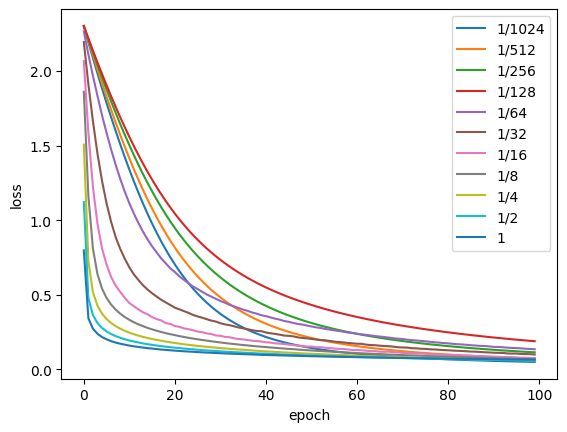

In [ ]:
plt.xlabel('epoch')
plt.ylabel('loss')
for i in range(len(p)):
  plt.plot(classifier_losses[i], label=f'{p_str[i]}')
plt.legend()

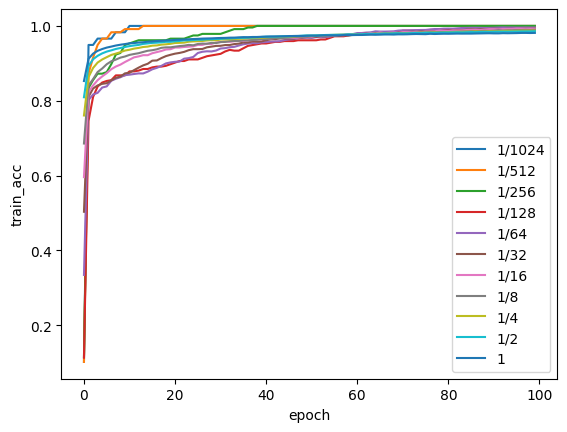

In [ ]:
plt.xlabel('epoch')
plt.ylabel('train_acc')
for i in range(len(p)):
  plt.plot(classifier_accs[i], label=f'{p_str[i]}')
plt.legend()

[0.7297000288963318, 0.7932999730110168, 0.8446000218391418, 0.8722000122070312, 0.8906999826431274, 0.9111999869346619, 0.9229999780654907, 0.9373000264167786, 0.9458000063896179, 0.951200008392334, 0.9560999870300293]


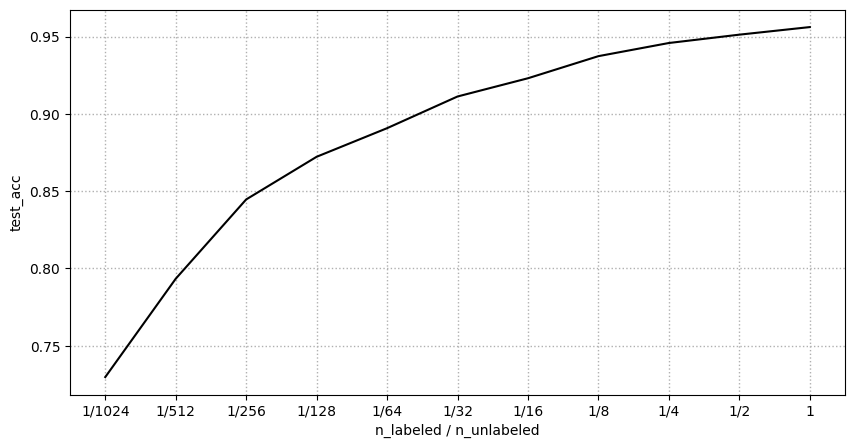

In [ ]:
print(test_accs)
plt.figure(figsize=(10,5))
plt.xlabel('n_labeled / n_unlabeled')
plt.ylabel('test_acc')
plt.grid(linestyle = ':', linewidth = 1)

plt.plot(p_str, test_accs, color='black')
plt.show()